In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ============================================================
# CELL 1: IMPORTS AND LOGGING SETUP
# ============================================================
import os
import sys
import json
import csv
import re
import time
import logging
from pathlib import Path
from datetime import datetime
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Project root
ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(ROOT))

# ============================================================
# LOGGING CONFIGURATION
# ============================================================
from src.utils.logging_config import Colors, setup_notebook_logging

# Configuration - CHANGE THESE AS NEEDED
EXPERIMENT_NAME = 'cvl_lines_pipeline'
DEBUG_CONSOLE = False  # Set to True to show DEBUG logs in console
LOG_DIR = ROOT / 'experiments' / 'cvl_lines_v2' / 'logs'

# Setup notebook logging (DEBUG always goes to file, console level configurable)
logger = setup_notebook_logging(
    experiment_name=EXPERIMENT_NAME,
    log_dir=str(LOG_DIR),
    debug=DEBUG_CONSOLE
)


# Print colored header
def print_header(title: str, subtitle: str = None):
    """Print a colored header for the notebook."""
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_GREEN}🚀 {title}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')
    logging.info(f'{Colors.CYAN}📅 Date:{Colors.RESET} {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    logging.info(f'{Colors.CYAN}📂 Project Root:{Colors.RESET} {ROOT}')
    logging.info(f'{Colors.CYAN}📁 Log Directory:{Colors.RESET} {LOG_DIR}')
    logging.info(f'{Colors.CYAN}📜 Log File:{Colors.RESET} {logger.log_file}')
    logging.info(f'{Colors.CYAN}🔧 Debug Console:{Colors.RESET} {DEBUG_CONSOLE}')
    device_str = "CUDA" if torch.cuda.is_available() else "CPU"
    logging.info(f'{Colors.CYAN}🖥️  Device:{Colors.RESET} {device_str}')
    if torch.cuda.is_available():
        logging.info(f'{Colors.GRAY}   GPU: {torch.cuda.get_device_name(0)}{Colors.RESET}')
        logging.info(
            f'{Colors.GRAY}   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB{Colors.RESET}')
    if subtitle:
        logging.info(f'{Colors.YELLOW}{subtitle}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')


print_header('CVL WRITER RETRIEVAL - COMPLETE PIPELINE')

19:19:48 | INFO     | ℹ️  
══════════════════════════════════════════════════════════════════════
19:19:48 | INFO     | ℹ️                           🚀 CVL_LINES_PIPELINE                         
19:19:48 | INFO     | ℹ️  ══════════════════════════════════════════════════════════════════════
19:19:48 | INFO     | 📁 Log file: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2/logs/cvl_lines_pipeline_20251206_191948.log
19:19:48 | INFO     | ℹ️  🕐 Started: 2025-12-06 19:19:48
19:19:48 | INFO     | ℹ️  ──────────────────────────────────────────────────────────────────────
19:19:48 | INFO     | ℹ️  ======================================================================
19:19:48 | INFO     | ℹ️  🚀 CVL WRITER RETRIEVAL - COMPLETE PIPELINE
19:19:48 | INFO     | ℹ️  ======================================================================
19:19:48 | INFO     | ℹ️  📅 Date: 2025-12-06 19:19:48
19:19:48 | INFO     | ℹ️  📂 Project Root: /home/spark/NUST/Semester 5/Deep L

In [3]:
# ============================================================
# CELL 2: PROJECT IMPORTS
# ============================================================
logger.info(Colors.BOLD_CYAN + '📦 Loading project modules...' + Colors.RESET)
# Scripts
from scripts.make_cvl_csv import main as make_cvl_csv
from scripts.make_cvl_labels import main as make_cvl_labels
from scripts.make_cvl_text_quantity import main as make_cvl_text_quantity
from scripts.make_ranks import main as make_ranks

# Training - Patch Level
from src.train.train_resnet_triplet import main as train_resnet_triplet
from src.train.fit_vlad_centers import main as fit_vlad_centers
from src.train.patch_dataset import PatchDataset
from src.train.triplet_loss import get_loss_function
from src.train.samplers import MPerClassSampler
from src.train.augmentation import get_train_augmentation

# Training - End-to-End (RECOMMENDED)
from src.train.page_bag_dataset import PageBagDataset, create_page_dataloader
from src.models.e2e_writer_net import EndToEndWriterNet

# Features
from src.features.resnet_patch_extractor import create_resnet_patch_encoder
from src.sampling.adaptive_sampler import AdaptiveSamplingConfig

# Evaluation
from src.evaluation.eval_retrieval import main as eval_retrieval
from src.evaluation.per_bin_csv import main as per_bin_csv
from src.evaluation.metrics import mean_average_precision
from src.evaluation.retrieval_engine import (
    extract_descriptors, fit_pca_whitening, apply_pca_whitening, RetrievalConfig
)

# Reranking
from src.reranking.sgr import apply_sgr

# Utils
from src.utils.preprocessing import load_image, binarize_otsu

logger.info(Colors.GREEN + '✅ All project modules loaded successfully!' + Colors.RESET)

19:19:53 | INFO     | ℹ️  📦 Loading project modules...
19:19:53 | INFO     | ℹ️  ✅ All project modules loaded successfully!


In [7]:
# ============================================================
# CELL 3: PATH CONFIGURATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '📂 Configuring paths...' + Colors.RESET)
# ============================================================
# 🔧 DATA LEVEL CONFIGURATION - CHANGE THIS TO SWITCH LEVELS
# ============================================================
# Options: 'pages' (full page images), 'lines' (individual text lines), 'words' (individual words)
# - 'pages': Full page images (easiest, most text per sample) - RECOMMENDED
# - 'lines': Individual text lines (medium difficulty)
# - 'words': Individual words (hardest, least text per sample)
DATA_LEVEL = 'lines'  # <-- CHANGE THIS TO 'lines' OR 'words' AS NEEDED

# Level-specific settings
LEVEL_CONFIGS = {
    'pages': {
        'description': 'Full page images',
        'subdir': 'pages',
        'patches_per_call': 8,  # More patches for larger images
        'm_per_class': 4,  # More samples per class
        'max_patches': 1500,
    },
    'lines': {
        'description': 'Individual text lines',
        'subdir': 'lines',
        'patches_per_call': 4,  # Fewer patches for smaller images
        'm_per_class': 8,  # More samples needed per class
        'max_patches': 200,
    },
    'words': {
        'description': 'Individual words (hardest task)',
        'subdir': 'words',
        'patches_per_call': 2,  # Even fewer patches
        'm_per_class': 12,  # Many samples needed
        'max_patches': 50,
    },
}

# Get level config
LEVEL_CFG = LEVEL_CONFIGS[DATA_LEVEL]
logger.info(Colors.CYAN + f'   📊 Data Level: {DATA_LEVEL} ({LEVEL_CFG["description"]})' + Colors.RESET)
# Data paths
DATA_DIR = ROOT / 'data'
CVL_DATA_DIR = DATA_DIR / 'CVL'

# Experiment paths (include level in name for organization)
EXP_DIR = ROOT / 'experiments' / f'cvl_{DATA_LEVEL}_v2'
CHECKPOINT_DIR = EXP_DIR / 'checkpoints'
RESULTS_DIR = EXP_DIR / 'results'
LOGS_DIR = EXP_DIR / 'logs'

# Clear cvl_lines_v2 directory if it exists (for fresh runs)
import shutil
if EXP_DIR.exists():
    logger.info(Colors.YELLOW + f'⚠️  Clearing existing experiment directory: {EXP_DIR}' + Colors.RESET)
    shutil.rmtree(EXP_DIR)
# Create directories
EXP_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR.mkdir(parents=True, exist_ok=True)

# File paths
CVL_TRAIN_CSV = EXP_DIR / 'cvl_train.csv'
CVL_TEST_CSV = EXP_DIR / 'cvl_test.csv'
CVL_LABELS_JSON = EXP_DIR / 'cvl_labels.json'
CVL_TEXT_QTY_JSON = EXP_DIR / 'cvl_text_quantity.json'

logger.info(Colors.CYAN + f'   📊 Data Level: {DATA_LEVEL} ({LEVEL_CFG["description"]})' + Colors.RESET)
logger.info(Colors.CYAN + f'   📁 Data Dir: {CVL_DATA_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   📁 Experiment Dir: {EXP_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   📁 Checkpoints Dir: {CHECKPOINT_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   📁 Results Dir: {RESULTS_DIR}' + Colors.RESET)
logger.info(Colors.GREEN + '✅ Paths configured!' + Colors.RESET)

19:22:48 | INFO     | ℹ️  📂 Configuring paths...
19:22:48 | INFO     | ℹ️     📊 Data Level: lines (Individual text lines)
19:22:48 | INFO     | ℹ️  ⚠️  Clearing existing experiment directory: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2
19:22:48 | INFO     | ℹ️     📊 Data Level: lines (Individual text lines)
19:22:48 | INFO     | ℹ️     📁 Data Dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/data/CVL
19:22:48 | INFO     | ℹ️     📁 Experiment Dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2
19:22:48 | INFO     | ℹ️     📁 Checkpoints Dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2/checkpoints
19:22:48 | INFO     | ℹ️     📁 Results Dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2/results
19:22:48 | INFO     | ℹ️  ✅ Paths configured!


## Step 1: Data Preparation

Generate train/test CSVs from the original CVL split based on the selected `DATA_LEVEL` (pages, lines, or words) and verify writer disjointness.

In [8]:
# ============================================================
# CELL 4: DATA PREPARATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📁 STEP 1: DATA PREPARATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Convert DATA_LEVEL to script format ('pages' -> 'page', 'lines' -> 'line', 'words' -> 'word')
LEVEL_MAP = {'pages': 'page', 'lines': 'line', 'words': 'word'}
script_level = LEVEL_MAP.get(DATA_LEVEL, 'page')

logger.info(Colors.CYAN + f'   📊 Using data level: {DATA_LEVEL} (script: {script_level})' + Colors.RESET)
# Check if CVL data exists
if not CVL_DATA_DIR.exists():
    logger.error(Colors.RED + f'❌ CVL data not found at: {CVL_DATA_DIR}' + Colors.RESET)
    logger.error(Colors.RED + '   Please download the CVL dataset first.' + Colors.RESET)
else:
    # Count available images for the selected level
    trainset_dir = CVL_DATA_DIR / 'trainset' / DATA_LEVEL
    testset_dir = CVL_DATA_DIR / 'testset' / DATA_LEVEL

    # Count images (handle nested structure for words)
    if DATA_LEVEL == 'words':
        train_images = list(trainset_dir.rglob('*.tif')) if trainset_dir.exists() else []
        test_images = list(testset_dir.rglob('*.tif')) if testset_dir.exists() else []
    else:
        train_images = list(trainset_dir.glob('*.tif')) if trainset_dir.exists() else []
        test_images = list(testset_dir.glob('*.tif')) if testset_dir.exists() else []

    logger.info(Colors.CYAN + f'   📊 CVL Dataset Overview ({DATA_LEVEL}):' + Colors.RESET)
    logger.info(Colors.CYAN + f'      📂 Trainset: {len(train_images)} {DATA_LEVEL}' + Colors.RESET)
    logger.info(Colors.CYAN + f'      📂 Testset: {len(test_images)} {DATA_LEVEL}' + Colors.RESET)

    # Generate CSVs with the correct level
    logger.info(Colors.MAGENTA + '\n🔄 Generating train/test CSVs for level=' + script_level + '...' + Colors.RESET)
    make_cvl_csv(data_dir=CVL_DATA_DIR, out_train=CVL_TRAIN_CSV, out_test=CVL_TEST_CSV, level=script_level)

    # Generate labels JSON
    logger.info(Colors.MAGENTA + '\n🔄 Generating labels JSON...' + Colors.RESET)
    make_cvl_labels(csv_path=CVL_TEST_CSV, out_json=CVL_LABELS_JSON)

    # Compute text quantity
    logger.info(Colors.MAGENTA + '\n🔄 Computing text quantity...' + Colors.RESET)
    make_cvl_text_quantity(csv_path=CVL_TEST_CSV, out_json=CVL_TEXT_QTY_JSON)

    logger.info(Colors.GREEN + '✅ Data preparation complete!' + Colors.RESET)

19:23:11 | INFO     | ℹ️  ======================================================================
19:23:11 | INFO     | ℹ️  
📁 STEP 1: DATA PREPARATION
19:23:11 | INFO     | ℹ️  ======================================================================
19:23:11 | INFO     | ℹ️     📊 Using data level: lines (script: line)
19:23:11 | INFO     | ℹ️     📊 CVL Dataset Overview (lines):
19:23:11 | INFO     | ℹ️        📂 Trainset: 0 lines
19:23:11 | INFO     | ℹ️        📂 Testset: 0 lines
19:23:11 | INFO     | ℹ️  
🔄 Generating train/test CSVs for level=line...
19:23:11 | INFO     | 📁 Log file: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2/logs/make_cvl_csv_20251206_192311.log
19:23:11 | INFO     | ℹ️  🕐 Started: 2025-12-06 19:23:11
19:23:11 | INFO     | ℹ️  📂 Scanning CVL dataset from /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/data/CVL...
19:23:11 | INFO     | ℹ️     trainset: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/data/CVL/tr

In [9]:
# ============================================================
# CELL 5: VERIFY WRITER DISJOINT SPLIT
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n🔍 STEP 1.5: VERIFY WRITER-DISJOINT SPLIT' + Colors.RESET)


# Load train/test writer IDs
def load_writers_from_csv(csv_path):
    writers = set()
    pages = 0
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            writers.add(int(row['writer_id']))
            pages += 1
    return writers, pages


train_writers, n_train = load_writers_from_csv(CVL_TRAIN_CSV)
test_writers, n_test = load_writers_from_csv(CVL_TEST_CSV)
overlap = train_writers & test_writers

logger.info(Colors.CYAN + f'\n📊 Split Statistics:' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╔══════════════════════════════════════════╗' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ║  Split   │  Writers  │  Pages  │ Avg     ║' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╠══════════════════════════════════════════╣' + Colors.RESET)
logger.info(
    Colors.YELLOW + f'   ║  Train   │  {len(train_writers):6d}   │  {n_train:5d}  │ {n_train / len(train_writers):4.1f}    ║' + Colors.RESET)
logger.info(
    Colors.YELLOW + f'   ║  Test    │  {len(test_writers):6d}   │  {n_test:5d}  │ {n_test / len(test_writers):4.1f}    ║' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╚══════════════════════════════════════════╝' + Colors.RESET)

logger.info(Colors.CYAN + f'\n🔍 Writer Overlap: {len(overlap)}' + Colors.RESET)
if len(overlap) == 0:
    logger.info(Colors.GREEN + '   ✅ PERFECT! No overlapping writers - correct evaluation protocol!' + Colors.RESET)
else:
    logger.error(Colors.RED + f'   ❌ WARNING: {len(overlap)} overlapping writers detected!' + Colors.RESET)
    logger.error(Colors.RED + f'   Overlapping IDs: {sorted(overlap)[:10]}...' + Colors.RESET)

19:24:35 | INFO     | ℹ️  
🔍 STEP 1.5: VERIFY WRITER-DISJOINT SPLIT
19:24:35 | INFO     | ℹ️  
📊 Split Statistics:
19:24:35 | INFO     | ℹ️     ╔══════════════════════════════════════════╗
19:24:35 | INFO     | ℹ️     ║  Split   │  Writers  │  Pages  │ Avg     ║
19:24:35 | INFO     | ℹ️     ╠══════════════════════════════════════════╣
19:24:35 | INFO     | ℹ️     ║  Train   │      27   │   1624  │ 60.1    ║
19:24:35 | INFO     | ℹ️     ║  Test    │     283   │  11849  │ 41.9    ║
19:24:35 | INFO     | ℹ️     ╚══════════════════════════════════════════╝
19:24:35 | INFO     | ℹ️  
🔍 Writer Overlap: 0
19:24:35 | INFO     | ℹ️     ✅ PERFECT! No overlapping writers - correct evaluation protocol!


## Step 2: Exploratory Data Analysis

Visualize dataset statistics and text quantity distribution.

19:25:08 | INFO     | ℹ️  ======================================================================
19:25:08 | INFO     | ℹ️  
📊 STEP 2: EXPLORATORY DATA ANALYSIS
19:25:08 | INFO     | ℹ️  ======================================================================
19:25:08 | INFO     | ℹ️  
📈 Text Quantity Statistics:
19:25:08 | INFO     | ℹ️     Total pages: 11849
19:25:08 | INFO     | ℹ️     Mean lines: 1.2
19:25:08 | INFO     | ℹ️     Median lines: 1.0
19:25:08 | INFO     | ℹ️     Min lines: 1
19:25:08 | INFO     | ℹ️     Max lines: 8
19:25:08 | INFO     | ℹ️     Std dev: 0.5


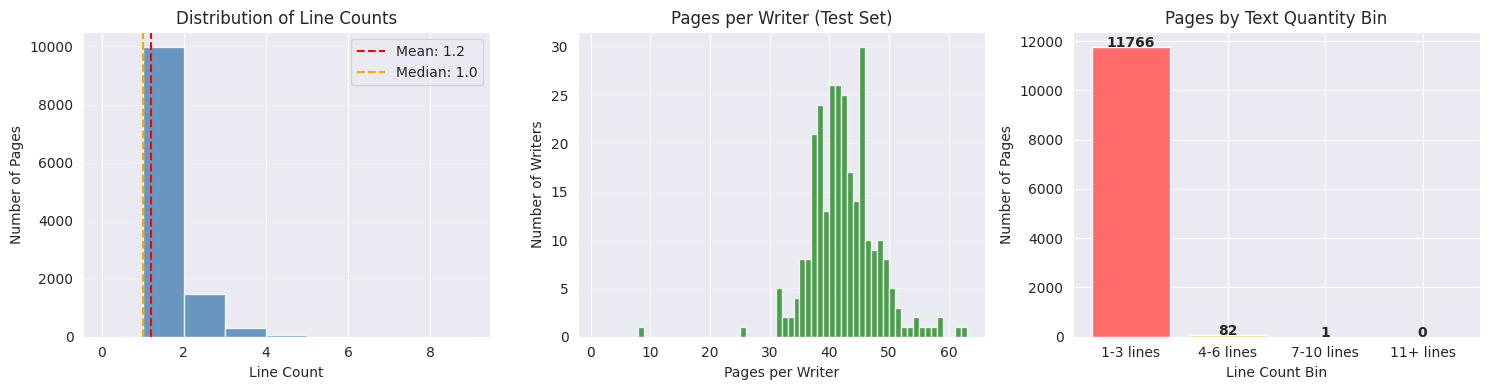

19:25:08 | INFO     | ℹ️  ✅ EDA complete!


In [10]:
# ============================================================
# CELL 6: EXPLORATORY DATA ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📊 STEP 2: EXPLORATORY DATA ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Load text quantity
with open(CVL_TEXT_QTY_JSON, 'r') as f:
    text_qty = json.load(f)

line_counts = list(text_qty.values())

# Statistics
logger.info(Colors.CYAN + f'\n📈 Text Quantity Statistics:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Total pages: {len(line_counts)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Mean lines: {np.mean(line_counts):.1f}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Median lines: {np.median(line_counts):.1f}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Min lines: {min(line_counts)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Max lines: {max(line_counts)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Std dev: {np.std(line_counts):.1f}' + Colors.RESET)

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(line_counts, bins=range(0, max(line_counts) + 2),
             color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(np.mean(line_counts), color='red', linestyle='--',
                label=f'Mean: {np.mean(line_counts):.1f}')
axes[0].axvline(np.median(line_counts), color='orange', linestyle='--',
                label=f'Median: {np.median(line_counts):.1f}')
axes[0].set_xlabel('Line Count')
axes[0].set_ylabel('Number of Pages')
axes[0].set_title('Distribution of Line Counts')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Pages per writer (test set)
writer_page_counts = defaultdict(int)
with open(CVL_TEST_CSV, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        writer_page_counts[row['writer_id']] += 1

pages_per_writer = list(writer_page_counts.values())
axes[1].hist(pages_per_writer, bins=range(1, max(pages_per_writer) + 2),
             color='forestgreen', edgecolor='white', alpha=0.8)
axes[1].set_xlabel('Pages per Writer')
axes[1].set_ylabel('Number of Writers')
axes[1].set_title('Pages per Writer (Test Set)')
axes[1].grid(axis='y', alpha=0.3)

# Box plot by quantile bins
bins = ['1-3 lines', '4-6 lines', '7-10 lines', '11+ lines']
bin_data = [
    [lc for lc in line_counts if lc <= 3],
    [lc for lc in line_counts if 4 <= lc <= 6],
    [lc for lc in line_counts if 7 <= lc <= 10],
    [lc for lc in line_counts if lc >= 11]
]
bin_counts = [len(b) for b in bin_data]

axes[2].bar(bins, bin_counts, color=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'],
            edgecolor='white')
axes[2].set_xlabel('Line Count Bin')
axes[2].set_ylabel('Number of Pages')
axes[2].set_title('Pages by Text Quantity Bin')
for i, v in enumerate(bin_counts):
    axes[2].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

logger.info(Colors.GREEN + '✅ EDA complete!' + Colors.RESET)

## Step 3: Training Configuration

Define training hyperparameters and experiment configurations.

In [12]:
# ============================================================
# CELL 7: TRAINING CONFIGURATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n⚙️  STEP 3: TRAINING CONFIGURATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
# ===== CVL-OPTIMIZED CONFIGURATION =====
# Settings are adjusted based on DATA_LEVEL (pages, lines, or words)

logger.info(Colors.CYAN + f'\n📊 Data Level: {DATA_LEVEL} ({LEVEL_CFG["description"]})' + Colors.RESET)
logger.info(Colors.CYAN + f'   Using level-specific settings from LEVEL_CFG' + Colors.RESET)

CVL_CONFIG = {
    # Data Level
    'data_level': DATA_LEVEL,  # Current data level

    # Model
    'backbone': 'resnet18',  # Options: 'small', 'small_deep', 'resnet18', 'resnet34'
    'pretrained': True,  # Use ImageNet pretrained weights
    'emb_dim': 128,  # Embedding dimension
    'freeze_bn': False,  # Freeze batch norm layers

    # Training
    'epochs': 30,  # More epochs for thorough training
    'batch_size': 128,  # Batch size
    'lr': 1e-4,  # Initial learning rate
    'final_lr': 1e-6,  # Final learning rate (cosine schedule)
    'warmup_epochs': 5,  # Warmup epochs
    'weight_decay': 0,  # Weight decay (0 for metric learning)
    'grad_clip': 2.0,  # Gradient clipping
    'patience': 7,  # Early stopping patience

    # Loss
    'loss_type': 'triplet',  # Options: 'triplet', 'semi_hard', 'ms', 'circle'
    'margin': 0.35,  # Triplet margin (higher for CVL)

    # Sampling - Use level-specific settings
    'm_per_class': LEVEL_CFG['m_per_class'],  # Samples per class (level-dependent)
    'patches_per_call': LEVEL_CFG['patches_per_call'],  # Multi-patch training (level-dependent)
    'sampler_mode': 'contour',  # Options: 'dense', 'char', 'contour', 'adaptive'
    'patch_size': 32,  # Patch size
    'max_patches': LEVEL_CFG['max_patches'],  # Max patches per image (level-dependent)

    # Augmentation
    'augment': True,
    'strong_augment': False,

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 4,
}

# Log configuration
logger.info(Colors.MAGENTA + '\n📋 CVL Training Configuration:' + Colors.RESET)
logger.info(Colors.YELLOW + '   ┌─────────────────────────────────────────────┐' + Colors.RESET)
for key, value in CVL_CONFIG.items():
    logger.info(Colors.YELLOW + f'   │ {key:20s} │ {str(value):20s} │' + Colors.RESET)
logger.info(Colors.YELLOW + '   └─────────────────────────────────────────────┘' + Colors.RESET)

# Calculate expected training stats
n_train_images = n_train
patches_per_epoch = n_train_images * CVL_CONFIG['patches_per_call']
batches_per_epoch = patches_per_epoch // CVL_CONFIG['batch_size']

logger.info(Colors.CYAN + f'\n📊 Training Statistics:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Data level: {DATA_LEVEL}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train images: {n_train_images}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Patches per image: {CVL_CONFIG["patches_per_call"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Max patches per image: {CVL_CONFIG["max_patches"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Patches per epoch: {patches_per_epoch:,}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Batches per epoch: ~{batches_per_epoch}' + Colors.RESET)

19:25:50 | INFO     | ℹ️  ======================================================================
19:25:50 | INFO     | ℹ️  
⚙️  STEP 3: TRAINING CONFIGURATION
19:25:50 | INFO     | ℹ️  ======================================================================
19:25:50 | INFO     | ℹ️  
📊 Data Level: lines (Individual text lines)
19:25:50 | INFO     | ℹ️     Using level-specific settings from LEVEL_CFG
19:25:50 | INFO     | ℹ️  
📋 CVL Training Configuration:
19:25:50 | INFO     | ℹ️     ┌─────────────────────────────────────────────┐
19:25:50 | INFO     | ℹ️     │ data_level           │ lines                │
19:25:50 | INFO     | ℹ️     │ backbone             │ resnet18             │
19:25:50 | INFO     | ℹ️     │ pretrained           │ True                 │
19:25:50 | INFO     | ℹ️     │ emb_dim              │ 128                  │
19:25:50 | INFO     | ℹ️     │ freeze_bn            │ False                │
19:25:50 | INFO     | ℹ️     │ epochs               │ 30                   │
19:

## Step 3.5: End-to-End Training Configuration (RECOMMENDED)

**Why End-to-End Training is Better:**

The standard patch-level training (Step 4) computes loss on **individual patches**. This is suboptimal because:
- Patches from the same writer can look very different (letter "a" vs word "the")
- The model learns patch similarity, not writer similarity
- This limits mAP to ~38% in practice

**End-to-End Training** computes loss on **aggregated PAGE descriptors**:
- All patches from a page are encoded and pooled (e.g., GeM pooling)
- Loss is computed on the pooled descriptor
- The model learns that "Page A and Page B come from the same writer"
- This can achieve 90%+ mAP

**Choose ONE training approach:**
- **Option A (below)**: End-to-End Training (RECOMMENDED for best results)
- **Option B (Step 4)**: Patch-Level Training (faster, for comparison/pretraining)

In [13]:
# ============================================================
# CELL 7.5: END-TO-END TRAINING CONFIGURATION
# ============================================================
# Set this to True to use E2E training (RECOMMENDED)
# Set to False to skip and use patch-level training (Step 4)
!rm -rf experiments/cvl_pages_v2/checkpoints/*
USE_E2E_TRAINING = True

E2E_CONFIG = {
    # Aggregation - GeM works best for most cases
    'agg_type': 'gem',  # Options: 'gem', 'mean', 'netvlad', 'netrvlad'
    'gem_p': 3.0,  # Initial GeM power (learnable)
    'num_clusters': 100,  # For NetVLAD only

    # Page-level training
    'patches_per_page': 32,  # Patches per page (32-64 recommended)
    'batch_size': 16,  # Pages per batch (limited by GPU memory)
    'm_per_class': 2,  # Pages per writer per batch (2 is standard)

    # Training
    'epochs': 50,  # More epochs for E2E
    'lr': 1e-4,  # Learning rate
    'final_lr': 1e-6,  # Final LR for cosine schedule
    'warmup_epochs': 5,
    'margin': 0.1,  # Triplet margin
    'weight_decay': 1e-5,

    # Use pretrained patch encoder (optional)
    'pretrained': None,  # Set to checkpoint path to fine-tune
}

logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n⚙️  END-TO-END TRAINING CONFIGURATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if USE_E2E_TRAINING:
    logger.info(Colors.GREEN + '\n✅ E2E Training ENABLED (recommended for best mAP)' + Colors.RESET)
    logger.info(Colors.MAGENTA + '\n📋 E2E Configuration:' + Colors.RESET)
    logger.info(Colors.YELLOW + '   ┌─────────────────────────────────────────────┐' + Colors.RESET)
    for key, value in E2E_CONFIG.items():
        logger.info(Colors.YELLOW + f'   │ {key:20s} │ {str(value):20s} │' + Colors.RESET)
    logger.info(Colors.YELLOW + '   └─────────────────────────────────────────────┘' + Colors.RESET)
    # Memory estimate
    mem_per_page = E2E_CONFIG['patches_per_page'] * 32 * 32 * 4  # float32
    mem_per_batch = E2E_CONFIG['batch_size'] * mem_per_page / 1e6
    logger.info(Colors.CYAN + f'\n📊 Memory Estimate:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ~{mem_per_batch:.1f} MB per batch (input only)' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Actual usage depends on model size and gradients' + Colors.RESET)
else:
    logger.info(Colors.YELLOW + '\n⚠️  E2E Training DISABLED - will use patch-level training (Step 4)' + Colors.RESET)
    logger.info(Colors.YELLOW + '   To enable, set USE_E2E_TRAINING = True above' + Colors.RESET)

19:26:39 | INFO     | ℹ️  ======================================================================
19:26:39 | INFO     | ℹ️  
⚙️  END-TO-END TRAINING CONFIGURATION
19:26:39 | INFO     | ℹ️  ======================================================================
19:26:39 | INFO     | ℹ️  
✅ E2E Training ENABLED (recommended for best mAP)
19:26:39 | INFO     | ℹ️  
📋 E2E Configuration:
19:26:39 | INFO     | ℹ️     ┌─────────────────────────────────────────────┐
19:26:39 | INFO     | ℹ️     │ agg_type             │ gem                  │
19:26:39 | INFO     | ℹ️     │ gem_p                │ 3.0                  │
19:26:39 | INFO     | ℹ️     │ num_clusters         │ 100                  │
19:26:39 | INFO     | ℹ️     │ patches_per_page     │ 32                   │
19:26:39 | INFO     | ℹ️     │ batch_size           │ 16                   │
19:26:39 | INFO     | ℹ️     │ m_per_class          │ 2                    │
19:26:39 | INFO     | ℹ️     │ epochs               │ 50                   │


In [16]:
# ============================================================
# CELL 7.6: RUN END-TO-END TRAINING
# ============================================================
if USE_E2E_TRAINING:
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '\n🏋️  END-TO-END TRAINING' + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

    # Import E2E training
    from src.train.train_e2e import main as train_e2e

    # Build training arguments
    e2e_args = [
        '--csv', str(CVL_TRAIN_CSV),
        '--root-dir', str(ROOT),
        '--epochs', str(E2E_CONFIG['epochs']),
        '--batch-size', str(E2E_CONFIG['batch_size']),
        '--patches-per-page', str(E2E_CONFIG['patches_per_page']),
        '--agg-type', E2E_CONFIG['agg_type'],
        '--gem-p', str(E2E_CONFIG['gem_p']),
        '--lr', str(E2E_CONFIG['lr']),
        '--final-lr', str(E2E_CONFIG['final_lr']),
        '--warmup-epochs', str(E2E_CONFIG['warmup_epochs']),
        '--margin', str(E2E_CONFIG['margin']),
        '--m-per-class', str(E2E_CONFIG['m_per_class']),
        '--weight-decay', str(E2E_CONFIG['weight_decay']),
        '--emb-dim', str(CVL_CONFIG['emb_dim']),
        '--sampler', CVL_CONFIG['sampler_mode'],
        '--device', CVL_CONFIG['device'],
        '--patience', str(CVL_CONFIG['patience']),
        '--save-dir', str(CHECKPOINT_DIR),
        '--debug',
        '--cache-patches',
    ]

    if E2E_CONFIG['pretrained']:
        e2e_args.extend(['--pretrained', str(E2E_CONFIG['pretrained'])])

    if CVL_CONFIG['augment']:
        e2e_args.append('--augment')

    logger.info(Colors.MAGENTA + '\n📋 E2E Training Arguments:' + Colors.RESET)
    for i in range(0, len(e2e_args), 2):
        if i + 1 < len(e2e_args) and not e2e_args[i + 1].startswith('--'):
            logger.info(Colors.YELLOW + f'   {e2e_args[i]}: {e2e_args[i + 1]}' + Colors.RESET)

    logger.info(Colors.CYAN + '\n🚀 Starting End-to-End training...' + Colors.RESET)
    logger.info(Colors.CYAN + '   📍 KEY DIFFERENCE: Loss on PAGE descriptors, not patches!' + Colors.RESET)
    logger.info(Colors.CYAN + '   This learns WRITER similarity, not patch similarity.' + Colors.RESET)
    logger.info(Colors.CYAN + '' + Colors.RESET)

    # Run training
    sys.argv = ['train_e2e.py'] + e2e_args
    train_start = time.time()

    try:
        train_e2e()
        train_time = time.time() - train_start
        logger.info(Colors.GREEN + f'\n✅ E2E Training complete in {train_time / 60:.1f} minutes!' + Colors.RESET)
        logger.info(
            Colors.GREEN + '   📁 Saved: best_*.pt (full E2E model), encoder_*.pt (patch encoder only)' + Colors.RESET)
    except Exception as e:
        logger.error(Colors.RED + f'❌ E2E Training failed: {e}' + Colors.RESET)
        raise
else:
    logger.info(Colors.YELLOW + '\n⏭️  Skipping E2E training (USE_E2E_TRAINING = False)' + Colors.RESET)
    logger.info(Colors.YELLOW + '   Will use patch-level training in Step 4 instead.' + Colors.RESET)

19:29:24 | INFO     | ℹ️  ======================================================================
19:29:24 | INFO     | ℹ️  
🏋️  END-TO-END TRAINING
19:29:24 | INFO     | ℹ️  ======================================================================
19:29:24 | INFO     | ℹ️  
📋 E2E Training Arguments:
19:29:24 | INFO     | ℹ️     --csv: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2/cvl_train.csv
19:29:24 | INFO     | ℹ️     --root-dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR
19:29:24 | INFO     | ℹ️     --epochs: 50
19:29:24 | INFO     | ℹ️     --batch-size: 16
19:29:24 | INFO     | ℹ️     --patches-per-page: 32
19:29:24 | INFO     | ℹ️     --agg-type: gem
19:29:24 | INFO     | ℹ️     --gem-p: 3.0
19:29:24 | INFO     | ℹ️     --lr: 0.0001
19:29:24 | INFO     | ℹ️     --final-lr: 1e-06
19:29:24 | INFO     | ℹ️     --warmup-epochs: 5
19:29:24 | INFO     | ℹ️     --margin: 0.1
19:29:24 | INFO     | ℹ️     --m-per-class: 2
19:29:24 | INFO  

## Step 4: Train Patch Encoder

Train the ResNet patch encoder with improved training pipeline.

In [17]:
# ============================================================
# CELL 8: TRAIN PATCH ENCODER (ALTERNATIVE TO E2E)
# ============================================================
# Skip this cell if you used E2E training above
if USE_E2E_TRAINING:
    logger.info(Colors.YELLOW + '\n⏭️  Skipping patch-level training (E2E training was used)' + Colors.RESET)
    logger.info(Colors.YELLOW + '   The E2E model already includes the patch encoder.' + Colors.RESET)
else:
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '\n🏋️  STEP 4: TRAIN PATCH ENCODER (Patch-Level)' + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.info(Colors.YELLOW + '\n⚠️  NOTE: This is patch-level training (suboptimal)' + Colors.RESET)
    logger.info(Colors.YELLOW + '   Consider using E2E training (Step 3.5) for better mAP.' + Colors.RESET)
    # Build training arguments
    train_args = [
        '--csv', str(CVL_TRAIN_CSV),
        '--root-dir', str(ROOT),
        '--epochs', str(CVL_CONFIG['epochs']),
        '--batch-size', str(CVL_CONFIG['batch_size']),
        '--sampler', CVL_CONFIG['sampler_mode'],
        '--emb-dim', str(CVL_CONFIG['emb_dim']),
        '--warmup-epochs', str(CVL_CONFIG['warmup_epochs']),
        '--grad-clip', str(CVL_CONFIG['grad_clip']),
        '--m-per-class', str(CVL_CONFIG['m_per_class']),
        '--device', CVL_CONFIG['device'],
        '--patience', str(CVL_CONFIG['patience']),
        '--save-dir', str(CHECKPOINT_DIR),
        '--debug',
    ]

    if CVL_CONFIG['augment']:
        train_args.append('--augment')

    logger.info(Colors.MAGENTA + '\n📋 Training Arguments:' + Colors.RESET)
    for i in range(0, len(train_args), 2):
        if i + 1 < len(train_args) and not train_args[i + 1].startswith('--'):
            logger.info(Colors.YELLOW + f'   {train_args[i]}: {train_args[i + 1]}' + Colors.RESET)

    logger.info(Colors.CYAN + '\n🚀 Starting patch-level training...' + Colors.RESET)
    logger.info(Colors.CYAN + '   📍 NOTE: Loss is computed on PATCH descriptors, not pages.' + Colors.RESET)
    logger.info(Colors.CYAN + '   This learns PATCH similarity, not writer similarity.' + Colors.RESET)
    logger.info(Colors.CYAN + '' + Colors.RESET)

    # Run training
    sys.argv = ['train_resnet_triplet.py'] + train_args
    train_start = time.time()

    try:
        train_resnet_triplet()
        train_time = time.time() - train_start
        logger.info(Colors.GREEN + f'\n✅ Training complete in {train_time / 60:.1f} minutes!' + Colors.RESET)
        logger.info(Colors.GREEN + '   📁 Saved: best_epoch_*.pt' + Colors.RESET)
    except Exception as e:
        logger.error(Colors.RED + f'❌ Training failed: {e}' + Colors.RESET)
        raise

19:33:37 | INFO     | ℹ️  
⏭️  Skipping patch-level training (E2E training was used)
19:33:37 | INFO     | ℹ️     The E2E model already includes the patch encoder.


In [18]:
# ============================================================
# CELL 9: FIND BEST CHECKPOINT
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔍 STEP 4.5: FIND BEST CHECKPOINT' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
# Find all checkpoints - both E2E and patch-level formats
# E2E checkpoints have encoder_*.pt (just the patch encoder)
# Patch-level checkpoints have best_epoch_*.pt

ckpt_list = list(CHECKPOINT_DIR.glob('best_epoch*_loss*.pt'))
encoder_list = list(CHECKPOINT_DIR.glob('encoder_epoch*_loss*.pt'))

if not ckpt_list and not encoder_list:
    # Try notebooks checkpoints as fallback
    ckpt_list = list((ROOT / 'notebooks' / 'checkpoints').glob('best_epoch*_loss*.pt'))


def extract_loss(p):
    m = re.search(r'loss_([0-9.]+)\.pt$', p.name)
    return float(m.group(1)) if m else float('inf')


# For E2E training, prefer encoder_*.pt (patch encoder only, compatible with eval)
# For patch-level, use best_epoch_*.pt
if encoder_list:
    logger.info(Colors.CYAN + '   📍 Found E2E encoder checkpoints (recommended)' + Colors.RESET)
    ckpt_list_sorted = sorted(encoder_list, key=extract_loss)
    is_e2e = True
elif ckpt_list:
    logger.info(Colors.CYAN + '   📍 Found patch-level checkpoints' + Colors.RESET)
    ckpt_list_sorted = sorted(ckpt_list, key=extract_loss)
    is_e2e = False
else:
    ckpt_list_sorted = []
    is_e2e = False

if ckpt_list_sorted:
    best_ckpt = ckpt_list_sorted[0]

    logger.info(Colors.CYAN + f'\n📂 Found {len(ckpt_list_sorted)} checkpoints:' + Colors.RESET)
    for i, ckpt in enumerate(ckpt_list_sorted[:5]):
        marker = ' ⭐ BEST' if i == 0 else ''
        logger.info(Colors.YELLOW + f'   {i + 1}. {ckpt.name} (loss: {extract_loss(ckpt):.4f}){marker}' + Colors.RESET)

    if len(ckpt_list_sorted) > 5:
        logger.info(Colors.YELLOW + f'   ... and {len(ckpt_list_sorted) - 5} more' + Colors.RESET)

    # Load and inspect best checkpoint
    ckpt_data = torch.load(best_ckpt, map_location='cpu')
    logger.info(Colors.MAGENTA + f'\n📊 Best Checkpoint Details:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Path: {best_ckpt}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Type: {"E2E Encoder" if is_e2e else "Patch-Level"}' + Colors.RESET)

    if isinstance(ckpt_data, dict):
        logger.info(Colors.CYAN + f'   Epoch: {ckpt_data.get("epoch", "N/A")}' + Colors.RESET)
        logger.info(Colors.CYAN + f'   Val Loss: {ckpt_data.get("val_loss", "N/A")}' + Colors.RESET)
        if 'args' in ckpt_data:
            logger.info(Colors.CYAN + f'   Embedding dim: {ckpt_data["args"].get("emb_dim", 64)}' + Colors.RESET)
            logger.info(Colors.CYAN + f'   Aggregation: {ckpt_data["args"].get("agg_type", "N/A")}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoints found!' + Colors.RESET)
    best_ckpt = None

19:33:50 | INFO     | ℹ️  ======================================================================
19:33:50 | INFO     | ℹ️  
🔍 STEP 4.5: FIND BEST CHECKPOINT
19:33:50 | INFO     | ℹ️  ======================================================================
19:33:50 | INFO     | ℹ️     📍 Found E2E encoder checkpoints (recommended)
19:33:50 | INFO     | ℹ️  
📂 Found 13 checkpoints:
19:33:50 | INFO     | ℹ️     1. encoder_epoch_31_loss_0.0313.pt (loss: 0.0313) ⭐ BEST
19:33:50 | INFO     | ℹ️     2. encoder_epoch_29_loss_0.0632.pt (loss: 0.0632)
19:33:50 | INFO     | ℹ️     3. encoder_epoch_24_loss_0.0815.pt (loss: 0.0815)
19:33:50 | INFO     | ℹ️     4. encoder_epoch_19_loss_0.0929.pt (loss: 0.0929)
19:33:50 | INFO     | ℹ️     5. encoder_epoch_12_loss_0.0957.pt (loss: 0.0957)
19:33:50 | INFO     | ℹ️     ... and 8 more
19:33:50 | INFO     | ℹ️  
📊 Best Checkpoint Details:
19:33:50 | INFO     | ℹ️     Path: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2/ch

## Step 5: Baseline Evaluation

Evaluate the trained model with default settings.

In [19]:
# ============================================================
# CELL 10: BASELINE EVALUATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📊 STEP 5: BASELINE EVALUATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt:
    logger.info(Colors.CYAN + f'\n🔍 Using checkpoint: {best_ckpt.name}' + Colors.RESET)
    logger.info(
        Colors.CYAN + f'   Evaluating on {n_test} test pages from {len(test_writers)} unseen writers' + Colors.RESET)

    # Basic evaluation with default settings
    eval_args = [
        '--csv', str(CVL_TEST_CSV),
        '--root-dir', str(ROOT),
        '--checkpoint', str(best_ckpt),
        '--agg-type', 'gem',
        '--mode', 'contour',
        '--device', CVL_CONFIG['device'],
    ]

    sys.argv = ['eval_retrieval.py'] + eval_args
    labels, paths, descs, metrics = eval_retrieval()

    # Save descriptors
    descs_path = RESULTS_DIR / 'cvl_descs_baseline.npy'
    np.save(descs_path, descs)

    logger.info(Colors.MAGENTA + f'\n📊 BASELINE RESULTS:' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┌───────────────────────────────┐' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  Metric  │  Value                │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠───────────────────────────────┨' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  mAP     │  {metrics["mAP"] * 100:6.2f}%              │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  Top-1   │  {metrics["Top1"] * 100:6.2f}%              │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  Top-5   │  {metrics["Top5"] * 100:6.2f}%              │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  Top-10  │  {metrics["Top10"] * 100:6.2f}%              │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   └───────────────────────────────┘' + Colors.RESET)

    baseline_mAP = metrics['mAP']
else:
    logger.error(Colors.RED + '❌ No checkpoint available. Run training first.' + Colors.RESET)

19:33:59 | INFO     | ℹ️  ======================================================================
19:33:59 | INFO     | ℹ️  
📊 STEP 5: BASELINE EVALUATION
19:33:59 | INFO     | ℹ️  ======================================================================
19:33:59 | INFO     | ℹ️  
🔍 Using checkpoint: encoder_epoch_31_loss_0.0313.pt
19:33:59 | INFO     | ℹ️     Evaluating on 11849 test pages from 283 unseen writers
19:33:59 | INFO     | ℹ️     Backbone from checkpoint: resnet18
19:33:59 | INFO     | ℹ️  ============================================================
19:33:59 | INFO     | 🎯 Writer Retrieval Evaluation
19:33:59 | INFO     | ℹ️  ============================================================
19:33:59 | INFO     | ℹ️  📄 Extracting descriptors from 11849 pages...
19:33:59 | INFO     | ℹ️     Aggregation: gem
19:33:59 | INFO     | ℹ️     GeM p-parameter: 3.0
19:33:59 | INFO     | ℹ️     Power normalization: ON (α=0.4)
19:33:59 | INFO     | ℹ️     PCA whitening: ON
19:33:59 | INFO     |

Extracting: 100%|██████████| 11849/11849 [05:05<00:00, 38.77it/s]

19:39:05 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 305.6s
19:39:05 | INFO     | ℹ️     Average patches per page: 450.8
19:39:05 | INFO     | ℹ️     Descriptor dimension: 128
19:39:05 | INFO     | ℹ️     Unique writers: 283
19:39:05 | INFO     | ℹ️  
19:39:05 | INFO     | 📊 Computing retrieval metrics...
19:39:05 | INFO     | 📊 Computing retrieval metrics...
19:39:05 | INFO     | ℹ️     Queries: 11849
19:39:05 | INFO     | ℹ️     Descriptor dim: 128
19:39:05 | INFO     | ℹ️     Unique writers: 283
19:39:05 | INFO     | ℹ️     Computing similarity matrix...


19:39:12 | INFO     | ℹ️     ✓ Metrics computed in 7.3s
19:39:12 | INFO     | ℹ️  
19:39:12 | INFO     | ℹ️     ╔════════════════════════════════╗
19:39:12 | INFO     | ℹ️     ║  mAP:      8.89%              ║
19:39:12 | INFO     | ℹ️     ║  Top-1:   27.84%              ║
19:39:12 | INFO     | ℹ️     ║  Top-5:   53.38%              ║
19:39:12 | INFO     | ℹ️     ║  Top-10:  64.21%              ║
19:39:12 | INFO     | ℹ️     ╚════════════════════════════════╝
19:39:12 | INFO     | ℹ️     ✓ Metrics computed in 7.3s
19:39:12 | INFO     | ℹ️  
19:39:12 | INFO     | 📈 Results:
19:39:12 | INFO     | ℹ️     mAP:    8.89%
19:39:12 | INFO     | ℹ️  ============================================================
19:39:12 | INFO     | ℹ️  
19:39:12 | INFO     | ℹ️  === Baseline retrieval ===
19:39:12 | INFO     | ℹ️    #queries: 11849
19:39:12 | INFO     | ℹ️    mAP:   0.0889
19:39:12 | INFO     | ℹ️    Top-1: 0.2784
19:39:12 | INFO     | ℹ️    Top-5: 0.5338
19:39:12 | INFO     | ℹ️    Top-10:0.6421

## Step 6: Comprehensive Ablation Study

Test all combinations of:
- **Sampling modes**: dense, contour, adaptive (auto)
- **Aggregation types**: sum, mean, gem, power-normalized
- **Reranking**: none, sgr, sgr_plus

In [20]:
# ============================================================
# CELL 11: COMPREHENSIVE ABLATION STUDY
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔬 STEP 6: COMPREHENSIVE ABLATION STUDY' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Define all experiment combinations
MODES = ['auto', 'dense', 'char', 'contour']
AGG_TYPES = ['netrvlad', 'gem', 'mean']
RERANKS = ['sgr_plus']  # Reranking is worse so keeping just sgr_plus for speed

# Generate all combinations
experiments = []
for mode in MODES:
    for agg in AGG_TYPES:
        for rerank in RERANKS:
            experiments.append((mode, agg, rerank))

logger.info(Colors.CYAN + f'\n📋 Running {len(experiments)} experiments:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Modes: {MODES}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Aggregations: {AGG_TYPES}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Reranking: {RERANKS}' + Colors.RESET)

results = []

if best_ckpt:
    for i, (mode, agg, rerank) in enumerate(experiments, 1):
        exp_name = f'{mode}+{agg}+{rerank}'
        logger.info(Colors.MAGENTA + f'\n[{i:2d}/{len(experiments)}] Experiment: {exp_name}' + Colors.RESET)
        # Log table format of configuration
        logger.info(Colors.YELLOW + f'   ┌───────────────────────────────┐' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   │  Parameter  │  Value                │' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   ┠───────────────────────────────┨' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   │  Mode       │  {mode:20s} │' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   │  Agg Type  │  {agg:20s} │' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   │  Rerank     │  {rerank:20s} │' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   └───────────────────────────────┘' + Colors.RESET)

        # Run evaluation
        try:
            args_eval = [
                '--csv', str(CVL_TEST_CSV),
                '--root-dir', str(ROOT),
                '--checkpoint', str(best_ckpt),
                '--agg-type', agg,
                '--mode', mode,
                '--device', CVL_CONFIG['device'],
            ]
            if rerank != 'none':
                args_eval += ['--rerank', rerank]

            sys.argv = ['eval_retrieval.py'] + args_eval
            _, _, _, metrics_dict = eval_retrieval()

            results.append({
                'mode': mode,
                'agg': agg,
                'rerank': rerank,
                'mAP': metrics_dict['mAP'],
                'Top1': metrics_dict['Top1'],
                'Top5': metrics_dict['Top5'],
                'Top10': metrics_dict['Top10'],
            })

            # Log the table format
            logger.info(Colors.YELLOW + f'   ┌───────────────────────────────┐' + Colors.RESET)
            logger.info(Colors.YELLOW + f'   │  Metric  │  Value             │' + Colors.RESET)
            logger.info(Colors.YELLOW + f'   ┠───────────────────────────────┨' + Colors.RESET)
            logger.info(
                Colors.YELLOW + f'   │  mAP     │  {metrics_dict["mAP"] * 100:6.2f}%           │' + Colors.RESET)
            logger.info(
                Colors.YELLOW + f'   │  Top-1   │  {metrics_dict["Top1"] * 100:6.2f}%          │' + Colors.RESET)
            logger.info(
                Colors.YELLOW + f'   │  Top-5   │  {metrics_dict["Top5"] * 100:6.2f}%          │' + Colors.RESET)
            logger.info(
                Colors.YELLOW + f'   │  Top-10  │  {metrics_dict["Top10"] * 100:6.2f}%         │' + Colors.RESET)
            logger.info(Colors.YELLOW + f'   └───────────────────────────────┘' + Colors.RESET)
        except Exception as e:
            logger.error(Colors.RED + f'❌ FAILED: {e}' + Colors.RESET)
            results.append({
                'mode': mode, 'agg': agg, 'rerank': rerank,
                'mAP': 0, 'Top1': 0, 'Top5': 0, 'Top10': 0
            })

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('mAP', ascending=False)

    # Save results
    results_csv = RESULTS_DIR / 'ablation_results.csv'
    results_df.to_csv(results_csv, index=False)
    logger.info(Colors.GREEN + f'\n✅ Ablation study complete! Results saved to: {results_csv}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoint available. Run training first.' + Colors.RESET)

19:39:26 | INFO     | ℹ️  ======================================================================
19:39:26 | INFO     | ℹ️  
🔬 STEP 6: COMPREHENSIVE ABLATION STUDY
19:39:26 | INFO     | ℹ️  ======================================================================
19:39:26 | INFO     | ℹ️  
📋 Running 12 experiments:
19:39:26 | INFO     | ℹ️     Modes: ['auto', 'dense', 'char', 'contour']
19:39:26 | INFO     | ℹ️     Aggregations: ['netrvlad', 'gem', 'mean']
19:39:26 | INFO     | ℹ️     Reranking: ['sgr_plus']
19:39:26 | INFO     | ℹ️  
[ 1/12] Experiment: auto+netrvlad+sgr_plus
19:39:26 | INFO     | ℹ️     ┌───────────────────────────────┐
19:39:26 | INFO     | ℹ️     │  Parameter  │  Value                │
19:39:26 | INFO     | ℹ️     ┠───────────────────────────────┨
19:39:26 | INFO     | ℹ️     │  Mode       │  auto                 │
19:39:26 | INFO     | ℹ️     │  Agg Type  │  netrvlad             │
19:39:26 | INFO     | ℹ️     │  Rerank     │  sgr_plus             │
19:39:26 | INFO    

Extracting:   0%|          | 23/11849 [00:00<03:40, 53.61it/s]

19:39:27 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)


Extracting:   0%|          | 48/11849 [00:00<02:54, 67.54it/s]

19:39:27 | WARNING  | ⚠️  No patches extracted from image of shape (146, 1600)


Extracting:   1%|          | 67/11849 [00:00<02:34, 76.35it/s]

19:39:28 | WARNING  | ⚠️  No patches extracted from image of shape (172, 713)


Extracting:   1%|          | 75/11849 [00:01<02:34, 76.35it/s]

19:39:28 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)
19:39:28 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:   2%|▏         | 229/11849 [00:02<02:24, 80.63it/s]

19:39:30 | WARNING  | ⚠️  No patches extracted from image of shape (150, 1309)


Extracting:   4%|▎         | 419/11849 [00:05<02:11, 86.92it/s]

19:39:32 | WARNING  | ⚠️  No patches extracted from image of shape (146, 612)


Extracting:   6%|▌         | 705/11849 [00:08<02:36, 71.21it/s] 

19:39:35 | WARNING  | ⚠️  No patches extracted from image of shape (127, 741)


Extracting:   6%|▌         | 722/11849 [00:08<02:31, 73.22it/s]

19:39:35 | WARNING  | ⚠️  No patches extracted from image of shape (106, 306)


Extracting:   7%|▋         | 858/11849 [00:10<02:16, 80.65it/s]

19:39:37 | WARNING  | ⚠️  No patches extracted from image of shape (134, 827)


Extracting:   7%|▋         | 878/11849 [00:10<02:04, 87.77it/s]

19:39:37 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:   8%|▊         | 944/11849 [00:11<02:16, 79.83it/s]

19:39:38 | WARNING  | ⚠️  No patches extracted from image of shape (160, 1600)


Extracting:   8%|▊         | 969/11849 [00:11<02:24, 75.54it/s]

19:39:38 | WARNING  | ⚠️  No patches extracted from image of shape (133, 1600)


Extracting:   8%|▊         | 996/11849 [00:12<02:18, 78.56it/s]

19:39:39 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1600)
19:39:39 | WARNING  | ⚠️  No patches extracted from image of shape (110, 510)


Extracting:   9%|▉         | 1108/11849 [00:13<02:18, 77.34it/s]

19:39:40 | WARNING  | ⚠️  No patches extracted from image of shape (113, 1599)
19:39:40 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1600)


Extracting:   9%|▉         | 1117/11849 [00:13<02:18, 77.70it/s]

19:39:40 | WARNING  | ⚠️  No patches extracted from image of shape (131, 1600)


Extracting:   9%|▉         | 1125/11849 [00:13<02:20, 76.49it/s]

19:39:40 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
19:39:40 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1139)
19:39:40 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)
19:39:40 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:  10%|▉         | 1150/11849 [00:13<02:19, 76.53it/s]

19:39:41 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1599)


Extracting:  10%|▉         | 1161/11849 [00:14<02:06, 84.41it/s]

19:39:41 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  10%|▉         | 1170/11849 [00:14<02:06, 84.72it/s]

19:39:41 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  10%|█         | 1187/11849 [00:14<02:19, 76.34it/s]

19:39:41 | WARNING  | ⚠️  No patches extracted from image of shape (152, 1540)


Extracting:  10%|█         | 1195/11849 [00:14<02:19, 76.53it/s]

19:39:41 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  10%|█         | 1204/11849 [00:14<02:15, 78.44it/s]

19:39:41 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)
19:39:41 | WARNING  | ⚠️  No patches extracted from image of shape (82, 1600)


Extracting:  10%|█         | 1223/11849 [00:14<02:05, 84.66it/s]

19:39:42 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  10%|█         | 1233/11849 [00:14<02:02, 86.98it/s]

19:39:42 | WARNING  | ⚠️  No patches extracted from image of shape (122, 1485)


Extracting:  10%|█         | 1242/11849 [00:15<02:06, 84.13it/s]

19:39:42 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  12%|█▏        | 1405/11849 [00:16<01:47, 96.78it/s] 

19:39:43 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1599)


Extracting:  12%|█▏        | 1415/11849 [00:16<01:53, 91.60it/s]

19:39:43 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)


Extracting:  12%|█▏        | 1425/11849 [00:16<01:54, 91.15it/s]

19:39:44 | WARNING  | ⚠️  No patches extracted from image of shape (133, 625)


Extracting:  12%|█▏        | 1435/11849 [00:17<01:54, 91.20it/s]

19:39:44 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1509)


Extracting:  13%|█▎        | 1536/11849 [00:17<01:47, 96.36it/s] 

19:39:45 | WARNING  | ⚠️  No patches extracted from image of shape (107, 801)


Extracting:  17%|█▋        | 1970/11849 [00:23<01:47, 92.32it/s] 

19:39:50 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1599)


Extracting:  17%|█▋        | 1990/11849 [00:23<01:51, 88.34it/s]

19:39:50 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1600)
19:39:50 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  17%|█▋        | 2060/11849 [00:24<01:48, 90.21it/s]

19:39:51 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1551)


Extracting:  17%|█▋        | 2070/11849 [00:24<01:45, 92.30it/s]

19:39:51 | WARNING  | ⚠️  No patches extracted from image of shape (73, 748)


Extracting:  18%|█▊        | 2091/11849 [00:24<01:45, 92.77it/s]

19:39:51 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)


Extracting:  18%|█▊        | 2119/11849 [00:24<01:59, 81.56it/s]

19:39:52 | WARNING  | ⚠️  No patches extracted from image of shape (165, 1383)


Extracting:  18%|█▊        | 2166/11849 [00:25<01:52, 86.03it/s]

19:39:52 | WARNING  | ⚠️  No patches extracted from image of shape (136, 1172)


Extracting:  19%|█▉        | 2238/11849 [00:26<01:38, 97.25it/s]

19:39:53 | WARNING  | ⚠️  No patches extracted from image of shape (70, 746)


Extracting:  21%|██        | 2472/11849 [00:29<01:59, 78.42it/s]

19:39:56 | WARNING  | ⚠️  No patches extracted from image of shape (123, 371)
19:39:56 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2484/11849 [00:29<01:44, 89.59it/s]

19:39:56 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2494/11849 [00:29<01:42, 91.30it/s]

19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (101, 404)


Extracting:  21%|██        | 2504/11849 [00:30<01:51, 84.12it/s]

19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)
19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  21%|██        | 2515/11849 [00:30<01:44, 89.52it/s]

19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (143, 1599)


Extracting:  21%|██▏       | 2525/11849 [00:30<01:46, 87.51it/s]

19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (100, 1600)


Extracting:  21%|██▏       | 2534/11849 [00:30<01:50, 84.25it/s]

19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  21%|██▏       | 2543/11849 [00:30<01:53, 82.24it/s]

19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  22%|██▏       | 2563/11849 [00:30<01:49, 84.78it/s]

19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)
19:39:57 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)


Extracting:  22%|██▏       | 2619/11849 [00:31<01:43, 89.48it/s]

19:39:58 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1351)


Extracting:  22%|██▏       | 2639/11849 [00:31<01:41, 90.42it/s]

19:39:58 | WARNING  | ⚠️  No patches extracted from image of shape (89, 1141)


Extracting:  22%|██▏       | 2659/11849 [00:31<01:39, 92.48it/s]

19:39:58 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  23%|██▎       | 2669/11849 [00:31<01:41, 90.32it/s]

19:39:59 | WARNING  | ⚠️  No patches extracted from image of shape (94, 1600)
19:39:59 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  23%|██▎       | 2688/11849 [00:32<01:42, 89.15it/s]

19:39:59 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  25%|██▍       | 2923/11849 [00:34<01:38, 90.16it/s]

19:40:02 | WARNING  | ⚠️  No patches extracted from image of shape (75, 1599)


Extracting:  25%|██▍       | 2943/11849 [00:35<01:38, 90.70it/s]

19:40:02 | WARNING  | ⚠️  No patches extracted from image of shape (115, 452)


Extracting:  26%|██▌       | 3093/11849 [00:36<01:20, 109.07it/s]

19:40:03 | WARNING  | ⚠️  No patches extracted from image of shape (70, 747)


Extracting:  26%|██▌       | 3105/11849 [00:36<01:21, 106.88it/s]

19:40:03 | WARNING  | ⚠️  No patches extracted from image of shape (73, 333)


Extracting:  26%|██▋       | 3127/11849 [00:36<01:30, 96.43it/s] 

19:40:04 | WARNING  | ⚠️  No patches extracted from image of shape (98, 1600)


Extracting:  26%|██▋       | 3137/11849 [00:37<01:39, 87.73it/s]

19:40:04 | WARNING  | ⚠️  No patches extracted from image of shape (78, 1600)


Extracting:  27%|██▋       | 3147/11849 [00:37<01:44, 83.29it/s]

19:40:04 | WARNING  | ⚠️  No patches extracted from image of shape (83, 1600)


Extracting:  27%|██▋       | 3156/11849 [00:37<01:49, 79.66it/s]

19:40:04 | WARNING  | ⚠️  No patches extracted from image of shape (92, 716)


Extracting:  27%|██▋       | 3189/11849 [00:37<02:01, 71.22it/s]

19:40:05 | WARNING  | ⚠️  No patches extracted from image of shape (87, 360)


Extracting:  27%|██▋       | 3211/11849 [00:38<01:37, 88.79it/s]

19:40:05 | WARNING  | ⚠️  No patches extracted from image of shape (103, 202)


Extracting:  30%|██▉       | 3543/11849 [00:41<01:39, 83.70it/s] 

19:40:08 | WARNING  | ⚠️  No patches extracted from image of shape (116, 756)


Extracting:  31%|███       | 3661/11849 [00:43<01:57, 69.89it/s]

19:40:10 | WARNING  | ⚠️  No patches extracted from image of shape (90, 1600)


Extracting:  32%|███▏      | 3744/11849 [00:44<01:37, 82.83it/s]

19:40:11 | WARNING  | ⚠️  No patches extracted from image of shape (103, 607)


Extracting:  33%|███▎      | 3955/11849 [00:46<01:19, 98.89it/s] 

19:40:13 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1600)


Extracting:  34%|███▍      | 4046/11849 [00:47<01:27, 89.08it/s]

19:40:14 | WARNING  | ⚠️  No patches extracted from image of shape (111, 444)


Extracting:  34%|███▍      | 4055/11849 [00:47<01:30, 86.29it/s]

19:40:14 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1127)


Extracting:  34%|███▍      | 4065/11849 [00:47<01:26, 89.50it/s]

19:40:14 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)
19:40:14 | WARNING  | ⚠️  No patches extracted from image of shape (107, 1600)


Extracting:  35%|███▍      | 4092/11849 [00:47<01:30, 85.60it/s]

19:40:15 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1401)


Extracting:  36%|███▌      | 4233/11849 [00:49<01:16, 99.21it/s] 

19:40:16 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)
19:40:16 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1459)


Extracting:  36%|███▋      | 4316/11849 [00:50<01:42, 73.50it/s]

19:40:17 | WARNING  | ⚠️  No patches extracted from image of shape (126, 780)


Extracting:  41%|████      | 4838/11849 [00:56<01:06, 105.60it/s]

19:40:23 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1599)


Extracting:  42%|████▏     | 5023/11849 [00:58<00:55, 123.10it/s]

19:40:25 | WARNING  | ⚠️  No patches extracted from image of shape (159, 1600)


Extracting:  43%|████▎     | 5064/11849 [00:58<01:05, 103.61it/s]

19:40:26 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1600)


Extracting:  45%|████▍     | 5275/11849 [01:01<01:33, 70.65it/s] 

19:40:28 | WARNING  | ⚠️  No patches extracted from image of shape (90, 585)


Extracting:  47%|████▋     | 5549/11849 [01:04<01:17, 81.39it/s] 

19:40:31 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1599)
19:40:31 | WARNING  | ⚠️  No patches extracted from image of shape (104, 602)


Extracting:  47%|████▋     | 5558/11849 [01:04<01:17, 80.99it/s]

19:40:31 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1600)


Extracting:  50%|████▉     | 5923/11849 [01:08<01:07, 87.61it/s] 

19:40:35 | WARNING  | ⚠️  No patches extracted from image of shape (108, 553)


Extracting:  52%|█████▏    | 6208/11849 [01:12<01:26, 65.57it/s] 

19:40:39 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1255)


Extracting:  54%|█████▍    | 6405/11849 [01:14<00:55, 98.43it/s] 

19:40:41 | WARNING  | ⚠️  No patches extracted from image of shape (77, 403)


Extracting:  54%|█████▍    | 6427/11849 [01:14<00:55, 98.16it/s] 

19:40:41 | WARNING  | ⚠️  No patches extracted from image of shape (133, 418)


Extracting:  55%|█████▌    | 6575/11849 [01:16<01:01, 86.19it/s]

19:40:43 | WARNING  | ⚠️  No patches extracted from image of shape (122, 284)


Extracting:  56%|█████▋    | 6693/11849 [01:17<00:45, 113.86it/s]

19:40:44 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1233)


Extracting:  59%|█████▊    | 6940/11849 [01:20<00:57, 85.74it/s] 

19:40:48 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1545)


Extracting:  59%|█████▊    | 6950/11849 [01:21<01:08, 71.73it/s]

19:40:48 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1396)


Extracting:  61%|██████    | 7170/11849 [01:24<01:03, 73.76it/s]

19:40:51 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  63%|██████▎   | 7417/11849 [01:27<00:56, 77.90it/s]

19:40:54 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  63%|██████▎   | 7426/11849 [01:27<00:58, 75.39it/s]

19:40:55 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)
19:40:55 | WARNING  | ⚠️  No patches extracted from image of shape (137, 1600)


Extracting:  64%|██████▍   | 7593/11849 [01:30<00:54, 78.79it/s]

19:40:57 | WARNING  | ⚠️  No patches extracted from image of shape (115, 1600)


Extracting:  64%|██████▍   | 7612/11849 [01:30<00:50, 83.63it/s]

19:40:57 | WARNING  | ⚠️  No patches extracted from image of shape (129, 1211)
19:40:57 | WARNING  | ⚠️  No patches extracted from image of shape (84, 1213)


Extracting:  68%|██████▊   | 8104/11849 [01:36<00:44, 83.64it/s] 

19:41:03 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1000)
19:41:03 | WARNING  | ⚠️  No patches extracted from image of shape (117, 988)


Extracting:  72%|███████▏  | 8521/11849 [01:41<00:40, 82.65it/s] 

19:41:08 | WARNING  | ⚠️  No patches extracted from image of shape (87, 276)


Extracting:  76%|███████▌  | 9012/11849 [01:47<00:31, 91.18it/s] 

19:41:14 | WARNING  | ⚠️  No patches extracted from image of shape (105, 816)


Extracting:  80%|███████▉  | 9472/11849 [01:52<00:22, 107.56it/s]

19:41:19 | WARNING  | ⚠️  No patches extracted from image of shape (105, 882)
19:41:19 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  80%|████████  | 9483/11849 [01:52<00:23, 102.39it/s]

19:41:19 | WARNING  | ⚠️  No patches extracted from image of shape (157, 628)
19:41:19 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1132)


Extracting:  80%|████████  | 9494/11849 [01:52<00:23, 98.20it/s] 

19:41:20 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1199)


Extracting:  82%|████████▏ | 9758/11849 [01:56<00:41, 50.56it/s]

19:41:23 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  82%|████████▏ | 9771/11849 [01:56<00:37, 55.59it/s]

19:41:23 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1458)


Extracting:  84%|████████▍ | 10012/11849 [02:00<00:31, 58.37it/s]

19:41:27 | WARNING  | ⚠️  No patches extracted from image of shape (119, 1446)


Extracting:  85%|████████▍ | 10025/11849 [02:00<00:31, 58.80it/s]

19:41:27 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1246)


Extracting:  85%|████████▌ | 10085/11849 [02:01<00:26, 67.15it/s]

19:41:28 | WARNING  | ⚠️  No patches extracted from image of shape (139, 626)
19:41:28 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  85%|████████▌ | 10102/11849 [02:01<00:25, 67.29it/s]

19:41:28 | WARNING  | ⚠️  No patches extracted from image of shape (94, 388)


Extracting:  87%|████████▋ | 10316/11849 [02:04<00:23, 64.81it/s]

19:41:31 | WARNING  | ⚠️  No patches extracted from image of shape (167, 429)


Extracting:  89%|████████▉ | 10550/11849 [02:07<00:14, 89.48it/s]

19:41:35 | WARNING  | ⚠️  No patches extracted from image of shape (111, 699)


Extracting:  91%|█████████▏| 10815/11849 [02:11<00:15, 68.89it/s] 

19:41:38 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1600)


Extracting:  91%|█████████▏| 10829/11849 [02:11<00:17, 58.65it/s]

19:41:38 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1302)


Extracting:  93%|█████████▎| 11025/11849 [02:14<00:09, 84.93it/s]

19:41:41 | WARNING  | ⚠️  No patches extracted from image of shape (145, 1411)
19:41:41 | WARNING  | ⚠️  No patches extracted from image of shape (116, 441)


Extracting:  93%|█████████▎| 11034/11849 [02:14<00:09, 83.54it/s]

19:41:41 | WARNING  | ⚠️  No patches extracted from image of shape (147, 1061)


Extracting:  94%|█████████▍| 11175/11849 [02:16<00:10, 61.83it/s]

19:41:43 | WARNING  | ⚠️  No patches extracted from image of shape (102, 536)


Extracting:  95%|█████████▍| 11255/11849 [02:17<00:06, 90.23it/s]

19:41:44 | WARNING  | ⚠️  No patches extracted from image of shape (98, 263)


Extracting:  97%|█████████▋| 11494/11849 [02:20<00:04, 85.80it/s]

19:41:47 | WARNING  | ⚠️  No patches extracted from image of shape (123, 1599)


Extracting: 100%|██████████| 11849/11849 [02:24<00:00, 81.99it/s] 


19:41:53 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 144.5s
19:41:53 | INFO     | ℹ️     Average patches per page: 14.4
19:41:53 | INFO     | ℹ️     Descriptor dimension: 12800
19:41:53 | INFO     | ℹ️     Unique writers: 283
19:41:53 | INFO     | ℹ️  
19:41:53 | INFO     | 📊 Computing retrieval metrics...
19:41:53 | INFO     | 📊 Computing retrieval metrics...
19:41:53 | INFO     | ℹ️     Queries: 11849
19:41:53 | INFO     | ℹ️     Descriptor dim: 12800
19:41:53 | INFO     | ℹ️     Unique writers: 283
19:41:53 | INFO     | ℹ️     Computing similarity matrix...
19:42:07 | INFO     | ℹ️     ✓ Metrics computed in 14.7s
19:42:07 | INFO     | ℹ️  
19:42:07 | INFO     | ℹ️     ╔════════════════════════════════╗
19:42:07 | INFO     | ℹ️     ║  mAP:      3.16%              ║
19:42:07 | INFO     | ℹ️     ║  Top-1:   10.22%              ║
19:42:07 | INFO     | ℹ️     ║  Top-5:   25.88%              ║
19:42:07 | INFO     | ℹ️     ║  Top-10:  35.89%              ║
19:42:07 | INFO     | ℹ️

Extracting:   0%|          | 27/11849 [00:00<03:10, 62.07it/s]

19:43:03 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)


Extracting:   0%|          | 52/11849 [00:00<02:35, 75.83it/s]

19:43:03 | WARNING  | ⚠️  No patches extracted from image of shape (146, 1600)


Extracting:   1%|          | 68/11849 [00:00<02:35, 75.75it/s]

19:43:03 | WARNING  | ⚠️  No patches extracted from image of shape (172, 713)


Extracting:   1%|          | 76/11849 [00:01<02:35, 75.90it/s]

19:43:03 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)
19:43:03 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:   2%|▏         | 232/11849 [00:02<02:11, 88.48it/s]

19:43:05 | WARNING  | ⚠️  No patches extracted from image of shape (150, 1309)


Extracting:   4%|▎         | 420/11849 [00:04<02:16, 83.98it/s] 

19:43:07 | WARNING  | ⚠️  No patches extracted from image of shape (146, 612)


Extracting:   6%|▌         | 710/11849 [00:08<02:08, 86.58it/s]

19:43:10 | WARNING  | ⚠️  No patches extracted from image of shape (127, 741)


Extracting:   6%|▌         | 720/11849 [00:08<02:04, 89.27it/s]

19:43:10 | WARNING  | ⚠️  No patches extracted from image of shape (106, 306)


Extracting:   7%|▋         | 860/11849 [00:09<02:04, 88.20it/s]

19:43:12 | WARNING  | ⚠️  No patches extracted from image of shape (134, 827)


Extracting:   7%|▋         | 881/11849 [00:10<01:54, 95.42it/s]

19:43:12 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:   8%|▊         | 948/11849 [00:10<02:13, 81.56it/s]

19:43:13 | WARNING  | ⚠️  No patches extracted from image of shape (160, 1600)


Extracting:   8%|▊         | 966/11849 [00:11<02:14, 81.05it/s]

19:43:13 | WARNING  | ⚠️  No patches extracted from image of shape (133, 1600)


Extracting:   8%|▊         | 993/11849 [00:11<02:11, 82.25it/s]

19:43:14 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1600)
19:43:14 | WARNING  | ⚠️  No patches extracted from image of shape (110, 510)


Extracting:   9%|▉         | 1107/11849 [00:12<02:06, 84.93it/s]

19:43:15 | WARNING  | ⚠️  No patches extracted from image of shape (113, 1599)


Extracting:   9%|▉         | 1116/11849 [00:12<02:09, 82.92it/s]

19:43:15 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1600)
19:43:15 | WARNING  | ⚠️  No patches extracted from image of shape (131, 1600)


Extracting:   9%|▉         | 1125/11849 [00:13<02:16, 78.84it/s]

19:43:15 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
19:43:15 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1139)
19:43:15 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)
19:43:15 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:  10%|▉         | 1142/11849 [00:13<02:14, 79.39it/s]

19:43:15 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1599)


Extracting:  10%|▉         | 1160/11849 [00:13<02:13, 80.08it/s]

19:43:16 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  10%|▉         | 1169/11849 [00:13<02:17, 77.49it/s]

19:43:16 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  10%|█         | 1185/11849 [00:13<02:28, 71.83it/s]

19:43:16 | WARNING  | ⚠️  No patches extracted from image of shape (152, 1540)


Extracting:  10%|█         | 1193/11849 [00:14<02:27, 72.44it/s]

19:43:16 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  10%|█         | 1202/11849 [00:14<02:18, 76.61it/s]

19:43:16 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)
19:43:16 | WARNING  | ⚠️  No patches extracted from image of shape (82, 1600)


Extracting:  10%|█         | 1219/11849 [00:14<02:17, 77.25it/s]

19:43:16 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  10%|█         | 1236/11849 [00:14<02:29, 70.93it/s]

19:43:17 | WARNING  | ⚠️  No patches extracted from image of shape (122, 1485)


Extracting:  10%|█         | 1244/11849 [00:14<02:35, 68.38it/s]

19:43:17 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  12%|█▏        | 1413/11849 [00:16<02:21, 73.93it/s]

19:43:19 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1599)
19:43:19 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)


Extracting:  12%|█▏        | 1429/11849 [00:17<02:31, 68.74it/s]

19:43:19 | WARNING  | ⚠️  No patches extracted from image of shape (133, 625)


Extracting:  12%|█▏        | 1437/11849 [00:17<02:27, 70.62it/s]

19:43:19 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1509)


Extracting:  13%|█▎        | 1537/11849 [00:18<02:00, 85.55it/s]

19:43:21 | WARNING  | ⚠️  No patches extracted from image of shape (107, 801)


Extracting:  17%|█▋        | 1969/11849 [00:23<02:02, 80.62it/s]

19:43:26 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1599)


Extracting:  17%|█▋        | 1996/11849 [00:23<01:59, 82.46it/s]

19:43:26 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1600)
19:43:26 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  17%|█▋        | 2061/11849 [00:24<01:53, 86.53it/s]

19:43:27 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1551)


Extracting:  17%|█▋        | 2071/11849 [00:24<01:49, 89.60it/s]

19:43:27 | WARNING  | ⚠️  No patches extracted from image of shape (73, 748)


Extracting:  18%|█▊        | 2089/11849 [00:24<01:53, 85.79it/s]

19:43:27 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)


Extracting:  18%|█▊        | 2124/11849 [00:25<02:04, 78.01it/s]

19:43:28 | WARNING  | ⚠️  No patches extracted from image of shape (165, 1383)


Extracting:  18%|█▊        | 2167/11849 [00:26<02:08, 75.39it/s]

19:43:28 | WARNING  | ⚠️  No patches extracted from image of shape (136, 1172)


Extracting:  19%|█▉        | 2234/11849 [00:26<01:50, 86.69it/s]

19:43:29 | WARNING  | ⚠️  No patches extracted from image of shape (70, 746)


Extracting:  21%|██        | 2477/11849 [00:29<01:55, 81.30it/s]

19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (123, 371)
19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2486/11849 [00:29<01:56, 80.04it/s]

19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2495/11849 [00:29<02:00, 77.72it/s]

19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (101, 404)


Extracting:  21%|██        | 2503/11849 [00:30<02:09, 72.01it/s]

19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)
19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  21%|██▏       | 2521/11849 [00:30<02:01, 76.77it/s]

19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (143, 1599)
19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (100, 1600)


Extracting:  21%|██▏       | 2530/11849 [00:30<01:59, 78.06it/s]

19:43:32 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  22%|██▏       | 2548/11849 [00:30<01:56, 80.17it/s]

19:43:33 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  22%|██▏       | 2557/11849 [00:30<01:56, 80.02it/s]

19:43:33 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  22%|██▏       | 2566/11849 [00:30<01:56, 79.86it/s]

19:43:33 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)
19:43:33 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)


Extracting:  22%|██▏       | 2621/11849 [00:31<01:50, 83.52it/s]

19:43:34 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1351)


Extracting:  22%|██▏       | 2639/11849 [00:31<01:47, 85.39it/s]

19:43:34 | WARNING  | ⚠️  No patches extracted from image of shape (89, 1141)


Extracting:  22%|██▏       | 2650/11849 [00:31<01:41, 90.65it/s]

19:43:34 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  23%|██▎       | 2670/11849 [00:32<01:45, 87.40it/s]

19:43:34 | WARNING  | ⚠️  No patches extracted from image of shape (94, 1600)
19:43:34 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  23%|██▎       | 2688/11849 [00:32<02:01, 75.62it/s]

19:43:34 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  25%|██▍       | 2928/11849 [00:35<01:40, 88.87it/s]

19:43:37 | WARNING  | ⚠️  No patches extracted from image of shape (75, 1599)


Extracting:  25%|██▍       | 2948/11849 [00:35<01:41, 88.05it/s]

19:43:37 | WARNING  | ⚠️  No patches extracted from image of shape (115, 452)


Extracting:  26%|██▌       | 3097/11849 [00:37<01:52, 78.05it/s]

19:43:39 | WARNING  | ⚠️  No patches extracted from image of shape (70, 747)


Extracting:  26%|██▌       | 3105/11849 [00:37<01:54, 76.33it/s]

19:43:40 | WARNING  | ⚠️  No patches extracted from image of shape (73, 333)


Extracting:  26%|██▋       | 3131/11849 [00:37<01:47, 80.84it/s]

19:43:40 | WARNING  | ⚠️  No patches extracted from image of shape (98, 1600)
19:43:40 | WARNING  | ⚠️  No patches extracted from image of shape (78, 1600)


Extracting:  27%|██▋       | 3150/11849 [00:37<01:42, 84.88it/s]

19:43:40 | WARNING  | ⚠️  No patches extracted from image of shape (83, 1600)
19:43:40 | WARNING  | ⚠️  No patches extracted from image of shape (92, 716)


Extracting:  27%|██▋       | 3187/11849 [00:38<01:41, 85.38it/s]

19:43:41 | WARNING  | ⚠️  No patches extracted from image of shape (87, 360)


Extracting:  27%|██▋       | 3216/11849 [00:38<01:38, 88.03it/s]

19:43:41 | WARNING  | ⚠️  No patches extracted from image of shape (103, 202)


Extracting:  30%|██▉       | 3545/11849 [00:42<01:29, 92.31it/s]

19:43:44 | WARNING  | ⚠️  No patches extracted from image of shape (116, 756)


Extracting:  31%|███       | 3663/11849 [00:43<01:36, 84.93it/s]

19:43:46 | WARNING  | ⚠️  No patches extracted from image of shape (90, 1600)


Extracting:  32%|███▏      | 3739/11849 [00:44<01:32, 87.62it/s]

19:43:47 | WARNING  | ⚠️  No patches extracted from image of shape (103, 607)


Extracting:  33%|███▎      | 3956/11849 [00:47<01:38, 80.37it/s]

19:43:50 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1600)


Extracting:  34%|███▍      | 4047/11849 [00:48<01:50, 70.49it/s]

19:43:51 | WARNING  | ⚠️  No patches extracted from image of shape (111, 444)


Extracting:  34%|███▍      | 4055/11849 [00:48<01:57, 66.28it/s]

19:43:51 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1127)


Extracting:  34%|███▍      | 4062/11849 [00:49<01:57, 66.15it/s]

19:43:51 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  34%|███▍      | 4070/11849 [00:49<01:53, 68.70it/s]

19:43:51 | WARNING  | ⚠️  No patches extracted from image of shape (107, 1600)


Extracting:  35%|███▍      | 4089/11849 [00:49<01:39, 78.09it/s]

19:43:51 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1401)


Extracting:  36%|███▌      | 4240/11849 [00:51<01:26, 87.96it/s]

19:43:53 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)
19:43:53 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1459)


Extracting:  36%|███▋      | 4314/11849 [00:51<01:27, 86.44it/s]

19:43:54 | WARNING  | ⚠️  No patches extracted from image of shape (126, 780)


Extracting:  41%|████      | 4839/11849 [00:58<01:18, 89.19it/s]

19:44:01 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1599)


Extracting:  42%|████▏     | 5032/11849 [01:01<01:20, 84.77it/s]

19:44:03 | WARNING  | ⚠️  No patches extracted from image of shape (159, 1600)


Extracting:  43%|████▎     | 5059/11849 [01:01<01:23, 81.29it/s]

19:44:04 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1600)


Extracting:  44%|████▍     | 5272/11849 [01:03<01:20, 82.09it/s]

19:44:06 | WARNING  | ⚠️  No patches extracted from image of shape (90, 585)


Extracting:  47%|████▋     | 5543/11849 [01:06<01:12, 86.96it/s]

19:44:09 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1599)
19:44:09 | WARNING  | ⚠️  No patches extracted from image of shape (104, 602)


Extracting:  47%|████▋     | 5561/11849 [01:07<01:17, 81.64it/s]

19:44:09 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1600)


Extracting:  50%|█████     | 5925/11849 [01:11<01:07, 87.63it/s]

19:44:14 | WARNING  | ⚠️  No patches extracted from image of shape (108, 553)


Extracting:  52%|█████▏    | 6213/11849 [01:14<01:08, 82.28it/s]

19:44:17 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1255)


Extracting:  54%|█████▍    | 6399/11849 [01:17<01:01, 89.33it/s]

19:44:19 | WARNING  | ⚠️  No patches extracted from image of shape (77, 403)


Extracting:  54%|█████▍    | 6429/11849 [01:17<01:01, 88.77it/s]

19:44:20 | WARNING  | ⚠️  No patches extracted from image of shape (133, 418)


Extracting:  55%|█████▌    | 6570/11849 [01:19<01:03, 83.19it/s]

19:44:21 | WARNING  | ⚠️  No patches extracted from image of shape (122, 284)


Extracting:  57%|█████▋    | 6702/11849 [01:21<01:10, 72.89it/s] 

19:44:23 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1233)


Extracting:  59%|█████▊    | 6946/11849 [01:23<00:56, 86.73it/s]

19:44:26 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1545)
19:44:26 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1396)


Extracting:  61%|██████    | 7171/11849 [01:26<01:03, 73.81it/s]

19:44:29 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  63%|██████▎   | 7416/11849 [01:30<01:04, 68.31it/s]

19:44:33 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  63%|██████▎   | 7423/11849 [01:30<01:04, 68.66it/s]

19:44:33 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)
19:44:33 | WARNING  | ⚠️  No patches extracted from image of shape (137, 1600)


Extracting:  64%|██████▍   | 7593/11849 [01:32<00:54, 78.59it/s]

19:44:35 | WARNING  | ⚠️  No patches extracted from image of shape (115, 1600)


Extracting:  64%|██████▍   | 7610/11849 [01:32<00:53, 79.27it/s]

19:44:35 | WARNING  | ⚠️  No patches extracted from image of shape (129, 1211)
19:44:35 | WARNING  | ⚠️  No patches extracted from image of shape (84, 1213)


Extracting:  68%|██████▊   | 8107/11849 [01:39<00:44, 83.45it/s]

19:44:41 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1000)
19:44:41 | WARNING  | ⚠️  No patches extracted from image of shape (117, 988)


Extracting:  72%|███████▏  | 8522/11849 [01:44<00:39, 84.35it/s]

19:44:46 | WARNING  | ⚠️  No patches extracted from image of shape (87, 276)


Extracting:  76%|███████▌  | 9013/11849 [01:50<00:48, 58.33it/s]

19:44:53 | WARNING  | ⚠️  No patches extracted from image of shape (105, 816)


Extracting:  80%|███████▉  | 9467/11849 [01:56<00:28, 82.61it/s] 

19:44:59 | WARNING  | ⚠️  No patches extracted from image of shape (105, 882)


Extracting:  80%|███████▉  | 9476/11849 [01:56<00:29, 81.79it/s]

19:44:59 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)
19:44:59 | WARNING  | ⚠️  No patches extracted from image of shape (157, 628)


Extracting:  80%|████████  | 9485/11849 [01:56<00:28, 82.99it/s]

19:44:59 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1132)


Extracting:  80%|████████  | 9494/11849 [01:56<00:27, 84.28it/s]

19:44:59 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1199)


Extracting:  82%|████████▏ | 9763/11849 [02:00<00:28, 72.12it/s]

19:45:02 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  82%|████████▏ | 9771/11849 [02:00<00:28, 72.31it/s]

19:45:03 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1458)


Extracting:  84%|████████▍ | 10009/11849 [02:03<00:22, 82.17it/s]

19:45:05 | WARNING  | ⚠️  No patches extracted from image of shape (119, 1446)


Extracting:  85%|████████▍ | 10027/11849 [02:03<00:22, 81.35it/s]

19:45:06 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1246)


Extracting:  85%|████████▌ | 10084/11849 [02:04<00:21, 83.87it/s]

19:45:06 | WARNING  | ⚠️  No patches extracted from image of shape (139, 626)
19:45:06 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  85%|████████▌ | 10102/11849 [02:04<00:21, 82.24it/s]

19:45:06 | WARNING  | ⚠️  No patches extracted from image of shape (94, 388)


Extracting:  87%|████████▋ | 10320/11849 [02:06<00:17, 88.85it/s]

19:45:09 | WARNING  | ⚠️  No patches extracted from image of shape (167, 429)


Extracting:  89%|████████▉ | 10551/11849 [02:09<00:14, 87.46it/s]

19:45:12 | WARNING  | ⚠️  No patches extracted from image of shape (111, 699)


Extracting:  91%|█████████ | 10811/11849 [02:12<00:11, 89.79it/s]

19:45:15 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1600)


Extracting:  91%|█████████▏| 10831/11849 [02:13<00:11, 88.70it/s]

19:45:15 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1302)


Extracting:  93%|█████████▎| 11015/11849 [02:15<00:09, 89.56it/s]

19:45:17 | WARNING  | ⚠️  No patches extracted from image of shape (145, 1411)


Extracting:  93%|█████████▎| 11028/11849 [02:15<00:08, 98.79it/s]

19:45:17 | WARNING  | ⚠️  No patches extracted from image of shape (116, 441)


Extracting:  93%|█████████▎| 11038/11849 [02:15<00:08, 95.17it/s]

19:45:17 | WARNING  | ⚠️  No patches extracted from image of shape (147, 1061)


Extracting:  94%|█████████▍| 11179/11849 [02:17<00:08, 83.63it/s]

19:45:19 | WARNING  | ⚠️  No patches extracted from image of shape (102, 536)


Extracting:  95%|█████████▍| 11252/11849 [02:17<00:07, 79.27it/s]

19:45:20 | WARNING  | ⚠️  No patches extracted from image of shape (98, 263)


Extracting:  97%|█████████▋| 11488/11849 [02:20<00:04, 88.94it/s]

19:45:23 | WARNING  | ⚠️  No patches extracted from image of shape (123, 1599)


Extracting: 100%|██████████| 11849/11849 [02:25<00:00, 81.52it/s] 

19:45:27 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 145.4s
19:45:27 | INFO     | ℹ️     Average patches per page: 14.4
19:45:27 | INFO     | ℹ️     Descriptor dimension: 128
19:45:27 | INFO     | ℹ️     Unique writers: 283
19:45:27 | INFO     | ℹ️  
19:45:27 | INFO     | 📊 Computing retrieval metrics...
19:45:27 | INFO     | 📊 Computing retrieval metrics...
19:45:27 | INFO     | ℹ️     Queries: 11849
19:45:27 | INFO     | ℹ️     Descriptor dim: 128
19:45:27 | INFO     | ℹ️     Unique writers: 283
19:45:27 | INFO     | ℹ️     Computing similarity matrix...


19:45:35 | INFO     | ℹ️     ✓ Metrics computed in 7.1s
19:45:35 | INFO     | ℹ️  
19:45:35 | INFO     | ℹ️     ╔════════════════════════════════╗
19:45:35 | INFO     | ℹ️     ║  mAP:      3.54%              ║
19:45:35 | INFO     | ℹ️     ║  Top-1:    9.60%              ║
19:45:35 | INFO     | ℹ️     ║  Top-5:   24.97%              ║
19:45:35 | INFO     | ℹ️     ║  Top-10:  35.13%              ║
19:45:35 | INFO     | ℹ️     ╚════════════════════════════════╝
19:45:35 | INFO     | ℹ️     ✓ Metrics computed in 7.1s
19:45:35 | INFO     | ℹ️  
19:45:35 | INFO     | 📈 Results:
19:45:35 | INFO     | ℹ️     mAP:    3.54%
19:45:35 | INFO     | ℹ️  ============================================================
19:45:35 | INFO     | ℹ️  
19:45:35 | INFO     | ℹ️  === Baseline retrieval ===
19:45:35 | INFO     | ℹ️    #queries: 11849
19:45:35 | INFO     | ℹ️    mAP:   0.0354
19:45:35 | INFO     | ℹ️    Top-1: 0.0960
19:45:35 | INFO     | ℹ️    Top-5: 0.2497
19:45:35 | INFO     | ℹ️    Top-10:0.3513

Extracting:   0%|          | 23/11849 [00:00<02:19, 85.07it/s] 

19:45:47 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)


Extracting:   0%|          | 47/11849 [00:00<01:57, 100.40it/s]

19:45:48 | WARNING  | ⚠️  No patches extracted from image of shape (146, 1600)


Extracting:   1%|          | 67/11849 [00:00<02:32, 77.29it/s] 

19:45:48 | WARNING  | ⚠️  No patches extracted from image of shape (172, 713)


Extracting:   1%|          | 76/11849 [00:00<02:28, 79.13it/s]

19:45:48 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)
19:45:48 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:   2%|▏         | 230/11849 [00:02<01:50, 104.85it/s]

19:45:49 | WARNING  | ⚠️  No patches extracted from image of shape (150, 1309)


Extracting:   4%|▎         | 425/11849 [00:04<02:15, 84.03it/s] 

19:45:51 | WARNING  | ⚠️  No patches extracted from image of shape (146, 612)


Extracting:   6%|▌         | 701/11849 [00:07<02:03, 90.57it/s]

19:45:55 | WARNING  | ⚠️  No patches extracted from image of shape (127, 741)


Extracting:   6%|▌         | 721/11849 [00:07<02:06, 88.02it/s]

19:45:55 | WARNING  | ⚠️  No patches extracted from image of shape (106, 306)


Extracting:   7%|▋         | 862/11849 [00:09<02:50, 64.57it/s]

19:45:57 | WARNING  | ⚠️  No patches extracted from image of shape (134, 827)


Extracting:   7%|▋         | 888/11849 [00:10<02:27, 74.16it/s]

19:45:57 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:   8%|▊         | 943/11849 [00:10<02:25, 75.10it/s]

19:45:58 | WARNING  | ⚠️  No patches extracted from image of shape (160, 1600)


Extracting:   8%|▊         | 967/11849 [00:11<02:33, 71.08it/s]

19:45:58 | WARNING  | ⚠️  No patches extracted from image of shape (133, 1600)


Extracting:   8%|▊         | 990/11849 [00:11<02:45, 65.48it/s]

19:45:59 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1600)


Extracting:   8%|▊         | 997/11849 [00:11<02:44, 65.93it/s]

19:45:59 | WARNING  | ⚠️  No patches extracted from image of shape (110, 510)


Extracting:   9%|▉         | 1106/11849 [00:12<02:09, 83.22it/s] 

19:46:00 | WARNING  | ⚠️  No patches extracted from image of shape (113, 1599)


Extracting:   9%|▉         | 1115/11849 [00:13<02:10, 82.32it/s]

19:46:00 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1600)
19:46:00 | WARNING  | ⚠️  No patches extracted from image of shape (131, 1600)


Extracting:   9%|▉         | 1124/11849 [00:13<02:12, 80.80it/s]

19:46:00 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
19:46:00 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1139)
19:46:00 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)
19:46:00 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:  10%|▉         | 1142/11849 [00:13<02:14, 79.55it/s]

19:46:01 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1599)


Extracting:  10%|▉         | 1159/11849 [00:13<02:15, 78.65it/s]

19:46:01 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  10%|▉         | 1167/11849 [00:13<02:18, 77.10it/s]

19:46:01 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  10%|▉         | 1184/11849 [00:13<02:14, 79.42it/s]

19:46:01 | WARNING  | ⚠️  No patches extracted from image of shape (152, 1540)


Extracting:  10%|█         | 1192/11849 [00:14<02:15, 78.46it/s]

19:46:01 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  10%|█         | 1201/11849 [00:14<02:14, 79.36it/s]

19:46:01 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)
19:46:01 | WARNING  | ⚠️  No patches extracted from image of shape (82, 1600)


Extracting:  10%|█         | 1220/11849 [00:14<02:02, 86.56it/s]

19:46:02 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  10%|█         | 1229/11849 [00:14<02:04, 85.57it/s]

19:46:02 | WARNING  | ⚠️  No patches extracted from image of shape (122, 1485)


Extracting:  10%|█         | 1239/11849 [00:14<01:59, 88.43it/s]

19:46:02 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  12%|█▏        | 1402/11849 [00:16<01:34, 110.78it/s]

19:46:04 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1599)


Extracting:  12%|█▏        | 1415/11849 [00:16<01:30, 115.71it/s]

19:46:04 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)


Extracting:  12%|█▏        | 1427/11849 [00:16<01:30, 115.58it/s]

19:46:04 | WARNING  | ⚠️  No patches extracted from image of shape (133, 625)
19:46:04 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1509)


Extracting:  13%|█▎        | 1539/11849 [00:17<01:49, 94.55it/s] 

19:46:05 | WARNING  | ⚠️  No patches extracted from image of shape (107, 801)


Extracting:  17%|█▋        | 1970/11849 [00:22<01:42, 96.24it/s] 

19:46:10 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1599)


Extracting:  17%|█▋        | 1990/11849 [00:22<01:46, 92.17it/s]

19:46:10 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1600)
19:46:10 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  17%|█▋        | 2057/11849 [00:23<01:48, 89.91it/s]

19:46:11 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1551)


Extracting:  17%|█▋        | 2067/11849 [00:23<01:48, 90.17it/s]

19:46:11 | WARNING  | ⚠️  No patches extracted from image of shape (73, 748)


Extracting:  18%|█▊        | 2087/11849 [00:23<01:45, 92.74it/s]

19:46:11 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)


Extracting:  18%|█▊        | 2116/11849 [00:24<01:51, 87.12it/s]

19:46:11 | WARNING  | ⚠️  No patches extracted from image of shape (165, 1383)


Extracting:  18%|█▊        | 2168/11849 [00:24<01:45, 91.97it/s]

19:46:12 | WARNING  | ⚠️  No patches extracted from image of shape (136, 1172)


Extracting:  19%|█▉        | 2243/11849 [00:25<01:30, 105.96it/s]

19:46:13 | WARNING  | ⚠️  No patches extracted from image of shape (70, 746)


Extracting:  21%|██        | 2475/11849 [00:27<01:48, 86.15it/s] 

19:46:15 | WARNING  | ⚠️  No patches extracted from image of shape (123, 371)
19:46:15 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2484/11849 [00:28<01:50, 84.71it/s]

19:46:15 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2493/11849 [00:28<01:54, 81.70it/s]

19:46:15 | WARNING  | ⚠️  No patches extracted from image of shape (101, 404)


Extracting:  21%|██        | 2502/11849 [00:28<01:52, 82.89it/s]

19:46:15 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  21%|██        | 2511/11849 [00:28<01:53, 82.13it/s]

19:46:16 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  21%|██▏       | 2520/11849 [00:28<01:54, 81.58it/s]

19:46:16 | WARNING  | ⚠️  No patches extracted from image of shape (143, 1599)
19:46:16 | WARNING  | ⚠️  No patches extracted from image of shape (100, 1600)


Extracting:  21%|██▏       | 2529/11849 [00:28<01:54, 81.33it/s]

19:46:16 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  21%|██▏       | 2547/11849 [00:28<01:53, 81.63it/s]

19:46:16 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  22%|██▏       | 2565/11849 [00:29<01:55, 80.22it/s]

19:46:16 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
19:46:16 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)
19:46:16 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)


Extracting:  22%|██▏       | 2612/11849 [00:29<01:46, 86.75it/s]

19:46:17 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1351)


Extracting:  22%|██▏       | 2640/11849 [00:29<01:23, 110.66it/s]

19:46:17 | WARNING  | ⚠️  No patches extracted from image of shape (89, 1141)


Extracting:  22%|██▏       | 2652/11849 [00:29<01:26, 106.14it/s]

19:46:17 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  22%|██▏       | 2663/11849 [00:30<01:31, 100.81it/s]

19:46:17 | WARNING  | ⚠️  No patches extracted from image of shape (94, 1600)


Extracting:  23%|██▎       | 2674/11849 [00:30<01:34, 97.16it/s] 

19:46:17 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  23%|██▎       | 2684/11849 [00:30<01:37, 94.09it/s]

19:46:17 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  25%|██▍       | 2930/11849 [00:33<01:39, 89.99it/s]

19:46:20 | WARNING  | ⚠️  No patches extracted from image of shape (75, 1599)


Extracting:  25%|██▍       | 2940/11849 [00:33<01:39, 89.99it/s]

19:46:20 | WARNING  | ⚠️  No patches extracted from image of shape (115, 452)


Extracting:  26%|██▌       | 3097/11849 [00:34<01:38, 88.80it/s]

19:46:22 | WARNING  | ⚠️  No patches extracted from image of shape (70, 747)


Extracting:  26%|██▌       | 3106/11849 [00:35<01:38, 88.40it/s]

19:46:22 | WARNING  | ⚠️  No patches extracted from image of shape (73, 333)


Extracting:  26%|██▋       | 3131/11849 [00:35<01:21, 106.48it/s]

19:46:22 | WARNING  | ⚠️  No patches extracted from image of shape (98, 1600)
19:46:22 | WARNING  | ⚠️  No patches extracted from image of shape (78, 1600)


Extracting:  27%|██▋       | 3144/11849 [00:35<01:17, 112.41it/s]

19:46:22 | WARNING  | ⚠️  No patches extracted from image of shape (83, 1600)


Extracting:  27%|██▋       | 3156/11849 [00:35<01:16, 113.63it/s]

19:46:23 | WARNING  | ⚠️  No patches extracted from image of shape (92, 716)


Extracting:  27%|██▋       | 3190/11849 [00:35<01:24, 102.14it/s]

19:46:23 | WARNING  | ⚠️  No patches extracted from image of shape (87, 360)


Extracting:  27%|██▋       | 3215/11849 [00:36<01:22, 104.86it/s]

19:46:23 | WARNING  | ⚠️  No patches extracted from image of shape (103, 202)


Extracting:  30%|██▉       | 3537/11849 [00:39<01:31, 91.01it/s] 

19:46:27 | WARNING  | ⚠️  No patches extracted from image of shape (116, 756)


Extracting:  31%|███       | 3662/11849 [00:41<02:03, 66.43it/s]

19:46:28 | WARNING  | ⚠️  No patches extracted from image of shape (90, 1600)


Extracting:  32%|███▏      | 3743/11849 [00:41<01:21, 99.68it/s] 

19:46:29 | WARNING  | ⚠️  No patches extracted from image of shape (103, 607)


Extracting:  33%|███▎      | 3951/11849 [00:44<01:04, 122.41it/s]

19:46:31 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1600)


Extracting:  34%|███▍      | 4041/11849 [00:44<01:18, 99.32it/s] 

19:46:32 | WARNING  | ⚠️  No patches extracted from image of shape (111, 444)


Extracting:  34%|███▍      | 4052/11849 [00:45<01:20, 97.09it/s]

19:46:32 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1127)
19:46:32 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  34%|███▍      | 4067/11849 [00:45<01:11, 109.35it/s]

19:46:32 | WARNING  | ⚠️  No patches extracted from image of shape (107, 1600)


Extracting:  35%|███▍      | 4090/11849 [00:45<01:19, 97.43it/s] 

19:46:33 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1401)


Extracting:  36%|███▌      | 4239/11849 [00:47<01:39, 76.72it/s]

19:46:34 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)
19:46:34 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1459)


Extracting:  36%|███▋      | 4314/11849 [00:47<01:14, 100.57it/s]

19:46:35 | WARNING  | ⚠️  No patches extracted from image of shape (126, 780)


Extracting:  41%|████      | 4839/11849 [00:53<00:48, 144.49it/s]

19:46:40 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1599)


Extracting:  42%|████▏     | 5030/11849 [00:55<01:15, 89.73it/s] 

19:46:43 | WARNING  | ⚠️  No patches extracted from image of shape (159, 1600)


Extracting:  43%|████▎     | 5059/11849 [00:55<01:18, 86.05it/s]

19:46:43 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1600)


Extracting:  45%|████▍     | 5274/11849 [00:58<01:17, 84.65it/s] 

19:46:45 | WARNING  | ⚠️  No patches extracted from image of shape (90, 585)


Extracting:  47%|████▋     | 5545/11849 [01:00<01:04, 97.41it/s] 

19:46:48 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1599)
19:46:48 | WARNING  | ⚠️  No patches extracted from image of shape (104, 602)


Extracting:  47%|████▋     | 5556/11849 [01:01<01:10, 89.74it/s]

19:46:48 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1600)


Extracting:  50%|█████     | 5929/11849 [01:05<01:01, 96.24it/s]

19:46:53 | WARNING  | ⚠️  No patches extracted from image of shape (108, 553)


Extracting:  52%|█████▏    | 6211/11849 [01:08<01:22, 68.51it/s] 

19:46:56 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1255)


Extracting:  54%|█████▍    | 6401/11849 [01:11<00:40, 133.48it/s]

19:46:58 | WARNING  | ⚠️  No patches extracted from image of shape (77, 403)


Extracting:  54%|█████▍    | 6428/11849 [01:11<00:47, 113.69it/s]

19:46:58 | WARNING  | ⚠️  No patches extracted from image of shape (133, 418)


Extracting:  55%|█████▌    | 6570/11849 [01:13<01:22, 63.81it/s] 

19:47:00 | WARNING  | ⚠️  No patches extracted from image of shape (122, 284)


Extracting:  57%|█████▋    | 6699/11849 [01:15<01:21, 62.91it/s]

19:47:02 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1233)


Extracting:  59%|█████▊    | 6939/11849 [01:17<00:54, 90.73it/s] 

19:47:05 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1545)


Extracting:  59%|█████▊    | 6949/11849 [01:17<00:54, 89.54it/s]

19:47:05 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1396)


Extracting:  61%|██████    | 7178/11849 [01:20<00:59, 78.91it/s]

19:47:08 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  63%|██████▎   | 7414/11849 [01:23<00:58, 76.35it/s] 

19:47:11 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  63%|██████▎   | 7425/11849 [01:23<00:51, 85.35it/s]

19:47:11 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)
19:47:11 | WARNING  | ⚠️  No patches extracted from image of shape (137, 1600)


Extracting:  64%|██████▍   | 7594/11849 [01:25<00:49, 85.59it/s]

19:47:13 | WARNING  | ⚠️  No patches extracted from image of shape (115, 1600)


Extracting:  64%|██████▍   | 7612/11849 [01:25<00:49, 85.29it/s]

19:47:13 | WARNING  | ⚠️  No patches extracted from image of shape (129, 1211)
19:47:13 | WARNING  | ⚠️  No patches extracted from image of shape (84, 1213)


Extracting:  68%|██████▊   | 8108/11849 [01:31<00:44, 83.71it/s] 

19:47:19 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1000)
19:47:19 | WARNING  | ⚠️  No patches extracted from image of shape (117, 988)


Extracting:  72%|███████▏  | 8520/11849 [01:36<00:30, 108.36it/s]

19:47:23 | WARNING  | ⚠️  No patches extracted from image of shape (87, 276)


Extracting:  76%|███████▌  | 9009/11849 [01:40<00:21, 131.00it/s]

19:47:27 | WARNING  | ⚠️  No patches extracted from image of shape (105, 816)


Extracting:  80%|███████▉  | 9461/11849 [01:45<00:21, 109.89it/s]

19:47:32 | WARNING  | ⚠️  No patches extracted from image of shape (105, 882)


Extracting:  80%|███████▉  | 9475/11849 [01:45<00:20, 116.82it/s]

19:47:32 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)
19:47:32 | WARNING  | ⚠️  No patches extracted from image of shape (157, 628)


Extracting:  80%|████████  | 9487/11849 [01:45<00:21, 109.05it/s]

19:47:32 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1132)
19:47:32 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1199)


Extracting:  82%|████████▏ | 9759/11849 [01:48<00:24, 85.28it/s] 

19:47:36 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  82%|████████▏ | 9768/11849 [01:48<00:24, 83.67it/s]

19:47:36 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1458)


Extracting:  84%|████████▍ | 10009/11849 [01:51<00:21, 86.24it/s]

19:47:39 | WARNING  | ⚠️  No patches extracted from image of shape (119, 1446)


Extracting:  85%|████████▍ | 10027/11849 [01:51<00:22, 80.36it/s]

19:47:39 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1246)


Extracting:  85%|████████▌ | 10085/11849 [01:52<00:19, 90.84it/s]

19:47:39 | WARNING  | ⚠️  No patches extracted from image of shape (139, 626)
19:47:39 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  85%|████████▌ | 10104/11849 [01:52<00:19, 89.41it/s]

19:47:40 | WARNING  | ⚠️  No patches extracted from image of shape (94, 388)


Extracting:  87%|████████▋ | 10319/11849 [01:54<00:16, 90.83it/s]

19:47:42 | WARNING  | ⚠️  No patches extracted from image of shape (167, 429)


Extracting:  89%|████████▉ | 10550/11849 [01:57<00:14, 90.07it/s]

19:47:45 | WARNING  | ⚠️  No patches extracted from image of shape (111, 699)


Extracting:  91%|█████████▏| 10816/11849 [02:00<00:13, 77.38it/s]

19:47:48 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1600)


Extracting:  91%|█████████▏| 10834/11849 [02:01<00:13, 75.99it/s]

19:47:48 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1302)


Extracting:  93%|█████████▎| 11017/11849 [02:02<00:08, 92.94it/s]

19:47:50 | WARNING  | ⚠️  No patches extracted from image of shape (145, 1411)


Extracting:  93%|█████████▎| 11027/11849 [02:03<00:09, 90.35it/s]

19:47:50 | WARNING  | ⚠️  No patches extracted from image of shape (116, 441)


Extracting:  93%|█████████▎| 11037/11849 [02:03<00:09, 89.18it/s]

19:47:50 | WARNING  | ⚠️  No patches extracted from image of shape (147, 1061)


Extracting:  94%|█████████▍| 11175/11849 [02:04<00:05, 131.43it/s]

19:47:51 | WARNING  | ⚠️  No patches extracted from image of shape (102, 536)


Extracting:  95%|█████████▍| 11256/11849 [02:05<00:05, 107.53it/s]

19:47:52 | WARNING  | ⚠️  No patches extracted from image of shape (98, 263)


Extracting:  97%|█████████▋| 11491/11849 [02:07<00:04, 87.36it/s] 

19:47:55 | WARNING  | ⚠️  No patches extracted from image of shape (123, 1599)


Extracting: 100%|██████████| 11849/11849 [02:12<00:00, 89.31it/s]

19:48:00 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 132.7s
19:48:00 | INFO     | ℹ️     Average patches per page: 14.4
19:48:00 | INFO     | ℹ️     Descriptor dimension: 128
19:48:00 | INFO     | ℹ️     Unique writers: 283
19:48:00 | INFO     | ℹ️  
19:48:00 | INFO     | 📊 Computing retrieval metrics...
19:48:00 | INFO     | 📊 Computing retrieval metrics...
19:48:00 | INFO     | ℹ️     Queries: 11849
19:48:00 | INFO     | ℹ️     Descriptor dim: 128
19:48:00 | INFO     | ℹ️     Unique writers: 283
19:48:00 | INFO     | ℹ️     Computing similarity matrix...


19:48:07 | INFO     | ℹ️     ✓ Metrics computed in 7.1s
19:48:07 | INFO     | ℹ️  
19:48:07 | INFO     | ℹ️     ╔════════════════════════════════╗
19:48:07 | INFO     | ℹ️     ║  mAP:      5.04%              ║
19:48:07 | INFO     | ℹ️     ║  Top-1:   13.60%              ║
19:48:07 | INFO     | ℹ️     ║  Top-5:   31.97%              ║
19:48:07 | INFO     | ℹ️     ║  Top-10:  42.72%              ║
19:48:07 | INFO     | ℹ️     ╚════════════════════════════════╝
19:48:07 | INFO     | ℹ️     ✓ Metrics computed in 7.1s
19:48:07 | INFO     | ℹ️  
19:48:07 | INFO     | 📈 Results:
19:48:07 | INFO     | ℹ️     mAP:    5.04%
19:48:07 | INFO     | ℹ️  ============================================================
19:48:07 | INFO     | ℹ️  
19:48:07 | INFO     | ℹ️  === Baseline retrieval ===
19:48:07 | INFO     | ℹ️    #queries: 11849
19:48:07 | INFO     | ℹ️    mAP:   0.0504
19:48:07 | INFO     | ℹ️    Top-1: 0.1360
19:48:07 | INFO     | ℹ️    Top-5: 0.3197
19:48:07 | INFO     | ℹ️    Top-10:0.4272

Extracting: 100%|██████████| 11849/11849 [02:32<00:00, 77.56it/s] 


19:50:52 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 152.8s
19:50:52 | INFO     | ℹ️     Average patches per page: 136.0
19:50:52 | INFO     | ℹ️     Descriptor dimension: 12800
19:50:52 | INFO     | ℹ️     Unique writers: 283
19:50:52 | INFO     | ℹ️  
19:50:52 | INFO     | 📊 Computing retrieval metrics...
19:50:52 | INFO     | 📊 Computing retrieval metrics...
19:50:52 | INFO     | ℹ️     Queries: 11849
19:50:52 | INFO     | ℹ️     Descriptor dim: 12800
19:50:52 | INFO     | ℹ️     Unique writers: 283
19:50:52 | INFO     | ℹ️     Computing similarity matrix...
19:51:04 | INFO     | ℹ️     ✓ Metrics computed in 11.7s
19:51:04 | INFO     | ℹ️  
19:51:04 | INFO     | ℹ️     ╔════════════════════════════════╗
19:51:04 | INFO     | ℹ️     ║  mAP:      6.14%              ║
19:51:04 | INFO     | ℹ️     ║  Top-1:   18.01%              ║
19:51:04 | INFO     | ℹ️     ║  Top-5:   41.42%              ║
19:51:04 | INFO     | ℹ️     ║  Top-10:  54.49%              ║
19:51:04 | INFO     | ℹ

Extracting: 100%|██████████| 11849/11849 [02:49<00:00, 70.00it/s] 

19:54:44 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 169.3s
19:54:44 | INFO     | ℹ️     Average patches per page: 136.0
19:54:44 | INFO     | ℹ️     Descriptor dimension: 128
19:54:44 | INFO     | ℹ️     Unique writers: 283
19:54:44 | INFO     | ℹ️  
19:54:44 | INFO     | 📊 Computing retrieval metrics...
19:54:44 | INFO     | 📊 Computing retrieval metrics...
19:54:44 | INFO     | ℹ️     Queries: 11849
19:54:44 | INFO     | ℹ️     Descriptor dim: 128
19:54:44 | INFO     | ℹ️     Unique writers: 283
19:54:44 | INFO     | ℹ️     Computing similarity matrix...


19:54:51 | INFO     | ℹ️     ✓ Metrics computed in 7.1s
19:54:51 | INFO     | ℹ️  
19:54:51 | INFO     | ℹ️     ╔════════════════════════════════╗
19:54:51 | INFO     | ℹ️     ║  mAP:      5.27%              ║
19:54:51 | INFO     | ℹ️     ║  Top-1:   17.28%              ║
19:54:51 | INFO     | ℹ️     ║  Top-5:   39.48%              ║
19:54:51 | INFO     | ℹ️     ║  Top-10:  51.88%              ║
19:54:51 | INFO     | ℹ️     ╚════════════════════════════════╝
19:54:51 | INFO     | ℹ️     ✓ Metrics computed in 7.2s
19:54:51 | INFO     | ℹ️  
19:54:51 | INFO     | 📈 Results:
19:54:51 | INFO     | ℹ️     mAP:    5.27%
19:54:51 | INFO     | ℹ️  ============================================================
19:54:51 | INFO     | ℹ️  
19:54:51 | INFO     | ℹ️  === Baseline retrieval ===
19:54:51 | INFO     | ℹ️    #queries: 11849
19:54:51 | INFO     | ℹ️    mAP:   0.0527
19:54:51 | INFO     | ℹ️    Top-1: 0.1728
19:54:51 | INFO     | ℹ️    Top-5: 0.3948
19:54:51 | INFO     | ℹ️    Top-10:0.5188

Extracting: 100%|██████████| 11849/11849 [02:33<00:00, 77.04it/s] 

19:57:38 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 153.8s
19:57:38 | INFO     | ℹ️     Average patches per page: 136.0
19:57:38 | INFO     | ℹ️     Descriptor dimension: 128
19:57:38 | INFO     | ℹ️     Unique writers: 283
19:57:38 | INFO     | ℹ️  
19:57:38 | INFO     | 📊 Computing retrieval metrics...
19:57:38 | INFO     | 📊 Computing retrieval metrics...
19:57:38 | INFO     | ℹ️     Queries: 11849
19:57:38 | INFO     | ℹ️     Descriptor dim: 128
19:57:38 | INFO     | ℹ️     Unique writers: 283
19:57:38 | INFO     | ℹ️     Computing similarity matrix...


19:57:45 | INFO     | ℹ️     ✓ Metrics computed in 7.1s
19:57:45 | INFO     | ℹ️  
19:57:45 | INFO     | ℹ️     ╔════════════════════════════════╗
19:57:45 | INFO     | ℹ️     ║  mAP:      7.85%              ║
19:57:45 | INFO     | ℹ️     ║  Top-1:   20.72%              ║
19:57:45 | INFO     | ℹ️     ║  Top-5:   45.54%              ║
19:57:45 | INFO     | ℹ️     ║  Top-10:  58.66%              ║
19:57:45 | INFO     | ℹ️     ╚════════════════════════════════╝
19:57:45 | INFO     | ℹ️     ✓ Metrics computed in 7.1s
19:57:45 | INFO     | ℹ️  
19:57:45 | INFO     | 📈 Results:
19:57:45 | INFO     | ℹ️     mAP:    7.85%
19:57:45 | INFO     | ℹ️  ============================================================
19:57:45 | INFO     | ℹ️  
19:57:45 | INFO     | ℹ️  === Baseline retrieval ===
19:57:45 | INFO     | ℹ️    #queries: 11849
19:57:45 | INFO     | ℹ️    mAP:   0.0785
19:57:45 | INFO     | ℹ️    Top-1: 0.2072
19:57:45 | INFO     | ℹ️    Top-5: 0.4554
19:57:45 | INFO     | ℹ️    Top-10:0.5866

Extracting:   0%|          | 27/11849 [00:00<02:41, 73.30it/s]

19:57:57 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)


Extracting:   0%|          | 44/11849 [00:00<02:46, 70.88it/s]

19:57:58 | WARNING  | ⚠️  No patches extracted from image of shape (146, 1600)


Extracting:   1%|          | 65/11849 [00:00<02:22, 82.81it/s]

19:57:58 | WARNING  | ⚠️  No patches extracted from image of shape (172, 713)


Extracting:   1%|          | 74/11849 [00:00<02:19, 84.46it/s]

19:57:58 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)
19:57:58 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:   2%|▏         | 228/11849 [00:03<03:20, 58.10it/s]

19:58:00 | WARNING  | ⚠️  No patches extracted from image of shape (150, 1309)


Extracting:   4%|▎         | 422/11849 [00:05<02:09, 88.53it/s]

19:58:03 | WARNING  | ⚠️  No patches extracted from image of shape (146, 612)


Extracting:   6%|▌         | 707/11849 [00:08<02:03, 90.16it/s] 

19:58:06 | WARNING  | ⚠️  No patches extracted from image of shape (127, 741)


Extracting:   6%|▌         | 717/11849 [00:09<02:09, 85.86it/s]

19:58:06 | WARNING  | ⚠️  No patches extracted from image of shape (106, 306)


Extracting:   7%|▋         | 861/11849 [00:10<02:08, 85.34it/s]

19:58:08 | WARNING  | ⚠️  No patches extracted from image of shape (134, 827)


Extracting:   7%|▋         | 881/11849 [00:11<01:58, 92.76it/s]

19:58:08 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:   8%|▊         | 948/11849 [00:11<02:03, 88.51it/s] 

19:58:09 | WARNING  | ⚠️  No patches extracted from image of shape (160, 1600)


Extracting:   8%|▊         | 967/11849 [00:11<02:23, 75.65it/s]

19:58:09 | WARNING  | ⚠️  No patches extracted from image of shape (133, 1600)


Extracting:   8%|▊         | 993/11849 [00:12<02:17, 78.96it/s]

19:58:09 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1600)
19:58:09 | WARNING  | ⚠️  No patches extracted from image of shape (110, 510)


Extracting:   9%|▉         | 1110/11849 [00:13<02:11, 81.46it/s]

19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (113, 1599)
19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1600)


Extracting:   9%|▉         | 1119/11849 [00:13<02:14, 79.86it/s]

19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (131, 1600)
19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1139)


Extracting:  10%|▉         | 1128/11849 [00:14<02:13, 80.29it/s]

19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)
19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:  10%|▉         | 1146/11849 [00:14<02:12, 80.82it/s]

19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1599)


Extracting:  10%|▉         | 1155/11849 [00:14<02:12, 80.94it/s]

19:58:11 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  10%|▉         | 1172/11849 [00:14<02:16, 77.99it/s]

19:58:12 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  10%|█         | 1189/11849 [00:14<02:16, 78.37it/s]

19:58:12 | WARNING  | ⚠️  No patches extracted from image of shape (152, 1540)


Extracting:  10%|█         | 1198/11849 [00:14<02:12, 80.12it/s]

19:58:12 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)
19:58:12 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)


Extracting:  10%|█         | 1207/11849 [00:15<02:12, 80.22it/s]

19:58:12 | WARNING  | ⚠️  No patches extracted from image of shape (82, 1600)


Extracting:  10%|█         | 1225/11849 [00:15<02:09, 82.34it/s]

19:58:12 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  10%|█         | 1236/11849 [00:15<01:57, 90.09it/s]

19:58:12 | WARNING  | ⚠️  No patches extracted from image of shape (122, 1485)
19:58:12 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  12%|█▏        | 1404/11849 [00:17<01:55, 90.27it/s]

19:58:14 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1599)


Extracting:  12%|█▏        | 1414/11849 [00:17<02:02, 85.43it/s]

19:58:14 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)


Extracting:  12%|█▏        | 1432/11849 [00:17<02:04, 83.51it/s]

19:58:15 | WARNING  | ⚠️  No patches extracted from image of shape (133, 625)
19:58:15 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1509)


Extracting:  13%|█▎        | 1536/11849 [00:18<01:52, 91.95it/s]

19:58:16 | WARNING  | ⚠️  No patches extracted from image of shape (107, 801)


Extracting:  17%|█▋        | 1968/11849 [00:23<01:53, 86.79it/s] 

19:58:21 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1599)


Extracting:  17%|█▋        | 1996/11849 [00:23<01:56, 84.89it/s]

19:58:21 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1600)
19:58:21 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  17%|█▋        | 2062/11849 [00:24<01:48, 90.41it/s]

19:58:22 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1551)


Extracting:  17%|█▋        | 2072/11849 [00:24<01:49, 89.18it/s]

19:58:22 | WARNING  | ⚠️  No patches extracted from image of shape (73, 748)


Extracting:  18%|█▊        | 2092/11849 [00:24<01:48, 90.10it/s]

19:58:22 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)


Extracting:  18%|█▊        | 2120/11849 [00:25<01:57, 82.65it/s]

19:58:22 | WARNING  | ⚠️  No patches extracted from image of shape (165, 1383)


Extracting:  18%|█▊        | 2161/11849 [00:25<01:38, 98.00it/s]

19:58:23 | WARNING  | ⚠️  No patches extracted from image of shape (136, 1172)


Extracting:  19%|█▉        | 2239/11849 [00:26<01:35, 100.68it/s]

19:58:23 | WARNING  | ⚠️  No patches extracted from image of shape (70, 746)


Extracting:  21%|██        | 2475/11849 [00:29<01:50, 84.82it/s] 

19:58:26 | WARNING  | ⚠️  No patches extracted from image of shape (123, 371)
19:58:26 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2484/11849 [00:29<01:54, 82.06it/s]

19:58:26 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2493/11849 [00:29<01:55, 80.70it/s]

19:58:26 | WARNING  | ⚠️  No patches extracted from image of shape (101, 404)


Extracting:  21%|██        | 2502/11849 [00:29<01:57, 79.22it/s]

19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  21%|██        | 2511/11849 [00:29<01:54, 81.31it/s]

19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  21%|██▏       | 2520/11849 [00:29<01:54, 81.45it/s]

19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (143, 1599)
19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (100, 1600)


Extracting:  21%|██▏       | 2529/11849 [00:29<01:55, 80.69it/s]

19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  21%|██▏       | 2547/11849 [00:29<01:55, 80.43it/s]

19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  22%|██▏       | 2565/11849 [00:30<01:58, 78.63it/s]

19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)
19:58:27 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)


Extracting:  22%|██▏       | 2623/11849 [00:30<01:45, 87.35it/s]

19:58:28 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1351)


Extracting:  22%|██▏       | 2641/11849 [00:31<01:55, 79.92it/s]

19:58:28 | WARNING  | ⚠️  No patches extracted from image of shape (89, 1141)


Extracting:  22%|██▏       | 2651/11849 [00:31<01:49, 84.09it/s]

19:58:28 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  22%|██▏       | 2661/11849 [00:31<01:46, 86.29it/s]

19:58:28 | WARNING  | ⚠️  No patches extracted from image of shape (94, 1600)


Extracting:  23%|██▎       | 2671/11849 [00:31<01:43, 88.36it/s]

19:58:29 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  23%|██▎       | 2689/11849 [00:31<02:00, 76.19it/s]

19:58:29 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  25%|██▍       | 2923/11849 [00:34<01:35, 93.38it/s] 

19:58:31 | WARNING  | ⚠️  No patches extracted from image of shape (75, 1599)


Extracting:  25%|██▍       | 2948/11849 [00:34<01:27, 101.31it/s]

19:58:32 | WARNING  | ⚠️  No patches extracted from image of shape (115, 452)


Extracting:  26%|██▌       | 3090/11849 [00:36<01:41, 86.32it/s] 

19:58:33 | WARNING  | ⚠️  No patches extracted from image of shape (70, 747)


Extracting:  26%|██▌       | 3108/11849 [00:36<01:42, 84.90it/s]

19:58:33 | WARNING  | ⚠️  No patches extracted from image of shape (73, 333)


Extracting:  26%|██▋       | 3126/11849 [00:36<01:40, 86.90it/s]

19:58:34 | WARNING  | ⚠️  No patches extracted from image of shape (98, 1600)


Extracting:  26%|██▋       | 3135/11849 [00:36<01:39, 87.32it/s]

19:58:34 | WARNING  | ⚠️  No patches extracted from image of shape (78, 1600)


Extracting:  27%|██▋       | 3145/11849 [00:36<01:38, 88.50it/s]

19:58:34 | WARNING  | ⚠️  No patches extracted from image of shape (83, 1600)


Extracting:  27%|██▋       | 3154/11849 [00:36<01:39, 87.15it/s]

19:58:34 | WARNING  | ⚠️  No patches extracted from image of shape (92, 716)


Extracting:  27%|██▋       | 3191/11849 [00:37<01:39, 87.30it/s]

19:58:34 | WARNING  | ⚠️  No patches extracted from image of shape (87, 360)


Extracting:  27%|██▋       | 3212/11849 [00:37<01:35, 90.04it/s]

19:58:35 | WARNING  | ⚠️  No patches extracted from image of shape (103, 202)


Extracting:  30%|██▉       | 3538/11849 [00:41<02:05, 66.41it/s] 

19:58:39 | WARNING  | ⚠️  No patches extracted from image of shape (116, 756)


Extracting:  31%|███       | 3657/11849 [00:42<01:05, 125.08it/s]

19:58:40 | WARNING  | ⚠️  No patches extracted from image of shape (90, 1600)


Extracting:  32%|███▏      | 3737/11849 [00:43<01:27, 93.14it/s] 

19:58:41 | WARNING  | ⚠️  No patches extracted from image of shape (103, 607)


Extracting:  33%|███▎      | 3961/11849 [00:45<01:25, 91.78it/s] 

19:58:43 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1600)


Extracting:  34%|███▍      | 4047/11849 [00:46<01:29, 86.98it/s]

19:58:44 | WARNING  | ⚠️  No patches extracted from image of shape (111, 444)
19:58:44 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1127)


Extracting:  34%|███▍      | 4057/11849 [00:47<01:28, 88.11it/s]

19:58:44 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  34%|███▍      | 4066/11849 [00:47<01:34, 81.96it/s]

19:58:44 | WARNING  | ⚠️  No patches extracted from image of shape (107, 1600)


Extracting:  35%|███▍      | 4093/11849 [00:47<01:37, 79.91it/s]

19:58:45 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1401)


Extracting:  36%|███▌      | 4229/11849 [00:48<00:59, 127.53it/s]

19:58:46 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  36%|███▌      | 4243/11849 [00:48<01:00, 125.66it/s]

19:58:46 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1459)


Extracting:  36%|███▋      | 4316/11849 [00:49<00:55, 135.22it/s]

19:58:46 | WARNING  | ⚠️  No patches extracted from image of shape (126, 780)


Extracting:  41%|████      | 4836/11849 [00:54<01:09, 100.26it/s]

19:58:52 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1599)


Extracting:  42%|████▏     | 5032/11849 [00:56<01:11, 95.01it/s] 

19:58:54 | WARNING  | ⚠️  No patches extracted from image of shape (159, 1600)


Extracting:  43%|████▎     | 5061/11849 [00:57<01:17, 87.91it/s]

19:58:54 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1600)


Extracting:  45%|████▍     | 5273/11849 [00:59<01:17, 84.84it/s] 

19:58:57 | WARNING  | ⚠️  No patches extracted from image of shape (90, 585)


Extracting:  47%|████▋     | 5548/11849 [01:02<01:17, 81.01it/s] 

19:59:00 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1599)
19:59:00 | WARNING  | ⚠️  No patches extracted from image of shape (104, 602)


Extracting:  47%|████▋     | 5557/11849 [01:03<01:21, 76.99it/s]

19:59:00 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1600)


Extracting:  50%|█████     | 5928/11849 [01:07<01:07, 87.50it/s] 

19:59:04 | WARNING  | ⚠️  No patches extracted from image of shape (108, 553)


Extracting:  52%|█████▏    | 6207/11849 [01:10<00:58, 97.16it/s] 

19:59:07 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1255)


Extracting:  54%|█████▍    | 6401/11849 [01:12<01:09, 78.19it/s]

19:59:10 | WARNING  | ⚠️  No patches extracted from image of shape (77, 403)


Extracting:  54%|█████▍    | 6430/11849 [01:12<01:04, 83.92it/s]

19:59:10 | WARNING  | ⚠️  No patches extracted from image of shape (133, 418)


Extracting:  55%|█████▌    | 6570/11849 [01:14<00:58, 90.55it/s]

19:59:12 | WARNING  | ⚠️  No patches extracted from image of shape (122, 284)


Extracting:  57%|█████▋    | 6695/11849 [01:16<00:59, 87.16it/s]

19:59:13 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1233)


Extracting:  59%|█████▊    | 6946/11849 [01:18<00:37, 129.93it/s]

19:59:16 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1545)
19:59:16 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1396)


Extracting:  61%|██████    | 7175/11849 [01:21<00:52, 88.32it/s] 

19:59:18 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  63%|██████▎   | 7413/11849 [01:24<00:57, 77.37it/s]

19:59:21 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  63%|██████▎   | 7421/11849 [01:24<00:56, 77.89it/s]

19:59:21 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)
19:59:21 | WARNING  | ⚠️  No patches extracted from image of shape (137, 1600)


Extracting:  64%|██████▍   | 7594/11849 [01:26<00:40, 103.98it/s]

19:59:23 | WARNING  | ⚠️  No patches extracted from image of shape (115, 1600)


Extracting:  64%|██████▍   | 7615/11849 [01:26<00:44, 94.55it/s] 

19:59:23 | WARNING  | ⚠️  No patches extracted from image of shape (129, 1211)
19:59:23 | WARNING  | ⚠️  No patches extracted from image of shape (84, 1213)


Extracting:  68%|██████▊   | 8108/11849 [01:32<00:44, 84.44it/s] 

19:59:29 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1000)
19:59:29 | WARNING  | ⚠️  No patches extracted from image of shape (117, 988)


Extracting:  72%|███████▏  | 8520/11849 [01:36<00:41, 79.76it/s] 

19:59:34 | WARNING  | ⚠️  No patches extracted from image of shape (87, 276)


Extracting:  76%|███████▌  | 9007/11849 [01:42<00:30, 93.21it/s]

19:59:40 | WARNING  | ⚠️  No patches extracted from image of shape (105, 816)


Extracting:  80%|███████▉  | 9472/11849 [01:47<00:25, 92.92it/s] 

19:59:45 | WARNING  | ⚠️  No patches extracted from image of shape (105, 882)
19:59:45 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  80%|████████  | 9482/11849 [01:47<00:25, 91.16it/s]

19:59:45 | WARNING  | ⚠️  No patches extracted from image of shape (157, 628)
19:59:45 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1132)


Extracting:  80%|████████  | 9492/11849 [01:48<00:26, 90.57it/s]

19:59:45 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1199)


Extracting:  82%|████████▏ | 9763/11849 [01:51<00:28, 73.18it/s]

19:59:48 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  82%|████████▏ | 9771/11849 [01:51<00:27, 74.81it/s]

19:59:49 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1458)


Extracting:  85%|████████▍ | 10015/11849 [01:54<00:21, 84.54it/s]

19:59:51 | WARNING  | ⚠️  No patches extracted from image of shape (119, 1446)


Extracting:  85%|████████▍ | 10024/11849 [01:54<00:24, 75.34it/s]

19:59:51 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1246)


Extracting:  85%|████████▌ | 10081/11849 [01:55<00:29, 60.73it/s]

19:59:52 | WARNING  | ⚠️  No patches extracted from image of shape (139, 626)


Extracting:  85%|████████▌ | 10088/11849 [01:55<00:28, 62.89it/s]

19:59:52 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  85%|████████▌ | 10096/11849 [01:55<00:25, 67.54it/s]

19:59:53 | WARNING  | ⚠️  No patches extracted from image of shape (94, 388)


Extracting:  87%|████████▋ | 10317/11849 [01:57<00:17, 86.51it/s] 

19:59:55 | WARNING  | ⚠️  No patches extracted from image of shape (167, 429)


Extracting:  89%|████████▉ | 10541/11849 [01:59<00:12, 104.12it/s]

19:59:57 | WARNING  | ⚠️  No patches extracted from image of shape (111, 699)


Extracting:  91%|█████████ | 10810/11849 [02:03<00:08, 125.62it/s]

20:00:00 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1600)


Extracting:  91%|█████████▏| 10836/11849 [02:03<00:09, 111.98it/s]

20:00:01 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1302)


Extracting:  93%|█████████▎| 11017/11849 [02:05<00:09, 84.31it/s] 

20:00:03 | WARNING  | ⚠️  No patches extracted from image of shape (145, 1411)


Extracting:  93%|█████████▎| 11026/11849 [02:05<00:09, 85.25it/s]

20:00:03 | WARNING  | ⚠️  No patches extracted from image of shape (116, 441)


Extracting:  93%|█████████▎| 11035/11849 [02:05<00:09, 83.70it/s]

20:00:03 | WARNING  | ⚠️  No patches extracted from image of shape (147, 1061)


Extracting:  94%|█████████▍| 11178/11849 [02:07<00:07, 93.16it/s] 

20:00:04 | WARNING  | ⚠️  No patches extracted from image of shape (102, 536)


Extracting:  95%|█████████▍| 11251/11849 [02:08<00:07, 78.68it/s]

20:00:05 | WARNING  | ⚠️  No patches extracted from image of shape (98, 263)


Extracting:  97%|█████████▋| 11487/11849 [02:10<00:03, 90.57it/s] 

20:00:08 | WARNING  | ⚠️  No patches extracted from image of shape (123, 1599)


Extracting: 100%|██████████| 11849/11849 [02:14<00:00, 87.88it/s] 


20:00:12 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 134.8s
20:00:12 | INFO     | ℹ️     Average patches per page: 13.6
20:00:12 | INFO     | ℹ️     Descriptor dimension: 12800
20:00:12 | INFO     | ℹ️     Unique writers: 283
20:00:12 | INFO     | ℹ️  
20:00:12 | INFO     | 📊 Computing retrieval metrics...
20:00:12 | INFO     | 📊 Computing retrieval metrics...
20:00:12 | INFO     | ℹ️     Queries: 11849
20:00:12 | INFO     | ℹ️     Descriptor dim: 12800
20:00:12 | INFO     | ℹ️     Unique writers: 283
20:00:12 | INFO     | ℹ️     Computing similarity matrix...
20:00:24 | INFO     | ℹ️     ✓ Metrics computed in 11.7s
20:00:24 | INFO     | ℹ️  
20:00:24 | INFO     | ℹ️     ╔════════════════════════════════╗
20:00:24 | INFO     | ℹ️     ║  mAP:      3.17%              ║
20:00:24 | INFO     | ℹ️     ║  Top-1:   10.15%              ║
20:00:24 | INFO     | ℹ️     ║  Top-5:   25.82%              ║
20:00:24 | INFO     | ℹ️     ║  Top-10:  35.88%              ║
20:00:24 | INFO     | ℹ️

Extracting:   0%|          | 25/11849 [00:00<03:05, 63.74it/s]

20:01:13 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)


Extracting:   0%|          | 51/11849 [00:00<02:31, 77.74it/s]

20:01:14 | WARNING  | ⚠️  No patches extracted from image of shape (146, 1600)


Extracting:   1%|          | 60/11849 [00:00<02:28, 79.26it/s]

20:01:14 | WARNING  | ⚠️  No patches extracted from image of shape (172, 713)


Extracting:   1%|          | 70/11849 [00:00<02:23, 82.29it/s]

20:01:14 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)


Extracting:   1%|          | 79/11849 [00:01<02:24, 81.54it/s]

20:01:14 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:   2%|▏         | 232/11849 [00:02<02:14, 86.67it/s]

20:01:16 | WARNING  | ⚠️  No patches extracted from image of shape (150, 1309)


Extracting:   4%|▎         | 423/11849 [00:05<02:31, 75.46it/s]

20:01:18 | WARNING  | ⚠️  No patches extracted from image of shape (146, 612)


Extracting:   6%|▌         | 705/11849 [00:08<02:14, 82.90it/s]

20:01:22 | WARNING  | ⚠️  No patches extracted from image of shape (127, 741)


Extracting:   6%|▌         | 714/11849 [00:08<02:16, 81.85it/s]

20:01:22 | WARNING  | ⚠️  No patches extracted from image of shape (106, 306)


Extracting:   7%|▋         | 857/11849 [00:10<02:12, 82.93it/s]

20:01:23 | WARNING  | ⚠️  No patches extracted from image of shape (134, 827)


Extracting:   7%|▋         | 887/11849 [00:10<01:59, 91.87it/s]

20:01:24 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:   8%|▊         | 944/11849 [00:11<02:14, 81.13it/s]

20:01:24 | WARNING  | ⚠️  No patches extracted from image of shape (160, 1600)


Extracting:   8%|▊         | 962/11849 [00:11<02:12, 82.03it/s]

20:01:25 | WARNING  | ⚠️  No patches extracted from image of shape (133, 1600)


Extracting:   8%|▊         | 989/11849 [00:12<02:15, 79.92it/s]

20:01:25 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1600)


Extracting:   8%|▊         | 998/11849 [00:12<02:17, 78.99it/s]

20:01:25 | WARNING  | ⚠️  No patches extracted from image of shape (110, 510)


Extracting:   9%|▉         | 1110/11849 [00:13<02:12, 81.34it/s]

20:01:26 | WARNING  | ⚠️  No patches extracted from image of shape (113, 1599)
20:01:26 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1600)


Extracting:   9%|▉         | 1119/11849 [00:13<02:18, 77.50it/s]

20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (131, 1600)
20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1139)


Extracting:  10%|▉         | 1128/11849 [00:13<02:14, 79.74it/s]

20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)
20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:  10%|▉         | 1138/11849 [00:13<02:06, 84.92it/s]

20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1599)


Extracting:  10%|▉         | 1161/11849 [00:14<01:54, 93.66it/s]

20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  10%|▉         | 1171/11849 [00:14<02:00, 88.41it/s]

20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  10%|█         | 1189/11849 [00:14<02:11, 80.86it/s]

20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (152, 1540)


Extracting:  10%|█         | 1198/11849 [00:14<02:08, 82.59it/s]

20:01:27 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)
20:01:28 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)


Extracting:  10%|█         | 1207/11849 [00:14<02:11, 81.19it/s]

20:01:28 | WARNING  | ⚠️  No patches extracted from image of shape (82, 1600)


Extracting:  10%|█         | 1226/11849 [00:14<02:05, 84.97it/s]

20:01:28 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  10%|█         | 1235/11849 [00:15<02:06, 83.82it/s]

20:01:28 | WARNING  | ⚠️  No patches extracted from image of shape (122, 1485)


Extracting:  10%|█         | 1244/11849 [00:15<02:05, 84.53it/s]

20:01:28 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  12%|█▏        | 1413/11849 [00:16<01:54, 91.19it/s]

20:01:30 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1599)
20:01:30 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)


Extracting:  12%|█▏        | 1432/11849 [00:17<01:59, 87.39it/s]

20:01:30 | WARNING  | ⚠️  No patches extracted from image of shape (133, 625)
20:01:30 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1509)


Extracting:  13%|█▎        | 1539/11849 [00:18<01:51, 92.70it/s]

20:01:31 | WARNING  | ⚠️  No patches extracted from image of shape (107, 801)


Extracting:  17%|█▋        | 1973/11849 [00:23<02:03, 80.05it/s]

20:01:36 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1599)


Extracting:  17%|█▋        | 1991/11849 [00:23<02:02, 80.73it/s]

20:01:37 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1600)
20:01:37 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  17%|█▋        | 2056/11849 [00:24<01:50, 88.41it/s]

20:01:37 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1551)


Extracting:  18%|█▊        | 2076/11849 [00:24<01:45, 92.68it/s]

20:01:38 | WARNING  | ⚠️  No patches extracted from image of shape (73, 748)


Extracting:  18%|█▊        | 2095/11849 [00:24<01:49, 89.38it/s]

20:01:38 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)


Extracting:  18%|█▊        | 2122/11849 [00:25<02:05, 77.43it/s]

20:01:38 | WARNING  | ⚠️  No patches extracted from image of shape (165, 1383)


Extracting:  18%|█▊        | 2168/11849 [00:25<01:55, 84.03it/s]

20:01:39 | WARNING  | ⚠️  No patches extracted from image of shape (136, 1172)


Extracting:  19%|█▉        | 2242/11849 [00:26<01:51, 86.41it/s]

20:01:40 | WARNING  | ⚠️  No patches extracted from image of shape (70, 746)


Extracting:  21%|██        | 2477/11849 [00:29<02:07, 73.79it/s]

20:01:42 | WARNING  | ⚠️  No patches extracted from image of shape (123, 371)
20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2486/11849 [00:29<02:03, 75.83it/s]

20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2494/11849 [00:29<02:04, 75.44it/s]

20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (101, 404)


Extracting:  21%|██        | 2503/11849 [00:29<02:01, 77.02it/s]

20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  21%|██        | 2512/11849 [00:30<01:59, 77.95it/s]

20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  21%|██▏       | 2520/11849 [00:30<01:59, 77.74it/s]

20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (143, 1599)


Extracting:  21%|██▏       | 2528/11849 [00:30<01:59, 77.94it/s]

20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (100, 1600)
20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  21%|██▏       | 2545/11849 [00:30<01:59, 77.95it/s]

20:01:43 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  22%|██▏       | 2562/11849 [00:30<02:02, 75.80it/s]

20:01:44 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  22%|██▏       | 2570/11849 [00:30<02:04, 74.79it/s]

20:01:44 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)
20:01:44 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)


Extracting:  22%|██▏       | 2624/11849 [00:31<01:51, 82.73it/s]

20:01:44 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1351)


Extracting:  22%|██▏       | 2642/11849 [00:31<01:55, 79.83it/s]

20:01:45 | WARNING  | ⚠️  No patches extracted from image of shape (89, 1141)


Extracting:  22%|██▏       | 2652/11849 [00:31<01:49, 83.82it/s]

20:01:45 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  23%|██▎       | 2670/11849 [00:32<01:49, 84.13it/s]

20:01:45 | WARNING  | ⚠️  No patches extracted from image of shape (94, 1600)
20:01:45 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  23%|██▎       | 2689/11849 [00:32<01:45, 86.49it/s]

20:01:45 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  25%|██▍       | 2926/11849 [00:35<02:08, 69.55it/s]

20:01:48 | WARNING  | ⚠️  No patches extracted from image of shape (75, 1599)


Extracting:  25%|██▍       | 2944/11849 [00:35<02:00, 73.98it/s]

20:01:48 | WARNING  | ⚠️  No patches extracted from image of shape (115, 452)


Extracting:  26%|██▌       | 3097/11849 [00:37<02:00, 72.93it/s]

20:01:50 | WARNING  | ⚠️  No patches extracted from image of shape (70, 747)


Extracting:  26%|██▌       | 3105/11849 [00:37<02:04, 70.22it/s]

20:01:51 | WARNING  | ⚠️  No patches extracted from image of shape (73, 333)


Extracting:  26%|██▋       | 3129/11849 [00:38<02:00, 72.44it/s]

20:01:51 | WARNING  | ⚠️  No patches extracted from image of shape (98, 1600)
20:01:51 | WARNING  | ⚠️  No patches extracted from image of shape (78, 1600)


Extracting:  27%|██▋       | 3149/11849 [00:38<01:43, 83.90it/s]

20:01:51 | WARNING  | ⚠️  No patches extracted from image of shape (83, 1600)
20:01:51 | WARNING  | ⚠️  No patches extracted from image of shape (92, 716)


Extracting:  27%|██▋       | 3195/11849 [00:38<01:39, 86.98it/s]

20:01:52 | WARNING  | ⚠️  No patches extracted from image of shape (87, 360)


Extracting:  27%|██▋       | 3216/11849 [00:39<01:34, 91.69it/s]

20:01:52 | WARNING  | ⚠️  No patches extracted from image of shape (103, 202)


Extracting:  30%|██▉       | 3544/11849 [00:42<01:29, 93.21it/s] 

20:01:55 | WARNING  | ⚠️  No patches extracted from image of shape (116, 756)


Extracting:  31%|███       | 3666/11849 [00:44<01:43, 79.33it/s]

20:01:57 | WARNING  | ⚠️  No patches extracted from image of shape (90, 1600)


Extracting:  32%|███▏      | 3737/11849 [00:45<01:28, 91.46it/s]

20:01:58 | WARNING  | ⚠️  No patches extracted from image of shape (103, 607)


Extracting:  33%|███▎      | 3957/11849 [00:48<01:36, 81.52it/s]

20:02:01 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1600)


Extracting:  34%|███▍      | 4042/11849 [00:48<01:20, 97.37it/s] 

20:02:02 | WARNING  | ⚠️  No patches extracted from image of shape (111, 444)


Extracting:  34%|███▍      | 4052/11849 [00:49<01:26, 90.32it/s]

20:02:02 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1127)


Extracting:  34%|███▍      | 4062/11849 [00:49<01:26, 89.74it/s]

20:02:02 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  34%|███▍      | 4072/11849 [00:49<01:27, 88.44it/s]

20:02:02 | WARNING  | ⚠️  No patches extracted from image of shape (107, 1600)


Extracting:  35%|███▍      | 4090/11849 [00:49<01:29, 86.93it/s]

20:02:02 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1401)


Extracting:  36%|███▌      | 4234/11849 [00:51<01:32, 82.30it/s]

20:02:04 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  36%|███▌      | 4243/11849 [00:51<01:33, 81.78it/s]

20:02:04 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1459)


Extracting:  36%|███▋      | 4315/11849 [00:52<01:28, 85.32it/s]

20:02:05 | WARNING  | ⚠️  No patches extracted from image of shape (126, 780)


Extracting:  41%|████      | 4842/11849 [00:58<01:20, 86.66it/s]

20:02:12 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1599)


Extracting:  42%|████▏     | 5032/11849 [01:00<01:18, 86.56it/s]

20:02:14 | WARNING  | ⚠️  No patches extracted from image of shape (159, 1600)


Extracting:  43%|████▎     | 5059/11849 [01:01<01:25, 79.55it/s]

20:02:14 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1600)


Extracting:  44%|████▍     | 5269/11849 [01:04<01:43, 63.57it/s]

20:02:17 | WARNING  | ⚠️  No patches extracted from image of shape (90, 585)


Extracting:  47%|████▋     | 5543/11849 [01:07<01:24, 74.97it/s]

20:02:20 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1599)


Extracting:  47%|████▋     | 5551/11849 [01:07<01:29, 70.56it/s]

20:02:20 | WARNING  | ⚠️  No patches extracted from image of shape (104, 602)


Extracting:  47%|████▋     | 5559/11849 [01:07<01:32, 68.34it/s]

20:02:21 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1600)


Extracting:  50%|█████     | 5926/11849 [01:12<01:07, 88.03it/s] 

20:02:25 | WARNING  | ⚠️  No patches extracted from image of shape (108, 553)


Extracting:  52%|█████▏    | 6209/11849 [01:15<01:15, 74.99it/s]

20:02:29 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1255)


Extracting:  54%|█████▍    | 6405/11849 [01:18<01:04, 84.90it/s]

20:02:31 | WARNING  | ⚠️  No patches extracted from image of shape (77, 403)


Extracting:  54%|█████▍    | 6434/11849 [01:18<01:03, 84.82it/s]

20:02:31 | WARNING  | ⚠️  No patches extracted from image of shape (133, 418)


Extracting:  55%|█████▌    | 6574/11849 [01:20<01:05, 79.94it/s]

20:02:33 | WARNING  | ⚠️  No patches extracted from image of shape (122, 284)


Extracting:  57%|█████▋    | 6695/11849 [01:21<01:09, 74.68it/s]

20:02:35 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1233)


Extracting:  59%|█████▊    | 6946/11849 [01:25<01:02, 78.32it/s]

20:02:39 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1545)


Extracting:  59%|█████▊    | 6954/11849 [01:26<01:03, 76.94it/s]

20:02:39 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1396)


Extracting:  61%|██████    | 7171/11849 [01:29<01:06, 70.60it/s]

20:02:42 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  63%|██████▎   | 7416/11849 [01:32<02:05, 35.32it/s]

20:02:46 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  63%|██████▎   | 7425/11849 [01:33<02:39, 27.66it/s]

20:02:46 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)
20:02:46 | WARNING  | ⚠️  No patches extracted from image of shape (137, 1600)


Extracting:  64%|██████▍   | 7596/11849 [01:36<01:08, 62.12it/s]

20:02:50 | WARNING  | ⚠️  No patches extracted from image of shape (115, 1600)


Extracting:  64%|██████▍   | 7611/11849 [01:37<01:02, 67.70it/s]

20:02:50 | WARNING  | ⚠️  No patches extracted from image of shape (129, 1211)
20:02:50 | WARNING  | ⚠️  No patches extracted from image of shape (84, 1213)


Extracting:  68%|██████▊   | 8100/11849 [01:43<00:47, 78.55it/s]

20:02:57 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1000)
20:02:57 | WARNING  | ⚠️  No patches extracted from image of shape (117, 988)


Extracting:  72%|███████▏  | 8522/11849 [01:49<00:37, 88.91it/s]

20:03:02 | WARNING  | ⚠️  No patches extracted from image of shape (87, 276)


Extracting:  76%|███████▌  | 9011/11849 [01:55<00:30, 92.09it/s]

20:03:08 | WARNING  | ⚠️  No patches extracted from image of shape (105, 816)


Extracting:  80%|███████▉  | 9469/11849 [02:01<00:26, 91.14it/s]

20:03:14 | WARNING  | ⚠️  No patches extracted from image of shape (105, 882)
20:03:14 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  80%|███████▉  | 9479/11849 [02:01<00:26, 90.23it/s]

20:03:14 | WARNING  | ⚠️  No patches extracted from image of shape (157, 628)


Extracting:  80%|████████  | 9489/11849 [02:01<00:26, 90.47it/s]

20:03:14 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1132)
20:03:14 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1199)


Extracting:  82%|████████▏ | 9760/11849 [02:04<00:32, 63.67it/s] 

20:03:18 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  83%|████████▎ | 9776/11849 [02:04<00:30, 68.70it/s]

20:03:18 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1458)


Extracting:  84%|████████▍ | 10008/11849 [02:07<00:23, 77.51it/s]

20:03:21 | WARNING  | ⚠️  No patches extracted from image of shape (119, 1446)


Extracting:  85%|████████▍ | 10026/11849 [02:08<00:22, 80.30it/s]

20:03:21 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1246)


Extracting:  85%|████████▌ | 10085/11849 [02:08<00:19, 88.57it/s]

20:03:22 | WARNING  | ⚠️  No patches extracted from image of shape (139, 626)
20:03:22 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  85%|████████▌ | 10103/11849 [02:08<00:22, 76.51it/s]

20:03:22 | WARNING  | ⚠️  No patches extracted from image of shape (94, 388)


Extracting:  87%|████████▋ | 10325/11849 [02:12<00:20, 73.80it/s]

20:03:25 | WARNING  | ⚠️  No patches extracted from image of shape (167, 429)


Extracting:  89%|████████▉ | 10542/11849 [02:15<00:17, 74.53it/s]

20:03:29 | WARNING  | ⚠️  No patches extracted from image of shape (111, 699)


Extracting:  91%|█████████ | 10812/11849 [02:19<00:15, 67.99it/s]

20:03:32 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1600)


Extracting:  91%|█████████▏| 10834/11849 [02:19<00:16, 61.48it/s]

20:03:33 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1302)


Extracting:  93%|█████████▎| 11022/11849 [02:22<00:18, 45.94it/s]

20:03:35 | WARNING  | ⚠️  No patches extracted from image of shape (145, 1411)


Extracting:  93%|█████████▎| 11032/11849 [02:22<00:18, 44.58it/s]

20:03:36 | WARNING  | ⚠️  No patches extracted from image of shape (116, 441)


Extracting:  93%|█████████▎| 11037/11849 [02:22<00:17, 45.48it/s]

20:03:36 | WARNING  | ⚠️  No patches extracted from image of shape (147, 1061)


Extracting:  94%|█████████▍| 11178/11849 [02:25<00:15, 44.06it/s]

20:03:39 | WARNING  | ⚠️  No patches extracted from image of shape (102, 536)


Extracting:  95%|█████████▍| 11254/11849 [02:27<00:13, 43.99it/s]

20:03:40 | WARNING  | ⚠️  No patches extracted from image of shape (98, 263)


Extracting:  97%|█████████▋| 11495/11849 [02:32<00:07, 47.46it/s]

20:03:46 | WARNING  | ⚠️  No patches extracted from image of shape (123, 1599)


Extracting: 100%|██████████| 11849/11849 [02:40<00:00, 73.95it/s]


20:03:53 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 160.2s
20:03:53 | INFO     | ℹ️     Average patches per page: 13.6
20:03:53 | INFO     | ℹ️     Descriptor dimension: 128
20:03:53 | INFO     | ℹ️     Unique writers: 283
20:03:53 | INFO     | ℹ️  
20:03:53 | INFO     | 📊 Computing retrieval metrics...
20:03:53 | INFO     | 📊 Computing retrieval metrics...
20:03:53 | INFO     | ℹ️     Queries: 11849
20:03:53 | INFO     | ℹ️     Descriptor dim: 128
20:03:53 | INFO     | ℹ️     Unique writers: 283
20:03:53 | INFO     | ℹ️     Computing similarity matrix...
20:04:09 | INFO     | ℹ️     ✓ Metrics computed in 15.4s
20:04:09 | INFO     | ℹ️  
20:04:09 | INFO     | ℹ️     ╔════════════════════════════════╗
20:04:09 | INFO     | ℹ️     ║  mAP:      3.56%              ║
20:04:09 | INFO     | ℹ️     ║  Top-1:    9.50%              ║
20:04:09 | INFO     | ℹ️     ║  Top-5:   24.97%              ║
20:04:09 | INFO     | ℹ️     ║  Top-10:  35.15%              ║
20:04:09 | INFO     | ℹ️    

Extracting:   0%|          | 26/11849 [00:00<04:42, 41.89it/s]

20:04:30 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)


Extracting:   0%|          | 51/11849 [00:01<04:24, 44.61it/s]

20:04:30 | WARNING  | ⚠️  No patches extracted from image of shape (146, 1600)


Extracting:   1%|          | 65/11849 [00:01<03:37, 54.28it/s]

20:04:31 | WARNING  | ⚠️  No patches extracted from image of shape (172, 713)


Extracting:   1%|          | 77/11849 [00:01<04:04, 48.05it/s]

20:04:31 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)


Extracting:   1%|          | 82/11849 [00:01<04:10, 46.98it/s]

20:04:31 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:   2%|▏         | 233/11849 [00:04<03:39, 52.81it/s]

20:04:34 | WARNING  | ⚠️  No patches extracted from image of shape (150, 1309)


Extracting:   4%|▎         | 425/11849 [00:08<03:06, 61.13it/s]

20:04:38 | WARNING  | ⚠️  No patches extracted from image of shape (146, 612)


Extracting:   6%|▌         | 707/11849 [00:13<02:38, 70.18it/s]

20:04:42 | WARNING  | ⚠️  No patches extracted from image of shape (127, 741)


Extracting:   6%|▌         | 722/11849 [00:13<03:05, 60.01it/s]

20:04:43 | WARNING  | ⚠️  No patches extracted from image of shape (106, 306)


Extracting:   7%|▋         | 861/11849 [00:16<03:41, 49.52it/s]

20:04:45 | WARNING  | ⚠️  No patches extracted from image of shape (134, 827)


Extracting:   7%|▋         | 886/11849 [00:16<03:15, 56.02it/s]

20:04:46 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:   8%|▊         | 948/11849 [00:17<03:52, 46.91it/s]

20:04:47 | WARNING  | ⚠️  No patches extracted from image of shape (160, 1600)


Extracting:   8%|▊         | 969/11849 [00:18<03:57, 45.72it/s]

20:04:47 | WARNING  | ⚠️  No patches extracted from image of shape (133, 1600)


Extracting:   8%|▊         | 994/11849 [00:18<03:55, 46.02it/s]

20:04:48 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1600)


Extracting:   8%|▊         | 999/11849 [00:18<03:57, 45.70it/s]

20:04:48 | WARNING  | ⚠️  No patches extracted from image of shape (110, 510)


Extracting:   9%|▉         | 1109/11849 [00:21<03:44, 47.86it/s]

20:04:50 | WARNING  | ⚠️  No patches extracted from image of shape (113, 1599)


Extracting:   9%|▉         | 1114/11849 [00:21<03:56, 45.41it/s]

20:04:51 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1600)


Extracting:   9%|▉         | 1119/11849 [00:21<03:56, 45.37it/s]

20:04:51 | WARNING  | ⚠️  No patches extracted from image of shape (131, 1600)


Extracting:   9%|▉         | 1124/11849 [00:21<04:00, 44.64it/s]

20:04:51 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)
20:04:51 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1139)
20:04:51 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)


Extracting:  10%|▉         | 1129/11849 [00:21<04:01, 44.31it/s]

20:04:51 | WARNING  | ⚠️  No patches extracted from image of shape (93, 1600)


Extracting:  10%|▉         | 1149/11849 [00:22<03:53, 45.74it/s]

20:04:51 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1599)


Extracting:  10%|▉         | 1159/11849 [00:22<03:54, 45.67it/s]

20:04:52 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  10%|▉         | 1169/11849 [00:22<03:58, 44.73it/s]

20:04:52 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  10%|█         | 1189/11849 [00:23<03:53, 45.59it/s]

20:04:52 | WARNING  | ⚠️  No patches extracted from image of shape (152, 1540)


Extracting:  10%|█         | 1194/11849 [00:23<03:53, 45.69it/s]

20:04:52 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  10%|█         | 1205/11849 [00:23<03:46, 47.06it/s]

20:04:53 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)
20:04:53 | WARNING  | ⚠️  No patches extracted from image of shape (82, 1600)


Extracting:  10%|█         | 1222/11849 [00:23<03:34, 49.51it/s]

20:04:53 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  10%|█         | 1232/11849 [00:23<03:35, 49.32it/s]

20:04:53 | WARNING  | ⚠️  No patches extracted from image of shape (122, 1485)


Extracting:  10%|█         | 1244/11849 [00:24<03:33, 49.74it/s]

20:04:53 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  12%|█▏        | 1413/11849 [00:27<03:19, 52.44it/s]

20:04:57 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1599)


Extracting:  12%|█▏        | 1419/11849 [00:27<03:29, 49.82it/s]

20:04:57 | WARNING  | ⚠️  No patches extracted from image of shape (95, 1600)


Extracting:  12%|█▏        | 1430/11849 [00:27<03:37, 47.87it/s]

20:04:57 | WARNING  | ⚠️  No patches extracted from image of shape (133, 625)


Extracting:  12%|█▏        | 1435/11849 [00:27<03:42, 46.89it/s]

20:04:57 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1509)


Extracting:  13%|█▎        | 1539/11849 [00:30<03:45, 45.76it/s]

20:04:59 | WARNING  | ⚠️  No patches extracted from image of shape (107, 801)


Extracting:  17%|█▋        | 1972/11849 [00:39<03:02, 54.08it/s]

20:05:09 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1599)


Extracting:  17%|█▋        | 1996/11849 [00:39<03:13, 50.96it/s]

20:05:09 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1600)
20:05:09 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  17%|█▋        | 2063/11849 [00:41<03:14, 50.35it/s]

20:05:10 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1551)


Extracting:  18%|█▊        | 2075/11849 [00:41<03:14, 50.28it/s]

20:05:11 | WARNING  | ⚠️  No patches extracted from image of shape (73, 748)


Extracting:  18%|█▊        | 2094/11849 [00:41<03:10, 51.25it/s]

20:05:11 | WARNING  | ⚠️  No patches extracted from image of shape (140, 1600)


Extracting:  18%|█▊        | 2126/11849 [00:42<03:31, 45.87it/s]

20:05:12 | WARNING  | ⚠️  No patches extracted from image of shape (165, 1383)


Extracting:  18%|█▊        | 2167/11849 [00:43<03:16, 49.17it/s]

20:05:13 | WARNING  | ⚠️  No patches extracted from image of shape (136, 1172)


Extracting:  19%|█▉        | 2240/11849 [00:44<02:57, 54.21it/s]

20:05:14 | WARNING  | ⚠️  No patches extracted from image of shape (70, 746)


Extracting:  21%|██        | 2475/11849 [00:49<03:11, 48.97it/s]

20:05:18 | WARNING  | ⚠️  No patches extracted from image of shape (123, 371)


Extracting:  21%|██        | 2480/11849 [00:49<03:11, 49.04it/s]

20:05:18 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2485/11849 [00:49<03:15, 47.80it/s]

20:05:19 | WARNING  | ⚠️  No patches extracted from image of shape (135, 1600)


Extracting:  21%|██        | 2495/11849 [00:49<03:26, 45.40it/s]

20:05:19 | WARNING  | ⚠️  No patches extracted from image of shape (101, 404)


Extracting:  21%|██        | 2506/11849 [00:49<03:18, 47.04it/s]

20:05:19 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  21%|██        | 2511/11849 [00:49<03:20, 46.56it/s]

20:05:19 | WARNING  | ⚠️  No patches extracted from image of shape (111, 1600)


Extracting:  21%|██▏       | 2521/11849 [00:50<03:23, 45.89it/s]

20:05:19 | WARNING  | ⚠️  No patches extracted from image of shape (143, 1599)


Extracting:  21%|██▏       | 2526/11849 [00:50<03:37, 42.78it/s]

20:05:20 | WARNING  | ⚠️  No patches extracted from image of shape (100, 1600)


Extracting:  21%|██▏       | 2531/11849 [00:50<03:41, 42.03it/s]

20:05:20 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  21%|██▏       | 2541/11849 [00:50<03:53, 39.94it/s]

20:05:20 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  22%|██▏       | 2563/11849 [00:51<02:48, 55.14it/s]

20:05:20 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1600)


Extracting:  22%|██▏       | 2569/11849 [00:51<03:05, 49.98it/s]

20:05:20 | WARNING  | ⚠️  No patches extracted from image of shape (108, 1600)
20:05:20 | WARNING  | ⚠️  No patches extracted from image of shape (118, 1600)


Extracting:  22%|██▏       | 2623/11849 [00:52<03:05, 49.70it/s]

20:05:21 | WARNING  | ⚠️  No patches extracted from image of shape (116, 1351)


Extracting:  22%|██▏       | 2643/11849 [00:52<03:16, 46.83it/s]

20:05:22 | WARNING  | ⚠️  No patches extracted from image of shape (89, 1141)


Extracting:  22%|██▏       | 2655/11849 [00:52<02:59, 51.31it/s]

20:05:22 | WARNING  | ⚠️  No patches extracted from image of shape (105, 1600)


Extracting:  22%|██▏       | 2666/11849 [00:53<03:09, 48.56it/s]

20:05:22 | WARNING  | ⚠️  No patches extracted from image of shape (94, 1600)


Extracting:  23%|██▎       | 2672/11849 [00:53<03:05, 49.46it/s]

20:05:23 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  23%|██▎       | 2684/11849 [00:53<03:03, 49.91it/s]

20:05:23 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  25%|██▍       | 2927/11849 [00:58<02:58, 50.12it/s]

20:05:28 | WARNING  | ⚠️  No patches extracted from image of shape (75, 1599)


Extracting:  25%|██▍       | 2949/11849 [00:58<03:02, 48.70it/s]

20:05:28 | WARNING  | ⚠️  No patches extracted from image of shape (115, 452)


Extracting:  26%|██▌       | 3091/11849 [01:01<02:30, 58.03it/s]

20:05:31 | WARNING  | ⚠️  No patches extracted from image of shape (70, 747)


Extracting:  26%|██▌       | 3109/11849 [01:01<03:21, 43.38it/s]

20:05:31 | WARNING  | ⚠️  No patches extracted from image of shape (73, 333)


Extracting:  26%|██▋       | 3130/11849 [01:02<03:26, 42.24it/s]

20:05:32 | WARNING  | ⚠️  No patches extracted from image of shape (98, 1600)


Extracting:  26%|██▋       | 3135/11849 [01:02<03:47, 38.38it/s]

20:05:32 | WARNING  | ⚠️  No patches extracted from image of shape (78, 1600)


Extracting:  27%|██▋       | 3151/11849 [01:02<03:15, 44.46it/s]

20:05:32 | WARNING  | ⚠️  No patches extracted from image of shape (83, 1600)
20:05:32 | WARNING  | ⚠️  No patches extracted from image of shape (92, 716)


Extracting:  27%|██▋       | 3192/11849 [01:03<02:31, 57.09it/s]

20:05:33 | WARNING  | ⚠️  No patches extracted from image of shape (87, 360)


Extracting:  27%|██▋       | 3223/11849 [01:04<02:40, 53.82it/s]

20:05:33 | WARNING  | ⚠️  No patches extracted from image of shape (103, 202)


Extracting:  30%|██▉       | 3543/11849 [01:09<02:01, 68.33it/s]

20:05:39 | WARNING  | ⚠️  No patches extracted from image of shape (116, 756)


Extracting:  31%|███       | 3663/11849 [01:12<03:01, 45.14it/s]

20:05:42 | WARNING  | ⚠️  No patches extracted from image of shape (90, 1600)


Extracting:  32%|███▏      | 3741/11849 [01:14<02:33, 52.79it/s]

20:05:44 | WARNING  | ⚠️  No patches extracted from image of shape (103, 607)


Extracting:  33%|███▎      | 3958/11849 [01:18<02:30, 52.55it/s]

20:05:47 | WARNING  | ⚠️  No patches extracted from image of shape (99, 1600)


Extracting:  34%|███▍      | 4046/11849 [01:19<02:36, 49.90it/s]

20:05:49 | WARNING  | ⚠️  No patches extracted from image of shape (111, 444)


Extracting:  34%|███▍      | 4052/11849 [01:19<02:41, 48.36it/s]

20:05:49 | WARNING  | ⚠️  No patches extracted from image of shape (128, 1127)


Extracting:  34%|███▍      | 4064/11849 [01:20<02:35, 49.92it/s]

20:05:49 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  34%|███▍      | 4070/11849 [01:20<02:31, 51.39it/s]

20:05:49 | WARNING  | ⚠️  No patches extracted from image of shape (107, 1600)


Extracting:  34%|███▍      | 4087/11849 [01:20<01:59, 64.91it/s]

20:05:50 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1401)


Extracting:  36%|███▌      | 4236/11849 [01:22<02:32, 49.84it/s]

20:05:52 | WARNING  | ⚠️  No patches extracted from image of shape (101, 1600)


Extracting:  36%|███▌      | 4242/11849 [01:23<02:40, 47.35it/s]

20:05:52 | WARNING  | ⚠️  No patches extracted from image of shape (109, 1459)


Extracting:  36%|███▋      | 4320/11849 [01:24<02:34, 48.76it/s]

20:05:54 | WARNING  | ⚠️  No patches extracted from image of shape (126, 780)


Extracting:  41%|████      | 4845/11849 [01:35<02:17, 51.08it/s]

20:06:05 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1599)


Extracting:  42%|████▏     | 5035/11849 [01:39<01:48, 62.56it/s]

20:06:09 | WARNING  | ⚠️  No patches extracted from image of shape (159, 1600)


Extracting:  43%|████▎     | 5058/11849 [01:40<01:55, 58.60it/s]

20:06:09 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1600)


Extracting:  45%|████▍     | 5273/11849 [01:43<02:19, 47.18it/s]

20:06:13 | WARNING  | ⚠️  No patches extracted from image of shape (90, 585)


Extracting:  47%|████▋     | 5545/11849 [01:49<01:51, 56.66it/s]

20:06:18 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1599)


Extracting:  47%|████▋     | 5551/11849 [01:49<02:03, 51.02it/s]

20:06:18 | WARNING  | ⚠️  No patches extracted from image of shape (104, 602)


Extracting:  47%|████▋     | 5562/11849 [01:49<02:12, 47.38it/s]

20:06:19 | WARNING  | ⚠️  No patches extracted from image of shape (139, 1600)


Extracting:  50%|█████     | 5928/11849 [01:56<02:02, 48.31it/s]

20:06:26 | WARNING  | ⚠️  No patches extracted from image of shape (108, 553)


Extracting:  52%|█████▏    | 6211/11849 [02:01<02:07, 44.10it/s]

20:06:31 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1255)


Extracting:  54%|█████▍    | 6399/11849 [02:05<01:28, 61.46it/s]

20:06:35 | WARNING  | ⚠️  No patches extracted from image of shape (77, 403)


Extracting:  54%|█████▍    | 6432/11849 [02:06<01:47, 50.27it/s]

20:06:35 | WARNING  | ⚠️  No patches extracted from image of shape (133, 418)


Extracting:  55%|█████▌    | 6573/11849 [02:08<01:40, 52.75it/s]

20:06:38 | WARNING  | ⚠️  No patches extracted from image of shape (122, 284)


Extracting:  57%|█████▋    | 6702/11849 [02:11<01:56, 44.35it/s]

20:06:41 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1233)


Extracting:  59%|█████▊    | 6943/11849 [02:16<01:35, 51.41it/s]

20:06:46 | WARNING  | ⚠️  No patches extracted from image of shape (121, 1545)


Extracting:  59%|█████▊    | 6949/11849 [02:16<01:37, 50.43it/s]

20:06:46 | WARNING  | ⚠️  No patches extracted from image of shape (117, 1396)


Extracting:  61%|██████    | 7178/11849 [02:21<01:35, 48.76it/s]

20:06:51 | WARNING  | ⚠️  No patches extracted from image of shape (142, 1600)


Extracting:  63%|██████▎   | 7418/11849 [02:26<01:44, 42.48it/s]

20:06:56 | WARNING  | ⚠️  No patches extracted from image of shape (132, 1600)


Extracting:  63%|██████▎   | 7423/11849 [02:26<01:43, 42.87it/s]

20:06:56 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)
20:06:56 | WARNING  | ⚠️  No patches extracted from image of shape (137, 1600)


Extracting:  64%|██████▍   | 7595/11849 [02:30<01:35, 44.56it/s]

20:07:00 | WARNING  | ⚠️  No patches extracted from image of shape (115, 1600)


Extracting:  64%|██████▍   | 7617/11849 [02:31<02:00, 35.26it/s]

20:07:00 | WARNING  | ⚠️  No patches extracted from image of shape (129, 1211)
20:07:00 | WARNING  | ⚠️  No patches extracted from image of shape (84, 1213)


Extracting:  68%|██████▊   | 8111/11849 [02:41<01:15, 49.32it/s]

20:07:10 | WARNING  | ⚠️  No patches extracted from image of shape (127, 1000)
20:07:10 | WARNING  | ⚠️  No patches extracted from image of shape (117, 988)


Extracting:  72%|███████▏  | 8523/11849 [02:50<00:54, 60.73it/s]

20:07:19 | WARNING  | ⚠️  No patches extracted from image of shape (87, 276)


Extracting:  76%|███████▌  | 9011/11849 [02:59<00:55, 51.39it/s]

20:07:29 | WARNING  | ⚠️  No patches extracted from image of shape (105, 816)


Extracting:  80%|███████▉  | 9467/11849 [03:08<00:44, 53.44it/s]

20:07:38 | WARNING  | ⚠️  No patches extracted from image of shape (105, 882)


Extracting:  80%|███████▉  | 9476/11849 [03:08<00:38, 61.21it/s]

20:07:38 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1600)


Extracting:  80%|████████  | 9483/11849 [03:08<00:41, 56.47it/s]

20:07:38 | WARNING  | ⚠️  No patches extracted from image of shape (157, 628)


Extracting:  80%|████████  | 9489/11849 [03:08<00:44, 53.05it/s]

20:07:38 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1132)


Extracting:  80%|████████  | 9495/11849 [03:08<00:45, 51.53it/s]

20:07:38 | WARNING  | ⚠️  No patches extracted from image of shape (138, 1199)


Extracting:  82%|████████▏ | 9760/11849 [03:14<00:44, 46.44it/s]

20:07:44 | WARNING  | ⚠️  No patches extracted from image of shape (120, 1600)


Extracting:  83%|████████▎ | 9777/11849 [03:14<00:41, 49.92it/s]

20:07:44 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1458)


Extracting:  85%|████████▍ | 10013/11849 [03:20<00:46, 39.59it/s]

20:07:49 | WARNING  | ⚠️  No patches extracted from image of shape (119, 1446)


Extracting:  85%|████████▍ | 10028/11849 [03:20<00:44, 40.65it/s]

20:07:50 | WARNING  | ⚠️  No patches extracted from image of shape (112, 1246)


Extracting:  85%|████████▌ | 10084/11849 [03:21<00:36, 48.23it/s]

20:07:51 | WARNING  | ⚠️  No patches extracted from image of shape (139, 626)


Extracting:  85%|████████▌ | 10089/11849 [03:21<00:37, 46.52it/s]

20:07:51 | WARNING  | ⚠️  No patches extracted from image of shape (144, 1600)


Extracting:  85%|████████▌ | 10100/11849 [03:22<00:36, 47.48it/s]

20:07:51 | WARNING  | ⚠️  No patches extracted from image of shape (94, 388)


Extracting:  87%|████████▋ | 10315/11849 [03:26<00:20, 73.06it/s]

20:07:55 | WARNING  | ⚠️  No patches extracted from image of shape (167, 429)


Extracting:  89%|████████▉ | 10549/11849 [03:30<00:29, 44.06it/s]

20:08:00 | WARNING  | ⚠️  No patches extracted from image of shape (111, 699)


Extracting:  91%|█████████▏| 10817/11849 [03:36<00:14, 70.34it/s]

20:08:06 | WARNING  | ⚠️  No patches extracted from image of shape (126, 1600)


Extracting:  91%|█████████▏| 10835/11849 [03:37<00:13, 77.36it/s]

20:08:06 | WARNING  | ⚠️  No patches extracted from image of shape (134, 1302)


Extracting:  93%|█████████▎| 11025/11849 [03:40<00:13, 60.43it/s]

20:08:10 | WARNING  | ⚠️  No patches extracted from image of shape (145, 1411)


Extracting:  93%|█████████▎| 11032/11849 [03:40<00:14, 57.60it/s]

20:08:10 | WARNING  | ⚠️  No patches extracted from image of shape (116, 441)


Extracting:  93%|█████████▎| 11040/11849 [03:40<00:12, 62.64it/s]

20:08:10 | WARNING  | ⚠️  No patches extracted from image of shape (147, 1061)


Extracting:  94%|█████████▍| 11176/11849 [03:42<00:11, 61.01it/s]

20:08:12 | WARNING  | ⚠️  No patches extracted from image of shape (102, 536)


Extracting:  95%|█████████▍| 11251/11849 [03:44<00:09, 65.57it/s]

20:08:13 | WARNING  | ⚠️  No patches extracted from image of shape (98, 263)


Extracting:  97%|█████████▋| 11494/11849 [03:48<00:07, 45.42it/s]

20:08:18 | WARNING  | ⚠️  No patches extracted from image of shape (123, 1599)


Extracting: 100%|██████████| 11849/11849 [03:55<00:00, 50.27it/s]


20:08:25 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 235.7s
20:08:25 | INFO     | ℹ️     Average patches per page: 13.6
20:08:25 | INFO     | ℹ️     Descriptor dimension: 128
20:08:25 | INFO     | ℹ️     Unique writers: 283
20:08:25 | INFO     | ℹ️  
20:08:25 | INFO     | 📊 Computing retrieval metrics...
20:08:25 | INFO     | 📊 Computing retrieval metrics...
20:08:25 | INFO     | ℹ️     Queries: 11849
20:08:25 | INFO     | ℹ️     Descriptor dim: 128
20:08:25 | INFO     | ℹ️     Unique writers: 283
20:08:25 | INFO     | ℹ️     Computing similarity matrix...
20:08:37 | INFO     | ℹ️     ✓ Metrics computed in 12.2s
20:08:37 | INFO     | ℹ️  
20:08:37 | INFO     | ℹ️     ╔════════════════════════════════╗
20:08:37 | INFO     | ℹ️     ║  mAP:      5.08%              ║
20:08:37 | INFO     | ℹ️     ║  Top-1:   13.60%              ║
20:08:37 | INFO     | ℹ️     ║  Top-5:   32.02%              ║
20:08:37 | INFO     | ℹ️     ║  Top-10:  42.64%              ║
20:08:37 | INFO     | ℹ️    

Extracting: 100%|██████████| 11849/11849 [10:35<00:00, 18.63it/s]


20:19:34 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 636.0s
20:19:34 | INFO     | ℹ️     Average patches per page: 450.8
20:19:34 | INFO     | ℹ️     Descriptor dimension: 12800
20:19:34 | INFO     | ℹ️     Unique writers: 283
20:19:34 | INFO     | ℹ️  
20:19:34 | INFO     | 📊 Computing retrieval metrics...
20:19:34 | INFO     | 📊 Computing retrieval metrics...
20:19:34 | INFO     | ℹ️     Queries: 11849
20:19:34 | INFO     | ℹ️     Descriptor dim: 12800
20:19:34 | INFO     | ℹ️     Unique writers: 283
20:19:34 | INFO     | ℹ️     Computing similarity matrix...
20:19:55 | INFO     | ℹ️     ✓ Metrics computed in 20.8s
20:19:55 | INFO     | ℹ️  
20:19:55 | INFO     | ℹ️     ╔════════════════════════════════╗
20:19:55 | INFO     | ℹ️     ║  mAP:      7.99%              ║
20:19:55 | INFO     | ℹ️     ║  Top-1:   23.33%              ║
20:19:55 | INFO     | ℹ️     ║  Top-5:   48.69%              ║
20:19:55 | INFO     | ℹ️     ║  Top-10:  60.91%              ║
20:19:55 | INFO     | ℹ

Extracting: 100%|██████████| 11849/11849 [10:22<00:00, 19.04it/s]


20:31:36 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 622.2s
20:31:36 | INFO     | ℹ️     Average patches per page: 450.8
20:31:36 | INFO     | ℹ️     Descriptor dimension: 128
20:31:36 | INFO     | ℹ️     Unique writers: 283
20:31:36 | INFO     | ℹ️  
20:31:36 | INFO     | 📊 Computing retrieval metrics...
20:31:36 | INFO     | 📊 Computing retrieval metrics...
20:31:36 | INFO     | ℹ️     Queries: 11849
20:31:36 | INFO     | ℹ️     Descriptor dim: 128
20:31:36 | INFO     | ℹ️     Unique writers: 283
20:31:36 | INFO     | ℹ️     Computing similarity matrix...
20:31:56 | INFO     | ℹ️     ✓ Metrics computed in 19.8s
20:31:56 | INFO     | ℹ️  
20:31:56 | INFO     | ℹ️     ╔════════════════════════════════╗
20:31:56 | INFO     | ℹ️     ║  mAP:      8.89%              ║
20:31:56 | INFO     | ℹ️     ║  Top-1:   27.84%              ║
20:31:56 | INFO     | ℹ️     ║  Top-5:   53.38%              ║
20:31:56 | INFO     | ℹ️     ║  Top-10:  64.21%              ║
20:31:56 | INFO     | ℹ️   

Extracting: 100%|██████████| 11849/11849 [32:59<00:00,  5.99it/s]  

21:05:20 | INFO     | ℹ️     ✓ Extracted 11849 descriptors in 1979.5s
21:05:20 | INFO     | ℹ️     Average patches per page: 450.8
21:05:20 | INFO     | ℹ️     Descriptor dimension: 128
21:05:20 | INFO     | ℹ️     Unique writers: 283
21:05:20 | INFO     | ℹ️  
21:05:20 | INFO     | 📊 Computing retrieval metrics...
21:05:20 | INFO     | 📊 Computing retrieval metrics...
21:05:20 | INFO     | ℹ️     Queries: 11849
21:05:20 | INFO     | ℹ️     Descriptor dim: 128
21:05:20 | INFO     | ℹ️     Unique writers: 283
21:05:20 | INFO     | ℹ️     Computing similarity matrix...


21:05:40 | INFO     | ℹ️     ✓ Metrics computed in 19.5s
21:05:40 | INFO     | ℹ️  
21:05:40 | INFO     | ℹ️     ╔════════════════════════════════╗
21:05:40 | INFO     | ℹ️     ║  mAP:     13.06%              ║
21:05:40 | INFO     | ℹ️     ║  Top-1:   34.42%              ║
21:05:40 | INFO     | ℹ️     ║  Top-5:   61.24%              ║
21:05:40 | INFO     | ℹ️     ║  Top-10:  72.23%              ║
21:05:40 | INFO     | ℹ️     ╚════════════════════════════════╝
21:05:40 | INFO     | ℹ️     ✓ Metrics computed in 19.5s
21:05:40 | INFO     | ℹ️  
21:05:40 | INFO     | 📈 Results:
21:05:40 | INFO     | ℹ️     mAP:    13.06%
21:05:40 | INFO     | ℹ️  ============================================================
21:05:40 | INFO     | ℹ️  
21:05:40 | INFO     | ℹ️  === Baseline retrieval ===
21:05:40 | INFO     | ℹ️    #queries: 11849
21:05:40 | INFO     | ℹ️    mAP:   0.1306
21:05:40 | INFO     | ℹ️    Top-1: 0.3442
21:05:40 | INFO     | ℹ️    Top-5: 0.6124
21:05:40 | INFO     | ℹ️    Top-10:0.7

21:06:25 | INFO     | ℹ️  ======================================================================
21:06:25 | INFO     | ℹ️  
📊 STEP 6.5: ABLATION RESULTS VISUALIZATION
21:06:25 | INFO     | ℹ️  ======================================================================
21:06:25 | INFO     | ℹ️  
📊 TOP 10 CONFIGURATIONS:
21:06:25 | INFO     | ℹ️     ┌──────┬──────────┬───────┬──────────┬────────┬────────┬────────┐
21:06:25 | INFO     | ℹ️     │ Rank │ Mode      │ Agg   │ Rerank   │  mAP   │ Top-1  │ Top-5  │
21:06:25 | INFO     | ℹ️     ┠──────┼──────────┼───────┼──────────┼────────┼────────┼────────┨
21:06:25 | INFO     | ℹ️     │   1  │ contour  │ mean  │ sgr_plus │  13.06% │  34.42% │  61.24% │
21:06:25 | INFO     | ℹ️     │   2  │ contour  │ gem   │ sgr_plus │   8.89% │  27.84% │  53.38% │
21:06:25 | INFO     | ℹ️     │   3  │ contour  │ netrvlad │ sgr_plus │   7.99% │  23.33% │  48.69% │
21:06:25 | INFO     | ℹ️     │   4  │ dense    │ mean  │ sgr_plus │   7.85% │  20.72% │  45.54% │
21:

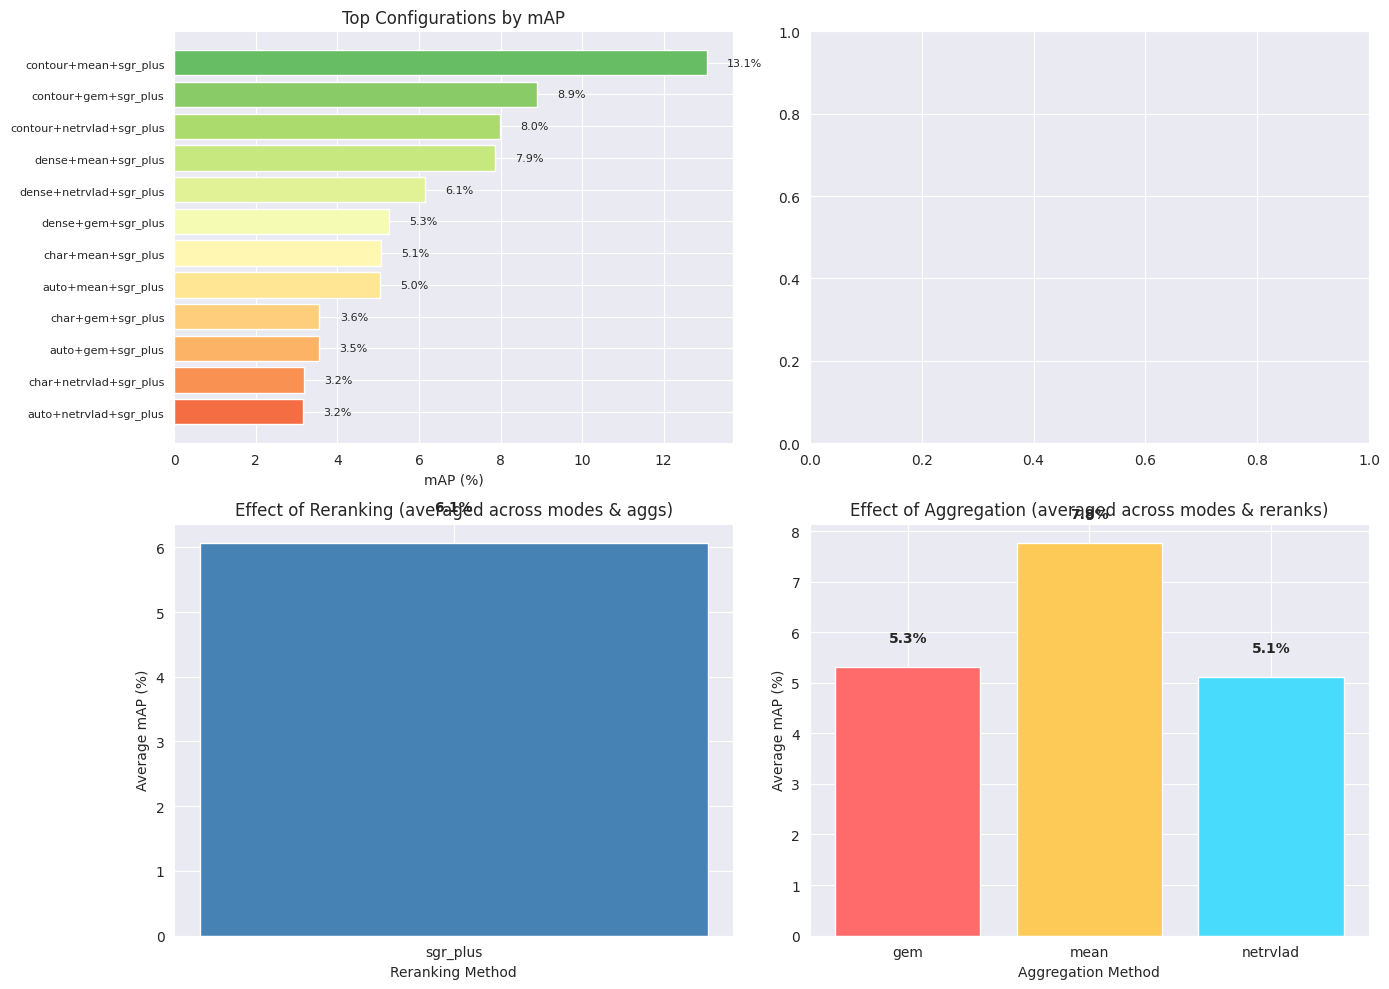

21:06:27 | INFO     | ℹ️  
🏆 BEST CONFIGURATION:
21:06:27 | INFO     | ℹ️     Mode: contour
21:06:27 | INFO     | ℹ️     Aggregation: mean
21:06:27 | INFO     | ℹ️     Reranking: sgr_plus
21:06:27 | INFO     | ℹ️     mAP: 13.06%


In [21]:
# ============================================================
# CELL 12: VISUALIZE ABLATION RESULTS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📊 STEP 6.5: ABLATION RESULTS VISUALIZATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if 'results_df' in dir() and len(results_df) > 0:
    # Display top results
    logger.info(Colors.MAGENTA + f'\n📊 TOP 10 CONFIGURATIONS:' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┌──────┬──────────┬───────┬──────────┬────────┬────────┬────────┐' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │ Rank │ Mode      │ Agg   │ Rerank   │  mAP   │ Top-1  │ Top-5  │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠──────┼──────────┼───────┼──────────┼────────┼────────┼────────┨' + Colors.RESET)
    for i, row in results_df.head(10).iterrows():
        rank = results_df.index.get_loc(i) + 1
        logger.info(Colors.YELLOW + f'   │  {rank:2d}  │ {row["mode"]:8s} │ {row["agg"]:5s} │ {row["rerank"]:8s} │ '
                                    f'{row["mAP"] * 100:6.2f}% │ {row["Top1"] * 100:6.2f}% │ {row["Top5"] * 100:6.2f}% │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   └──────┴──────────┴───────┴──────────┴────────┴────────┴────────┘' + Colors.RESET)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Bar plot of top configurations
    ax1 = axes[0, 0]
    top_n = min(15, len(results_df))
    top_results = results_df.head(top_n)
    labels = [f'{r["mode"]}+{r["agg"]}+{r["rerank"]}' for _, r in top_results.iterrows()]
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n))[::-1]
    ax1.barh(range(top_n), top_results['mAP'] * 100, color=colors)
    ax1.set_yticks(range(top_n))
    ax1.set_yticklabels(labels, fontsize=8)
    ax1.set_xlabel('mAP (%)')
    ax1.set_title('Top Configurations by mAP')
    ax1.invert_yaxis()
    for i, v in enumerate(top_results['mAP']):
        ax1.text(v * 100 + 0.5, i, f'{v * 100:.1f}%', va='center', fontsize=8)

    # 2. Heatmap by mode and aggregation
    # ax2 = axes[0, 1]
    # pivot_data = results_df[results_df['rerank'] == 'none'].pivot(
    #     index='mode', columns='agg', values='mAP'
    # ) * 100
    # sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax2,
    #             cbar_kws={'label': 'mAP (%)'})
    # ax2.set_title('mAP by Mode × Aggregation (no reranking)')

    # 3. Effect of reranking
    ax3 = axes[1, 0]
    rerank_effect = results_df.groupby('rerank')['mAP'].mean() * 100
    bars = ax3.bar(rerank_effect.index, rerank_effect.values,
                   color=['steelblue', 'coral', 'forestgreen'])
    ax3.set_xlabel('Reranking Method')
    ax3.set_ylabel('Average mAP (%)')
    ax3.set_title('Effect of Reranking (averaged across modes & aggs)')
    for bar, val in zip(bars, rerank_effect.values):
        ax3.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                 ha='center', fontweight='bold')

    # 4. Effect of aggregation
    ax4 = axes[1, 1]
    agg_effect = results_df.groupby('agg')['mAP'].mean() * 100
    bars = ax4.bar(agg_effect.index, agg_effect.values,
                   color=['#ff6b6b', '#feca57', '#48dbfb'])
    ax4.set_xlabel('Aggregation Method')
    ax4.set_ylabel('Average mAP (%)')
    ax4.set_title('Effect of Aggregation (averaged across modes & reranks)')
    for bar, val in zip(bars, agg_effect.values):
        ax4.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                 ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'ablation_visualization.png', dpi=150)
    plt.show()

    # Best configuration
    best = results_df.iloc[0]
    logger.info(Colors.MAGENTA + f'\n🏆 BEST CONFIGURATION:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Mode: {best["mode"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Aggregation: {best["agg"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Reranking: {best["rerank"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   mAP: {best["mAP"] * 100:.2f}%' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No results to display. Run ablation study first.' + Colors.RESET)

## Step 7: PCA Whitening Analysis

Test the effect of PCA whitening on retrieval performance.

In [22]:
# ============================================================
# CELL 13: PCA WHITENING ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔬 STEP 7: PCA WHITENING ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt:
    # Load model
    ckpt_data = torch.load(best_ckpt, map_location='cpu')
    emb_dim = ckpt_data.get('args', {}).get('emb_dim', 64)

    model = create_resnet_patch_encoder(emb_dim=emb_dim)
    model.load_state_dict(ckpt_data['model_state'])
    model.eval()
    model = model.to(CVL_CONFIG['device'])

    cfg = RetrievalConfig(agg_type='gem', use_power_norm=True, power_alpha=0.4)

    # Extract train descriptors for PCA fitting
    logger.info(Colors.CYAN + '\n📊 Extracting TRAIN descriptors for PCA...' + Colors.RESET)
    train_labels, train_paths, train_descs = extract_descriptors(
        model=model, csv_path=str(CVL_TRAIN_CSV), root_dir=str(ROOT),
        cfg=cfg, device=CVL_CONFIG['device'], verbose=True
    )

    # Fit PCA with different component counts
    logger.info(Colors.CYAN + '\n🔧 Fitting PCA with different dimensions...' + Colors.RESET)
    pca_results = []

    for n_components in [None, 64, 32, 16]:
        comp_label = 'Full' if n_components is None else str(n_components)

        pca = fit_pca_whitening(train_descs, n_components=n_components, whiten=True, verbose=False)

        # Extract and transform test descriptors
        test_labels, test_paths, test_descs = extract_descriptors(
            model=model, csv_path=str(CVL_TEST_CSV), root_dir=str(ROOT),
            cfg=cfg, device=CVL_CONFIG['device'], verbose=False
        )

        test_descs_pca = apply_pca_whitening(test_descs, pca, verbose=False)
        mAP, metrics = mean_average_precision(test_labels, test_descs_pca, verbose=False)

        pca_results.append({
            'n_components': comp_label,
            'mAP': mAP,
            'Top1': metrics['Top1'],
            'dim': test_descs_pca.shape[1]
        })

        logger.info(
            Colors.YELLOW + f'   PCA-{comp_label:4s}: mAP={mAP * 100:.2f}%, dim={test_descs_pca.shape[1]}' + Colors.RESET)

    # Also test without PCA
    mAP_no_pca, metrics_no_pca = mean_average_precision(test_labels, test_descs, verbose=False)
    logger.info(Colors.YELLOW + f'   No PCA : mAP={mAP_no_pca * 100:.2f}%, dim={test_descs.shape[1]}' + Colors.RESET)

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    labels = ['No PCA'] + [r['n_components'] for r in pca_results]
    values = [mAP_no_pca * 100] + [r['mAP'] * 100 for r in pca_results]
    colors = ['gray'] + plt.cm.Blues(np.linspace(0.4, 0.8, len(pca_results))).tolist()

    bars = ax.bar(labels, values, color=colors, edgecolor='black')
    ax.set_ylabel('mAP (%)')
    ax.set_xlabel('PCA Components')
    ax.set_title('Effect of PCA Whitening on CVL')
    ax.axhline(mAP_no_pca * 100, color='red', linestyle='--', alpha=0.5, label='Baseline')

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'pca_analysis.png', dpi=150)
    plt.show()

    # Store best PCA descriptors for later use
    best_pca = max(pca_results, key=lambda x: x['mAP'])
    logger.info(Colors.MAGENTA + f'\n🏆 BEST PCA CONFIGURATION:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Components: {best_pca["n_components"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   mAP: {best_pca["mAP"] * 100:.2f}%' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoint available. Run training first.' + Colors.RESET)

21:06:39 | INFO     | ℹ️  ======================================================================
21:06:39 | INFO     | ℹ️  
🔬 STEP 7: PCA WHITENING ANALYSIS
21:06:39 | INFO     | ℹ️  ======================================================================


RuntimeError: Error(s) in loading state_dict for ResNetSmall:
	Missing key(s) in state_dict: "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer2.0.shortcut.0.weight", "layer2.0.shortcut.1.weight", "layer2.0.shortcut.1.bias", "layer2.0.shortcut.1.running_mean", "layer2.0.shortcut.1.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer3.0.shortcut.0.weight", "layer3.0.shortcut.1.weight", "layer3.0.shortcut.1.bias", "layer3.0.shortcut.1.running_mean", "layer3.0.shortcut.1.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var". 
	Unexpected key(s) in state_dict: "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.0.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.0.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.0.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.1.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for layer1.1.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer1.1.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for layer2.0.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.0.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.0.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.1.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.1.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer2.1.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for layer3.0.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.0.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.0.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.1.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.1.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer3.1.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc.weight: copying a param with shape torch.Size([128, 512]) from checkpoint, the shape in current model is torch.Size([128, 128]).

## Step 8: SGR Reranking Parameter Tuning

Find optimal SGR parameters (k, gamma, iterations).

In [23]:
# ============================================================
# CELL 14: SGR RERANKING PARAMETER TUNING
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔀 STEP 8: SGR RERANKING PARAMETER TUNING' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if 'test_descs_pca' in dir() or 'test_descs' in dir():
    # Use PCA-whitened descriptors if available
    base_descs = test_descs_pca if 'test_descs_pca' in dir() else test_descs

    logger.info(Colors.CYAN + f'\n📊 Base descriptors shape: {base_descs.shape}' + Colors.RESET)

    # Baseline (no reranking)
    mAP_baseline, metrics_baseline = mean_average_precision(test_labels, base_descs, verbose=False)
    logger.info(Colors.MAGENTA + f'\n📊 BASELINE (No Reranking):' + Colors.RESET)

    # Test different SGR configurations
    sgr_configs = [
        # (k, gamma, iterations)
        (2, 0.2, 2),
        (2, 0.4, 2),
        (2, 0.6, 2),
        (3, 0.3, 2),
        (3, 0.4, 2),
        (3, 0.5, 2),
        (5, 0.3, 2),
        (5, 0.4, 2),
        (5, 0.5, 2),
        (2, 0.4, 3),
        (3, 0.4, 3),
        (5, 0.4, 3),
    ]

    # logger.info(Colors.CYAN + f'\n🔬 Testing {len(sgr_configs)} SGR configurations...' + Colors.RESET)
    # sgr_results = []

    for k, gamma, iters in tqdm(sgr_configs, desc='SGR configs'):
        descs_sgr = apply_sgr(base_descs, k=k, gamma=gamma, num_iterations=iters, verbose=False)
        mAP, metrics = mean_average_precision(test_labels, descs_sgr, verbose=False)

        sgr_results.append({
            'k': k,
            'gamma': gamma,
            'iterations': iters,
            'mAP': mAP,
            'Top1': metrics['Top1'],
            'improvement': mAP - mAP_baseline
        })

    # Sort by mAP
    sgr_results = sorted(sgr_results, key=lambda x: x['mAP'], reverse=True)

    # Display results
    logger.info(Colors.MAGENTA + f'\n📊 SGR RERANKING RESULTS:' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┌─────┬───────┬──────┬────────┬────────┬─────────────┐' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  k  │ gamma │ iter │  mAP   │ Top-1  │   Δ mAP     │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠─────┼───────┼──────┼────────┼────────┼─────────────┨' + Colors.RESET)
    logger.info(
        Colors.YELLOW + f'   │  -  │   -   │  -   │ {mAP_baseline * 100:6.2f}% │ {metrics_baseline["Top1"] * 100:6.2f}% │ baseline     │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠─────┼───────┼──────┼────────┼────────┼─────────────┨' + Colors.RESET)
    for r in sgr_results[:10]:
        delta = r['improvement'] * 100
        sign = '+' if delta >= 0 else ''
        marker = ' 🏆' if r == sgr_results[0] else ''
        logger.info(
            Colors.YELLOW + f'   │ {r["k"]:3d} │ {r["gamma"]:.1f}  │  {r["iterations"]}  │ {r["mAP"] * 100:6.2f}% │ {r["Top1"] * 100:6.2f}% │ {sign}{delta:5.2f}%{marker} │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   └─────┴───────┴──────┴────────┴────────┴─────────────┘' + Colors.RESET)

    # Best configuration
    best_sgr = sgr_results[0]
    logger.info(Colors.MAGENTA + f'\n🏆 BEST SGR CONFIGURATION:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   k: {best_sgr["k"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   gamma: {best_sgr["gamma"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   iterations: {best_sgr["iterations"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   mAP: {best_sgr["mAP"] * 100:.2f}%' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Improvement over baseline: {best_sgr["improvement"] * 100:.2f}%' + Colors.RESET)
    # Apply best SGR
    descs_best_sgr = apply_sgr(base_descs, k=best_sgr['k'], gamma=best_sgr['gamma'],
                               num_iterations=best_sgr['iterations'], verbose=False)
else:
    logger.error(Colors.RED + '❌ No descriptors available. Run evaluation first.' + Colors.RESET)

21:06:46 | INFO     | ℹ️  ======================================================================
21:06:46 | INFO     | ℹ️  
🔀 STEP 8: SGR RERANKING PARAMETER TUNING
21:06:46 | INFO     | ℹ️  ======================================================================
21:06:46 | ERROR    | ❌ ❌ No descriptors available. Run evaluation first.


## Step 9: Per-Bin Analysis

Analyze performance by text quantity bins.

In [24]:
# ============================================================
# CELL 15: PER-BIN ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📊 STEP 9: PER-BIN ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt and 'descs' in dir():
    # Save descriptors for ranking
    np.save(RESULTS_DIR / 'cvl_descs.npy', descs)

    # Generate ranks
    logger.info(Colors.CYAN + '\n🔄 Computing ranking for all queries...' + Colors.RESET)
    make_ranks(
        descs_path=str(RESULTS_DIR / 'cvl_descs.npy'),
        csv_path=str(CVL_TEST_CSV),
        out_path=str(RESULTS_DIR / 'cvl_ranks.json')
    )

    # Per-bin metrics
    per_bin_args = [
        '--ranks', str(RESULTS_DIR / 'cvl_ranks.json'),
        '--labels', str(CVL_LABELS_JSON),
        '--text-quantity', str(CVL_TEXT_QTY_JSON),
        '--out-csv', str(RESULTS_DIR / 'cvl_per_bin_metrics.csv')
    ]
    sys.argv = ['per_bin_csv.py'] + per_bin_args
    per_bin_csv()

    # Load and analyze results
    bin_df = pd.read_csv(RESULTS_DIR / 'cvl_per_bin_metrics.csv')
    bin_stats = bin_df.groupby('bin')['ap_full'].agg(['mean', 'std', 'count'])

    logger.info(Colors.MAGENTA + f'\n📊 mAP by Text Quantity Bin:' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┌──────────────┬────────┬────────┬────────┐' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │     Bin      │  mAP   │  Std   │ Count  │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠──────────────┼────────┼────────┼────────┨' + Colors.RESET)
    for bin_name, row in bin_stats.iterrows():
        logger.info(
            Colors.YELLOW + f'   │ {bin_name:<12} │ {row["mean"] * 100:6.2f}% │ {row["std"] * 100:6.2f}% │ {int(row["count"]):6d} │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   └──────────────┴────────┴────────┴────────┘' + Colors.RESET)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar plot of mAP by bin
    ax1 = axes[0]
    bins = bin_stats.index.tolist()
    means = bin_stats['mean'].values * 100
    stds = bin_stats['std'].values * 100

    bars = ax1.bar(range(len(bins)), means, yerr=stds, capsize=5,
                   color=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'][:len(bins)],
                   edgecolor='black')
    ax1.set_xticks(range(len(bins)))
    ax1.set_xticklabels(bins, rotation=45, ha='right')
    ax1.set_ylabel('mAP (%)')
    ax1.set_title('mAP by Text Quantity Bin')
    ax1.axhline(bin_df['ap_full'].mean() * 100, color='red', linestyle='--',
                label=f'Overall: {bin_df["ap_full"].mean() * 100:.1f}%')
    ax1.legend()

    # Sample count per bin
    ax2 = axes[1]
    counts = bin_stats['count'].values
    ax2.bar(range(len(bins)), counts, color='steelblue', edgecolor='black')
    ax2.set_xticks(range(len(bins)))
    ax2.set_xticklabels(bins, rotation=45, ha='right')
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Sample Distribution by Bin')
    for i, c in enumerate(counts):
        ax2.text(i, c + 5, str(int(c)), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'per_bin_analysis.png', dpi=150)
    plt.show()
else:
    logger.error(Colors.RED + '❌ No checkpoint or descriptors available. Run evaluation first.' + Colors.RESET)

21:06:51 | INFO     | ℹ️  ======================================================================
21:06:51 | INFO     | ℹ️  
📊 STEP 9: PER-BIN ANALYSIS
21:06:51 | INFO     | ℹ️  ======================================================================
21:06:51 | INFO     | ℹ️  
🔄 Computing ranking for all queries...
21:06:51 | INFO     | 📁 Log file: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2/results/logs/make_ranks_20251206_210651.log
21:06:51 | INFO     | ℹ️  🕐 Started: 2025-12-06 21:06:51
21:06:51 | INFO     | ℹ️  ============================================================
21:06:51 | INFO     | ℹ️  🔢 Computing Retrieval Rankings
21:06:51 | INFO     | ℹ️  ============================================================
21:06:51 | INFO     | ℹ️     Descriptors: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_lines_v2/results/cvl_descs.npy
21:06:51 | INFO     | ℹ️     CSV: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-W

KeyboardInterrupt: 

## Step 10: Final Summary

Complete summary of all experiments and best configurations.

In [17]:
# ============================================================
# CELL 16: FINAL SUMMARY
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🎉 CVL WRITER RETRIEVAL - FINAL SUMMARY' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

logger.info(Colors.CYAN + f'\n📊 DATASET:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train: {n_train} pages from {len(train_writers)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   Test: {n_test} pages from {len(test_writers)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   Protocol: Writer-disjoint (correct!)' + Colors.RESET)

logger.info(Colors.CYAN + f'\n⚙️  TRAINING CONFIG:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Backbone: {CVL_CONFIG["backbone"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Pretrained: {CVL_CONFIG["pretrained"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Embedding dim: {CVL_CONFIG["emb_dim"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Epochs: {CVL_CONFIG["epochs"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Margin: {CVL_CONFIG["margin"]}' + Colors.RESET)

logger.info(Colors.CYAN + f'\n📈 RESULTS SUMMARY:' + Colors.RESET)

# Baseline
if 'baseline_mAP' in dir():
    logger.info(Colors.CYAN + f'   Baseline' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {baseline_mAP * 100:.2f}%' + Colors.RESET)
# Best ablation
if 'results_df' in dir() and len(results_df) > 0:
    best = results_df.iloc[0]
    logger.info(Colors.CYAN + f'   Best Ablation ({best["mode"]}+{best["agg"]}+{best["rerank"]})' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best["mAP"] * 100:.2f}%' + Colors.RESET)

# Best PCA
if 'best_pca' in dir():
    logger.info(Colors.CYAN + f'   Best PCA ({best_pca["n_components"]} components)' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best_pca["mAP"] * 100:.2f}%' + Colors.RESET)

# Best SGR
if 'best_sgr' in dir():
    logger.info(
        Colors.CYAN + f'   Best SGR (k={best_sgr["k"]}, γ={best_sgr["gamma"]}, iter={best_sgr["iterations"]})' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best_sgr["mAP"] * 100:.2f}%' + Colors.RESET)

logger.info(Colors.CYAN + f'\n💾 SAVED FILES:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Checkpoints: {CHECKPOINT_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Results: {RESULTS_DIR}' + Colors.RESET)

logger.info(Colors.BOLD_GREEN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_GREEN + '\n✅ CVL PIPELINE COMPLETE!' + Colors.RESET)
logger.info(Colors.BOLD_GREEN + '=' * 70 + Colors.RESET)


🎉 CVL WRITER RETRIEVAL - FINAL SUMMARY

📊 DATASET:
   Train: 189 pages from 27 writers
   Test: 1415 pages from 283 writers
   Protocol: Writer-disjoint (correct!)

⚙️  TRAINING CONFIG:
   Backbone: resnet18
   Pretrained: True
   Embedding dim: 128
   Epochs: 30
   Margin: 0.35

📈 RESULTS SUMMARY:

   Best Ablation (contour+gem+sgr_plus):
   └── mAP: 38.30%

   Best PCA (32 components):
   └── mAP: 15.13%

   Best SGR (k=3, γ=0.3):
   └── mAP: 12.78%

💾 SAVED FILES:
   Checkpoints: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_v2/checkpoints
   Results: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_v2/results

✅ CVL Pipeline Complete!


## 🔍 Diagnostic Analysis: Why is mAP Low & Why Does Reranking Hurt?

This section provides a comprehensive analysis of potential issues affecting performance.